# Explore Simple QA

### Sources

Simple QA dataset downloaded from: https://www.dropbox.com/s/tohrsllcfy7rch4/SimpleQuestions_v2.tgz

FB5M names downloaded from: https://www.dropbox.com/s/yqbesl07hsw297w/FB5M.name.txt

### Experiments

- Question Consistency:
    - [ ] Hypothesis some questions do not fit the distribution. Look at the bottom 1% of questions that have unique tokens. We known double spaces or question marks are not consistent.
- Entity Detection
    - [x] Hypothesis is that the object to be detected is not found in the question. Figure out how many objects are not in the question.
    - [ ] Experiment with CRF and copy model for entity detection.
- Entity Linking
    - [x] Santity check that the true object is in FB5M.
    - [x] Santity check all MIDs have an associated english name.
    - [x] Hypothesis that objects have duplicates. Given the true object, measure how many duplicates need to be parsed through on the validation set. 
        - [ ] Hypothesis there are external features that help linking. Experiment with which features best predict the object.
            - [ ] Hypothesis is that type of the entity could help disambiguate duplicates.
- Relation Detection
    - [x] Hypothesis that some of the relations occur in dev and do not occur in train. Measure this affect.
        - [ ] Hypothesis that the unknown relations can be extrapolated from words. Check if some of the relation words are unknown.
        - [ ] Hypothesis that the unknown relations can be extrapolated from words. Check which levels 1, 2 or 3 are unknown in the relation.
        - [ ] Experiment with beam search for relations and word tokenization. Beam search will help us get the top 2 - 3 beams.
    - [ ] Hypothesis that questions without entities map to the same relations; it's impossible to tell between some relations; therefore, it's not possible to predict the relation.
- Relation and Entity to Fact
    - [x] Santity check that FB5M has the facts corresponding to the answer given the true relation and the true entity.
    
### Background On Data Collection

Knowledge Bases contain facts expressed as triples (subject, relationship, object), where subject and object are entities and relationship describes the type of (directed) link between these entities. The simple QA problem we address here consist in finding the answer to questions that can be rephrased as queries of the form (subject, relationship, ?), asking for all objects linked to subject by relationship.

The question What do Jamaican people speak ?, for instance, could be rephrased as the Freebase query (jamaica, language spoken, ?). In other words, fetching a single fact from a KB is sufficient to answer correctly.

Reference: https://research.fb.com/wp-content/uploads/2016/11/large-scale_simple_question_answering_with_memory_networks.pdf?
    
### Setup

Setup variables to help run experiments.

In [2]:
simple_qa = {
    'train': '../../data/SimpleQuestions_v2/annotated_fb_data_train.txt',
    'dev': '../../data/SimpleQuestions_v2/annotated_fb_data_valid.txt',
    'test': '../../data/SimpleQuestions_v2/annotated_fb_data_test.txt',
}

Connect to PostgresSQL to run experiments.

In [3]:
import os
import psycopg2
import psycopg2.extras

# Load .env file
pass_ = {}
for line in open('../../.pass'):
    split = line.strip().split('=')
    pass_[split[0]] = split[1]

# Connect    
connection = psycopg2.connect(dbname=pass_['DB_NAME'],
                              port=pass_['DB_PORT'],
                              user=pass_['DB_USER'],
                              host=pass_['DB_HOST'],
                              password=pass_['DB_PASS'])
cursor = connection.cursor()

Load up the development and train data.

In [4]:
from sklearn.utils import shuffle

import pandas as pd

def preprocess(row):
    # Remove `www.freebase.com/` to match format of PostgreSQL
    row['subject'] = row['subject'].strip().replace('www.freebase.com/m/', '')
    row['relation'] = row['relation'].strip().replace('www.freebase.com/', '')
    row['object'] = row['object'].strip().replace('www.freebase.com/m/', '')
    return row

df_dev = pd.read_table(simple_qa['dev'], header=None, names=['subject', 'relation', 'object', 'question'])
df_dev = shuffle(df_dev, random_state=123)
df_dev = df_dev.apply(preprocess, axis=1)
df_dev[:5]

subject                                           relation   object  \
6219     03k3r  biology/organism_classification/organisms_of_t...  0bs56bp   
3364   02qlppc                   cvg/computer_videogame/cvg_genre   01sjng   
9374    02l7c8                               tv/tv_genre/programs  0dlmm88   
10142  049_zj3                      location/location/containedby    04rrx   
97     02w9ycr              people/deceased_person/cause_of_death    0qcr0   

                                                question  
6219           Name an American Thoroughbread racehorse   
3364   what kind of game is vision racing driving sim...  
9374                     what tv program is romance film  
10142                  what state is  polaski located in  
97          what disease claimed the life of fern emmett

In [5]:
df_train = pd.read_table(simple_qa['train'], header=None, names=['subject', 'relation', 'object', 'question'])
df_train = shuffle(df_train, random_state=123)
df_train = df_train.apply(preprocess, axis=1)
df_train[:5]

subject                    relation   object  \
67691  0fqd80r          music/artist/genre   01kcty   
60980   01v7rw  book/written_work/subjects    07dg1   
44045  03fl5vh         music/release/track   0x7w6c   
35944   05sq1b  common/topic/notable_types  01xpjyz   
44254  03yzs66    music/release/track_list  0n2nvvl   

                                                question  
67691     what type of musician is bruna cara considered  
60980        what is the book troilus and cressida about  
44045            what is a single on the release busted   
35944           what is the duluth international airport  
44254  what song is on the release welcome to haiti: ...

## Santity: True Entity and True Relation map to True Subject

Ensure that the facts used to build the row are present in the FB5M dataset. This invariant must hold true.

In [6]:
from tqdm import tqdm_notebook
from IPython.display import display, Markdown

def check_fact_invariant(df):
    n_failed = 0.0
    for _, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        sql = """SELECT count(*)
        FROM fb_kg
        WHERE object_mid='{object_mid}'
        AND relation='{relation}'
        AND subject_mid='{subject_mid}'
        """.format(object_mid=row['object'],
                   relation=row['relation'],
                   subject_mid=row['subject'])

        cursor.execute(sql)
        n_rows = cursor.fetchone()[0]
        if n_rows == 0:
            print('\n[%d] FACT NOT FOUND' % n_failed)
            print('SQL: %s' % (sql))
            n_failed += 1

    
    display(Markdown(
        '### Numbers' + 
        'Facts in not found in KG FB5M\n' + 
        'Failed %%%f [%d of %d]' % ((n_failed / df.shape[0]) * 100, n_failed, df.shape[0])
    ))

check_fact_invariant(df_dev)

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))


[0] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='07s9rl0'
        AND relation='film/film/genre'
        AND subject_mid='07gkcf'
        

[1] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='0kg1cyw'
        AND relation='people/profession/people_with_this_profession'
        AND subject_mid='02h664x'
        



### NumbersFacts in not found in KG FB5M
Failed %0.018442 [2 of 10845]

In [7]:
check_fact_invariant(df_train)

HBox(children=(IntProgress(value=0, max=75910), HTML(value='')))


[0] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='02lx2r'
        AND relation='music/album/release_type'
        AND subject_mid='01gd34t'
        

[1] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='02jbfk'
        AND relation='music/album/album_content_type'
        AND subject_mid='0fy0qfr'
        

[2] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='0ftqr'
        AND relation='music/composition/composer'
        AND subject_mid='0zj9_cn'
        

[3] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='07s9rl0'
        AND relation='film/film/genre'
        AND subject_mid='07m_vq'
        

[4] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='0tkg6cp'
        AND relation='people/profession/people_with_this_profession'
        AND subject_mid='02h664x'
        

[5] FACT NOT FOUND
SQL: SELECT count(*)
        FROM f

### NumbersFacts in not found in KG FB5M
Failed %0.032934 [25 of 75910]

### Discussion

The invariant failed but at most .03% of rows are affected; therefore, this is not significant. It's concerning a basic invariant failed though. FB5M should be a superset of the annotated questions; otherwise, those questions are impossible.

## Hypothesis: Object Name not in Question

For every `subject_mid`, if there exists a name then that name may not be directly stated in the question.

### Tranformations

The question is lowercased and tokenized by `TreebankWordTokenizer`. Due to the fact that the names have a similar tokenization strategy. 

In [8]:
from nltk.tokenize.treebank import TreebankWordTokenizer
from IPython.display import display

tokenize = TreebankWordTokenizer().tokenize

def preprocess_question(row):
    # Remove `www.freebase.com/` to match format of PostgreSQL
    question = row['question'].strip()
    question = ' '.join(tokenize(question.lower()))
    return question

df_dev['question_tokenized'] = df_dev.apply(preprocess_question, axis=1)
display(df_dev[:5])
df_train['question_tokenized'] = df_train.apply(preprocess_question, axis=1)

subject                                           relation   object  \
6219     03k3r  biology/organism_classification/organisms_of_t...  0bs56bp   
3364   02qlppc                   cvg/computer_videogame/cvg_genre   01sjng   
9374    02l7c8                               tv/tv_genre/programs  0dlmm88   
10142  049_zj3                      location/location/containedby    04rrx   
97     02w9ycr              people/deceased_person/cause_of_death    0qcr0   

                                                question  \
6219           Name an American Thoroughbread racehorse    
3364   what kind of game is vision racing driving sim...   
9374                     what tv program is romance film   
10142                  what state is  polaski located in   
97          what disease claimed the life of fern emmett   

                                      question_tokenized  
6219            name an american thoroughbread racehorse  
3364   what kind of game is vision racing driving sim...  
9374                     what tv program is romance film  
10142                   what state is polaski located in  
97          what disease claimed the life of fern emmett

In [13]:
import textwrap
from functools import partial
from tqdm import tqdm_notebook
from numpy import nan

def get_name_in_question(question, names):
    """ Get the longest name in the question """
    names = sorted([name for name in names], key=lambda k: len(k), reverse=True)
    for name in names:
        if name in question:
            return name
    return nan

def add_subject_name(df, print_=False):
    n_failed_no_subject_reference = 0
    n_failed_no_alias = 0
    print_row = 0
    subject_names = []
    
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        cursor.execute("SELECT alias FROM fb_name WHERE mid=%s", (row['subject'], ))
        rows = cursor.fetchall()
        if len(rows) == 0:
            n_failed_no_alias += 1
            if print_:
                print('Subject MID (%s) does not have aliases.' % row['subject'])
            subject_names.append(nan)
            df.loc[index, 'subject_name'] = nan
            continue
        names = [row[0].strip().lower() for row in rows]
        subject_name = get_name_in_question(row['question_tokenized'], names)
        if subject_name is nan:
            n_failed_no_subject_reference += 1
            if print_row < 50 and print_:
                # Print rows for markdown table
                # Sample the first 50 failed
                print_row += 1
                names = textwrap.shorten(', '.join(names), width=80, placeholder="...")
                print('| ' + str(print_row) + ' | ' + row['question_tokenized'] + ' | '
                      + row['subject'] + ' | ' + names + ' | |')
        
        subject_names.append(subject_name)
    
    df['subject_name'] = pd.Series(subject_names, index=df.index)

    if print_:
        display(Markdown(
            '### Numbers' + 
            '\n%f%% [%d of %d] questions do not reference subject' %
            ((n_failed_no_subject_reference / df.shape[0]) * 100, n_failed_no_subject_reference, df.shape[0]) +
            '\n\n%f%% [%d of %d] subject mids do not have aliases' %
            ((n_failed_no_alias / df.shape[0]) * 100, n_failed_no_alias, df.shape[0])
        ))

add_subject_name(df_dev, print_=True)

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))

| 1 | what was involved in the red clouds war ? | 02fjhv | red cloud 's war | |
| 2 | which canadian city is served by e > | 0359ld | seychelles airport, seychelles international airport | |
| 3 | what is peters point plantation 's architectural style | 06_l40z | peter 's point plantation | |
| 4 | what film is rated pg | 0kprc8 | pg ( usa ) | |
| 5 | what is an active ingredient in teething ? | 0hqv3wh | tribasic calcium phosphate - matricaria recutita - arabica coffee bean... | |
| 6 | what is the name of the track list for the release pillows & prayers : cherry red 1982-1983 ? | 0f3hh9h | pillows & prayers : cherry red 1982–1983 | |
| 7 | what is the birth place of james aiona | 02_ks3 | duke aiona | |
| 8 | what kind of music is fragmentsofunbecoming known for ? | 0g92n_ | fragments of unbecoming, fragments of unbecoming | |
| 9 | where was kristythirsk born | 01phhd5 | thirsk , kristy, kristy thirsk | |
| 10 | where did the battle of hudsons bay take place | 0cyg9y | battle of hud

### Numbers
3.669894% [398 of 10845] questions do not reference subject

0.627017% [68 of 10845] subject mids do not have aliases

### Error Bucket

| Index | Question | Subject MID | Names | Bucket |
|:-----:|:-----:|:-----:|:-----:|:-----:|
| 1 | what was involved in the red clouds war ? | 02fjhv | red cloud 's war | Apostrophe |
| 2 | which canadian city is served by e > | 0359ld | seychelles airport, seychelles international airport | Missing Name |
| 3 | what is peters point plantation 's architectural style | 06_l40z | peter 's point plantation | Apostrophe |
| 4 | what film is rated pg | 0kprc8 | pg ( usa ) | Parentheses |
| 5 | what is an active ingredient in teething ? | 0hqv3wh | tribasic calcium phosphate - matricaria recutita - arabica coffee bean... | Missing Name |
| 6 | what is the name of the track list for the release pillows & prayers : cherry red 1982-1983 ? | 0f3hh9h | pillows & prayers : cherry red 1982–1983 | Dash |
| 7 | what is the birth place of james aiona | 02_ks3 | duke aiona | Missing Name |
| 8 | what kind of music is fragmentsofunbecoming known for ? | 0g92n_ | fragments of unbecoming, fragments of unbecoming | Concatenated |
| 9 | where was kristythirsk born | 01phhd5 | thirsk , kristy, kristy thirsk | Concatenated |
| 10 | where did the battle of hudsons bay take place | 0cyg9y | battle of hudson 's bay | Apostrophe |
| 11 | which country originally showed e.n.g . | 055y4f | e.n.g. | Abbreviation |
| 12 | what is ikkyu 's gender ? | 03gccd | ikkyū | Accent & Apostrophe |
| 13 | who is the composer of another horsedreamer ’ s blues | 0zlxj1z | another horsedreamer’s blues | Apostrophe |
| 14 | name a topical medicine | 03jy9d | topical medication | Synonym |
| 15 | what baseball position does play | 02qbjc3 | mike stefanski | Missing Name |
| 16 | what newspaper circulates in the town of kearny | 013kcv | t-town, tulsa , oklahoma, wagoner county / tulsa city, tulsa | Missing Name |
| 17 | what is a japanese netflix movie | 0gw5n2f | japanese movies | Missing Name |
| 18 | which military conflict was cincinnatus involved in ? | 017tcg | lucius quinctius cincinnatus | Partial Match |
| 19 | which musician plays the drum kit | 02hnl | drum set, drummer, drums & cymbals, drumset, rumpusetti, drums | Synonym |
| 20 | what state is dimillos floating restaurant in ? | 0ddb60x | dimillo 's floating restaurant | Apostrophe |
| 21 | what is tinsleyellis 's profession ? | 01nzbnm | ellis , tinsley, tnsley ellis, tinsley ellis | Concatenated |
| 22 | who produces npr : wait wait ... dont tell me ! podcast | 041z1gp | npr : wait wait ... do n't tell me !, wait wait ... do n't tell me !, wait... | Apostrophe |
| 23 | what instrument does ralphsantolla play | 0fjz2n | santolla , ralph, ralph santolla | Concatenated |
| 24 | what theme is in the piece regatta mystery | 0b55z6 | the regatta mystery | Article ~ "the" |
| 25 | what genre of music does houseofpleasure make | 09hntw | plan b | Missing Name |
| 26 | what is the formulation of clear defense hand sanitizing wipes | 0hqtqnf | alcohol 3.32 cloth | Missing Name |
| 27 | what is the birth place of charles a. pascal , jr . | 0853_8 | charles pascal , jr., charles a. pascal , jr. | Period |
| 28 | name a racing game | 01sjng | racing video game | Partial Match |
| 29 | what is álvaro dataide da gama | 0lt7d9h | álvaro d'ataide da gama | Apostrophe |
| 30 | what song is by u.n.p.o.c . | 01qhzks | unpoc, u.n.p.o.c. | Abbreviation |
| 31 | name a census-designated place | 0qq4b | navajo county / pinon cdp, pinon , arizona, piñon , arizona, piñon | Missing Name |
| 32 | what ethnicity is jermaine jackson ? | 0x67 | africian-american, afro-american, black, black american, african american | Missing Name |
| 33 | what is the series where the episode this puds for you comes from | 05dfxn4 | this pud 's for you | Apostrophe |
| 34 | what genre is kazz kumar 's music ? | 064t9 | pop, pop music | Missing Name |
| 35 | where was now thats what i call music ! 28 released ? | 049k9qr | now that 's what i call music ! 28 | Apostrophe |
| 36 | how is the drug nefazodone hydrochloride administered | 0hqtdkp | nefazodone hydrochloride 50 tablet | Partial Match |
| 37 | who sings chets speech , part ii | 0lqg4r | chet 's speech , part 2, chet 's speech , part ii | Apostrophe |
| 38 | which ingredient is used in fungicure manicure pedicure | 0hqs33g | clotrimazole 10 liquid | Missing Name |
| 39 | what is the legal status of tylenol cold sore throat extra strength ? | 0hqv2b2 | acetaminophen 33.333 liquid | Missing Name |
| 40 | what genre music does andre sutherland do ? | 0cmbjx3 | poppy, popcaan | Missing Name |
| 41 | what is the active component of ob metab | 0hqs_sg | fucus vesiculosus , capsicum annuum , nicotinamidum , spongia tosta ,... | Missing Name |
| 42 | what country filmed vla lcinéma ou le roman de charles pathé | 0fpwzjl | the life of charles pathé, v'la l'cinéma ou le roman de charles pathé | Apostrophe |
| 43 | what is the composition form of pop ’ s love suicide | 0_hvt9g | pop’s love suicide | Apostrophe |
| 44 | what olympic games featured mens pommel horse | 04fk2x7 | men 's pommel horse | Apostrophe |
| 45 | which person is marwaris | 04k02l | marwari people | Partial Match |
| 46 | what is a multiplayer computer video game | 01z747 | multiplayer video game | Not Sequential |
| 47 | where did josefhassid die | 07r_2y | josef hassid | Concatenated |
| 48 | how is the drug face it oil cut dual bb emulsion spf20 applied to body | 0hqs6nl | titanium dioxide 0.1 cream | Missing Name |
| 49 | what 's a text based multiplayer game | 01z747 | multiplayer video game | Partial Match |
| 50 | what genre is crystal city | 05dz6m | the crystal city | Article ~ the |

### Dicussion

4.289894% of the data is missing a true subject name that is referenced in the question. 16 of the 49 rows are missing the name during error bucketing. Given a better linking process of subject name to question, the error could be dropped to 1.82534973%. 32% of linking errors between subject name and question are due to apostrophe errors.

In [14]:
add_subject_name(df_train)

HBox(children=(IntProgress(value=0, max=75910), HTML(value='')))

## Explore: Object Name Duplicates without Relation

For each true subject name, present in a question, is there a one to one correspondance between subject name and mid? Given there is not a one to one correspondance, then extra features are required to link.

In [15]:
from tqdm import tqdm_notebook
import statistics

dups_distribution = []
dups_data = []

df_dev_subject_name_not_null = df_dev[df_dev.subject_name.notnull()]
for _, row in tqdm_notebook(df_dev_subject_name_not_null.iterrows(), total=df_dev_subject_name_not_null.shape[0]):
    # NOTE: We ensure to exclude duplicate mids that link to the true subject as those mids do not affect
    # our end-to-end results. This is expressed by the `mid NOT IN` statement.
    cursor.execute("""
          SELECT subject_mid
          FROM fb_kg
          INNER JOIN fb_name
          ON subject_mid = mid
          WHERE alias = %s
          AND fb_kg.relation = %s
          AND mid NOT IN (
              SELECT subject_mid
              FROM fb_kg
              WHERE object_mid = %s
              AND fb_kg.relation = %s
          )""", (row['subject_name'], row['relation'],
                 row['object'], row['relation']))

    mids = set([mid for (mid,) in cursor.fetchall()])
    # NOTE: +1 assuming there is one subject_mid that is correct
    # This is true for ~99.98% of rows
    n_dups = len(mids) + 1
    if n_dups > 1:
        dups_data.append({
            'Subject Name': row['subject_name'],
            'Relation': row['relation'],
            'Question': row['question'], 
            'Number of Exact Duplicate MIDs': str(n_dups),
            'True MID': row['subject'],
            'Duplicate MIDs': mids,
        })
    dups_distribution.append(n_dups)

display(pd.DataFrame(dups_data)[:50])

HBox(children=(IntProgress(value=0, max=10379), HTML(value='')))

Duplicate MIDs  \
0                                           {0f34691}   
1   {02z8_m3, 0dlw8c, 087bpr, 02q45pf, 03d68by, 07...   
2                                           {0zdfmpr}   
3                                            {01f0jf}   
4                                           {0dw8r_p}   
5                                            {057vmw}   
6   {0118rw1, 0dtfzh3, 0sjfcbg, 0fsfddb, 0fxxs75, ...   
7   {0m9ly49, 0sr_rkf, 0vbq08k, 0mzl0zv, 0n6kz1g, ...   
8   {0lxn2pz, 0mf8tbd, 0nsm8xm, 0mw_ycc, 0mt_3d0, ...   
9                                            {0kpv1_}   
10  {0vpctlb, 0s92n6k, 0p785b7, 0tl5zlq, 0t5b4qz, ...   
11  {0zh3wq3, 0mm80bf, 0zpwfny, 0km3s21, 0mzthb5, ...   
12                                          {0fl9bn_}   
13  {0ybjljc, 0_dlysl, 0lfc358, 0klzmcp, 0mx3qw9, ...   
14  {0l3lksx, 0q7ns7n, 0mzgmsm, 0kw4x5c, 0m1y55b, ...   
15      {032h2j5, 0fw88nm, 0ftssx0, 0g0pphd, 0fzyp4x}   
16  {0lzgvng, 0m_0v9n, 0wh796j, 0qhmy29, 0nsl06v, ...   
17  {0smxgc, 0g6tl2g, 0f7r4g8, 0xf3vj, 0fw4qrq, 01...   
18  {0m2h5xr, 0mjqtd1, 0m8ndfp, 0mry2df, 0my6jt4, ...   
19                                 {04w4qmf, 04t11j8}   
20  {0fyztbv, 0fv3thz, 0fs76j6, 0fr_f4t, 0d_2ys2, ...   
21  {0_vhs, 0qvgh, 0wy0z, 0s6mr, 0y3z6, 01ky4n, 0s...   
22                                          {06wb73s}   
23                                           {0ft99m}   
24                                            {0s5h8}   
25  {0fxy6k0, 0mykxk, 0dsgr_n, 0f4sfq_, 0fz4h36, 0...   
26                                          {080lv9k}   
27  {0x6f3p7, 0yth49x, 0q8pv30, 0y8sch_, 0km041_, ...   
28  {0l218gk, 0l6wrvx, 0mbpbm6, 0lpwcsw, 0mpfry4, ...   
29                                          {0nlzk2z}   
30                                          {04xr2b0}   
31                                            {0n9dn}   
32                                          {0g9prrz}   
33                                          {0rd_cy4}   
34  {0nt6z5, 0f75xbp, 0nmyl_d, 010p99s, 0lmcv9, 0z...   
35  {037yh69, 034s1gw, 031v3fd, 0shd1m9, 03xt4p5, ...   
36  {0f6gh7x, 0f383m5, 012n3lv, 0l72vd, 0fcv1c2, 0...   
37  {0nr48fj, 0lprblc, 0mbf8yc, 0n7v9_g, 0zkxz_q, ...   
38                        {0jxkyq9, 0rd_yj1, 016x6cb}   
39                                           {022twk}   
40                                  {0935w_, 0b6pdrw}   
41                                 {0c8l4yf, 0c5qrvk}   
42  {0wtph, 0td29, 013gm, 013gz, 0xg4q, 013jg, 067...   
43  {0l41xxl, 0shtr23, 0shvrh6, 0l6qpr2, 0lv7mwf, ...   
44                                     {0z6xf, 0sn54}   
45  {017rd49, 0f14wt2, 0wl_s7, 0x8_5f, 012sxtn, 01...   
46                        {0g6ncmd, 01mq1cp, 0n5wsv0}   
47  {03fk0j6, 0fwkqqz, 03fkm6n, 0fznvk0, 0388brm, ...   
48  {0pn9cj, 014ctgk, 01f62qj, 0nnnhn1, 0dqvp6v, 0...   
49                                           {02v5r5}   

   Number of Exact Duplicate MIDs  \
0                               2   
1                              31   
2                               2   
3                               2   
4                               2   
5                               2   
6                             482   
7                             298   
8                              32   
9                               2   
10                             19   
11                           1249   
12                              2   
13                             29   
14                            376   
15                              6   
16                             53   
17                             38   
18                            655   
19                              3   
20                             38   
21                             12   
22                              2   
23                              2   
24                              2   
25                             33   
26                              2   
27                             15   
28                            193   
29                   

In [31]:
n_rows = df_dev_subject_name_not_null.shape[0]
expected_percision = sum(1.0 / n for n in dups_distribution if n != 0) / n_rows
one_duplicate = sum(1 for n in dups_distribution if n == 1)

display(Markdown(
    '##### Filter by the `relation` and true `subject_mid`, then the duplicate distribution is:\n' + 
    '- Median number of duplicates: %f\n' % (statistics.median(dups_distribution)) + 
    '- Mean number of duplicates: %f\n' % (statistics.mean(dups_distribution)) + 
    '- Stdev number of duplicates: %f\n' % (statistics.stdev(dups_distribution)) + 
    '- `subject_name`s with 1 duplicate: %f [%d of %d]\n' % (one_duplicate / n_rows, one_duplicate, n_rows) +  
    '  - NOTE: that this does not include 4.289894% of the rows that do not have a `subject_name`.\n' + 
    '- `subject_name`s with 9+ duplicates: %d\n' % (sum(1 for n in dups_distribution if n > 9)) + 
    '- Expected percision with 100%% recall: %f\n' % (expected_percision) + 
    '  - NOTE: that this does not include 4.289894% of the rows that do not have a `subject_name`.'
))

##### Filter by the `relation` and true `subject_mid`, then the duplicate distribution is:
- Median number of duplicates: 1.000000
- Mean number of duplicates: 12.593121
- Stdev number of duplicates: 85.308845
- `subject_name`s with 1 duplicate: 0.865594 [8984 of 10379]
  - NOTE: that this does not include 4.289894% of the rows that do not have a `subject_name`.
- `subject_name`s with 9+ duplicates: 562
- Expected percision with 100% recall: 0.897624
  - NOTE: that this does not include 4.289894% of the rows that do not have a `subject_name`.

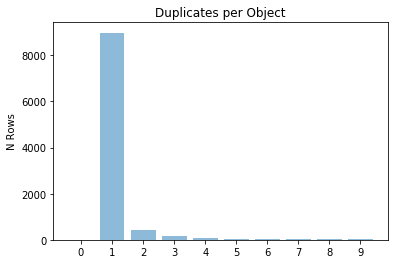

In [32]:
from collections import defaultdict 

import matplotlib.pyplot as plt;
import numpy as np
import matplotlib.pyplot as plt

buckets = defaultdict(int)
for n_dup in dups_distribution:
    buckets[n_dup] += 1

x = np.arange(10)
y = [buckets[val] for val in x]
 
plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(x, x)
plt.ylabel('N Rows')
plt.title('Duplicates per Object')
plt.show()

### Other Numbers

#### Flter by the `relation`, then the duplicate distribution is:
- Median number of duplicates: 1.0
- Mean number of duplicates: 54.792947297427496
- Stdev number of duplicates: 260.91925676565364
- `subject_name`s with 1 duplicate: 6155 ~ 56.7%
- `subject_name`s with 9+ duplicates: 1756

#### Filter by the `relation`, then the duplicate distribution is:
- Median number of duplicates: 1.0
- Mean number of duplicates: 13.306869640620484
- Stdev number of duplicates: 86.82547513692815
- `subject_name`s with 1 duplicate: 8613 ~ 79.4%
- `subject_name`s with 9+ duplicates: 622

### Discussion

Given a algorithm is able to determine the relation, the best it can do without resorting to guessing is 82.8% accuracy.

### Freebase Mid Sample Differences

Here we take a look at the sample. We print the features that change between different duplicates.

In [86]:
import random
import pprint
import string

pp = pprint.PrettyPrinter(indent=2)

def remove_punctuation(s):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in s if ch not in exclude)

def is_subject_name_in_subject(subject_name, subject):
    subject = remove_punctuation(subject).lower().replace(' ', '')
    subject_name = remove_punctuation(subject_name).lower().replace(' ', '')
    return subject_name in subject

def weighted_gini_impurity(k):
    # Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled
    # if it was randomly labeled according to the distribution of labels in the subset. 
    total = sum(k[1].values())
    ret = 1
    for val in k[1].values():
        ret -= (val / total) ** 2
    return ret * total

for row in tqdm_notebook(dups_data):
    mids = list(row['Duplicate MIDs']) + [row['True MID']]
    subject_name = row['Subject Name']
    mids = random.sample(['<http://rdf.freebase.com/ns/m.' + mid + '>' for mid in mids], min(len(mids), 10))
    # TODO: add suject = ANY
    cursor.execute("""
        SELECT object, relation, subject
        FROM fb
        WHERE object = ANY(%s)
    """, (mids,))
    rows = cursor.fetchall()
    differences = defaultdict(set)
    for object_, relation, subject in rows:
        if ((is_subject_name_in_subject(subject_name, subject) and
            relation in ['<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage>',
                        '<http://rdf.freebase.com/ns/type.object.name>',
                        '<http://www.w3.org/2000/01/rdf-schema#label>',
                        '<http://rdf.freebase.com/key/wikipedia.en>']) 
            or 'musicbrainz.org' in subject
            or ('<http://rdf.freebase.com/ns/type.object.type>' in relation and 'common' not in subject)):
            mid = object_.replace('<http://rdf.freebase.com/ns/m.', '').rstrip('>')
            differences[relation].add(tuple([subject, mid]))
    print('\n\n--------------------------------------------\n\n')
    print('SUBJECT NAME:', subject_name)
    print('MIDs:', mids)
    print('TOTAL MIDS:', len(row['Duplicate MIDs']) + 1)
    for relation, subjects in differences.items():
        print(relation + ' → ')
        pp.pprint(sorted(list(subjects), key=lambda k: k[1]))   
        print()

HBox(children=(IntProgress(value=0, max=1395), HTML(value='')))



--------------------------------------------


SUBJECT NAME: just you , just me
MIDs: ['<http://rdf.freebase.com/ns/m.0dp76p7>', '<http://rdf.freebase.com/ns/m.0f34691>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Just You, Just Me"@en', '0dp76p7'),
  ('"Just You, Just Me"@en', '0f34691'),
  ('"Just You, Just Me"@sv', '0f34691')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0dp76p7'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0dp76p7'),
  ('<http://rdf.freebase.com/ns/music.album>', '0dp76p7'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0dp76p7'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0f34691'),
  ('<http://rdf.freebase.com/ns/music.album>', '0f34691'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0f34691'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0f34691')]

<http://rdf.freeba



--------------------------------------------


SUBJECT NAME: musician
MIDs: ['<http://rdf.freebase.com/ns/m.09jwl>', '<http://rdf.freebase.com/ns/m.0kpv1_>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/book.periodical_subject>', '09jwl'),
  ('<http://rdf.freebase.com/ns/user.journ3eb.default_domain.band>', '09jwl'),
  ('<http://rdf.freebase.com/ns/people.profession>', '09jwl'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_class>', '09jwl'),
  ('<http://rdf.freebase.com/ns/music.group_member>', '09jwl'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/business.job_title>



--------------------------------------------


SUBJECT NAME: paris
MIDs: ['<http://rdf.freebase.com/ns/m.0tqzw>', '<http://rdf.freebase.com/ns/m.0y3z6>', '<http://rdf.freebase.com/ns/m.0tcsk>', '<http://rdf.freebase.com/ns/m.01ky4n>', '<http://rdf.freebase.com/ns/m.0_vhs>', '<http://rdf.freebase.com/ns/m.0wy0z>', '<http://rdf.freebase.com/ns/m.0gfgglz>', '<http://rdf.freebase.com/ns/m.05qtj>', '<http://rdf.freebase.com/ns/m.0qvgh>', '<http://rdf.freebase.com/ns/m.0s0w4>']
TOTAL MIDS: 12
<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Paris"@fr', '01ky4n'),
  ('"Paris"@en', '01ky4n'),
  ('"Paris"@da', '05qtj'),
  ('"Paris"@tr', '05qtj'),
  ('"Paris"@pt-PT', '05qtj'),
  ('"Paris"@ro', '05qtj'),
  ('"Paris"@id', '05qtj'),
  ('"Paris"@pt', '05qtj'),
  ('"Paris"@en', '05qtj'),
  ('"Paris"@no', '05qtj'),
  ('"Paris"@sv', '05qtj'),
  ('"Paris"@fr', '05qtj'),
  ('"Paris"@fil', '05qtj'),
  ('"Paris"@de', '05qtj'),
  ('"Paris"@ms', '05qtj'),
  ('"Paris"@vi', '05qtj'),
  ('"Paris"@en', '0_

SUBJECT NAME: die in your arms
MIDs: ['<http://rdf.freebase.com/ns/m.0lw621d>', '<http://rdf.freebase.com/ns/m.0y8sch_>', '<http://rdf.freebase.com/ns/m.0rd_zc2>', '<http://rdf.freebase.com/ns/m.0kldhv8>', '<http://rdf.freebase.com/ns/m.0q8pv30>', '<http://rdf.freebase.com/ns/m.0rtqdll>', '<http://rdf.freebase.com/ns/m.0rthyy7>', '<http://rdf.freebase.com/ns/m.0q690j9>', '<http://rdf.freebase.com/ns/m.0rd_ylw>', '<http://rdf.freebase.com/ns/m.0x6f3p7>']
TOTAL MIDS: 15
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/music.release_track>', '0kldhv8'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0lw621d'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0q690j9'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0q8pv30'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0rd_ylw'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0rd_zc2'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0rthyy7'),
  ('<http

Exception in thread Thread-59:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



,
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '0td29'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '0td29'),
  ('<http://rdf.freebase.com/ns/location.citytown>', '0td29'),
  ('<http://rdf.freebase.com/ns/location.location>', '0td29'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '0td29'),
  ('<http://rdf.freebase.com/ns/location.hud_county_place>', '0td29'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0td29'),
  ('<http://rdf.freebase.com/ns/base.wikipedia_infobox.settlement>', '0td29'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0td29'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0vzff'),
  ('<http://rdf.freebase.com/ns/location.location>', '0vzff'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '0vzff'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0vzff'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '0vzff'),
  ('<http:

  ('<http://rdf.freebase.com/ns/music.single>', '0t1zmh')]

<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Tokyo"@en', '010ggk_'),
  ('"Tokyo"@en', '0f2_1kc'),
  ('"Tokyo"@en', '0f7jxvt'),
  ('"Tokyo"@en', '0f_qbnw'),
  ('"Tokyo"@en', '0frqc_j'),
  ('"Tokyo"@en', '0frx9mk'),
  ('"Tokyo"@en', '0nlj43f'),
  ('"Tokyo"@en', '0nlyvfj'),
  ('"Tokyo"@en', '0prp0m'),
  ('"Tokyo"@en', '0t1zmh')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Tokyo"@en', '010ggk_'),
  ('"Tokyo"@en', '0f2_1kc'),
  ('"Tokyo"@en', '0f7jxvt'),
  ('"Tokyo"@en', '0f_qbnw'),
  ('"Tokyo"@en', '0frqc_j'),
  ('"Tokyo"@en', '0frx9mk'),
  ('"Tokyo"@en', '0nlj43f'),
  ('"Tokyo"@en', '0nlyvfj'),
  ('"Tokyo"@en', '0prp0m'),
  ('"Tokyo"@en', '0t1zmh')]

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ( '<http://musicbrainz.org/recording/743b2ad9-69b7-4a04-84c3-5c601b53b256>',
    '010ggk_'),
  ( '<http://musicbrainz.org/recording/46dd7158-f9f0-4064-9786-ac4f92248e22>',
    '0f2_1kc'),
  ( '



--------------------------------------------


SUBJECT NAME: film producer
MIDs: ['<http://rdf.freebase.com/ns/m.0jsg3l>', '<http://rdf.freebase.com/ns/m.01d_h8>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/music.music_video_job>', '01d_h8'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.character_occupation>',
    '01d_h8'),
  ('<http://rdf.freebase.com/ns/award.award_discipline>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/people.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/book.book_subject>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.tagit.concept>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.cinemainspectortest.topic>', '01d



--------------------------------------------


SUBJECT NAME: california
MIDs: ['<http://rdf.freebase.com/ns/m.0wxz5>', '<http://rdf.freebase.com/ns/m.0_frm>', '<http://rdf.freebase.com/ns/m.0tx8x>', '<http://rdf.freebase.com/ns/m.01n7q>']
TOTAL MIDS: 4
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/organization.organization_scope>', '01n7q'),
  ('<http://rdf.freebase.com/ns/user.skud.legal.topic>', '01n7q'),
  ( '<http://rdf.freebase.com/ns/user.robert.default_domain.states_i_ve_been_to>',
    '01n7q'),
  ('<http://rdf.freebase.com/ns/location.us_state>', '01n7q'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '01n7q'),
  ('<http://rdf.freebase.com/ns/base.biblioness.bibs_location>', '01n7q'),
  ( '<http://rdf.freebase.com/ns/government.governmental_jurisdiction>',
    '01n7q'),
  ('<http://rdf.freebase.com/ns/symbols.flag_referent>', '01n7q'),
  ('<http://rdf.freebase.com/ns/base.popstra.location>', '01n7q'),
  ('<http://rdf.freeba



--------------------------------------------


SUBJECT NAME: los angeles
MIDs: ['<http://rdf.freebase.com/ns/m.030qb3t>', '<http://rdf.freebase.com/ns/m.0w833ld>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.popstra.sww_base>', '030qb3t'),
  ('<http://rdf.freebase.com/ns/olympics.olympic_host_city>', '030qb3t'),
  ('<http://rdf.freebase.com/ns/location.hud_county_place>', '030qb3t'),
  ( '<http://rdf.freebase.com/ns/user.narphorium.default_domain.base_equivalent_location>',
    '030qb3t'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '030qb3t'),
  ('<http://rdf.freebase.com/ns/olympics.olympic_bidding_city>', '030qb3t'),
  ('<http://rdf.freebase.com/ns/base.popstra.topic>', '030qb3t'),
  ('<http://rdf.freebase.com/ns/base.arthist.helynevek>', '030qb3t'),
  ('<http://rdf.freebase.com/ns/location.location>', '030qb3t'),
  ('<http://rdf.freebase.com/ns/base.popstra.business_location>', '030qb3t'),
  ('<http://rdf.

  ('<http://id.wikipedia.org/wiki/Amos>', '04_1ss'),
  ('<http://et.wikipedia.org/wiki/Aamos>', '04_1ss'),
  ('<http://nl.wikipedia.org/wiki/Amos_(profeet)>', '04_1ss'),
  ('<http://sl.wikipedia.org/wiki/Amos_(prerok)>', '04_1ss'),
  ('<http://it.wikipedia.org/wiki/Amos_(Bibbia)>', '04_1ss'),
  ('<http://fr.wikipedia.org/wiki/Amos_(proph%E8te)>', '04_1ss'),
  ('<http://sk.wikipedia.org/wiki/Amos_(prorok)>', '04_1ss'),
  ('<http://fi.wikipedia.org/wiki/Aamos>', '04_1ss'),
  ('<http://en.wikipedia.org/wiki/Amos_(prophet)>', '04_1ss'),
  ('<http://lt.wikipedia.org/wiki/Amosas>', '04_1ss')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/computer.programming_language>', '012gr'),
  ('<http://rdf.freebase.com/ns/base.fblinux.topic>', '012gr'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '012gr'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '012gr'),
  ('<http://rdf.freebase.com/ns/religion.religious_leader>', '04_1ss')



--------------------------------------------


SUBJECT NAME: film director
MIDs: ['<http://rdf.freebase.com/ns/m.02jknp>', '<http://rdf.freebase.com/ns/m.0jsg3d>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ( '<http://rdf.freebase.com/ns/user.alust.default_domain.processed_with_review_queue>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/education.field_of_study>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.bollywooddiary.topic>', '02jknp'),
  ('<http://rdf.freebase.com/ns/organization.role>', '02jknp'),
  ( '<http://rdf.freebase.com/ns/user.micahsaul.advertising.advertising_role>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/base.webvideo.topic>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '02jknp'),
  ( '<http://rdf.freebase.com/ns/base.webvideo.internet_video_crew_role>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '02jknp'),



--------------------------------------------


SUBJECT NAME: aquamarine
MIDs: ['<http://rdf.freebase.com/ns/m.0q9gm57>', '<http://rdf.freebase.com/ns/m.0f0j0yk>', '<http://rdf.freebase.com/ns/m.0nmd66g>', '<http://rdf.freebase.com/ns/m.0xhtgjv>', '<http://rdf.freebase.com/ns/m.0v9w23>', '<http://rdf.freebase.com/ns/m.0tw3z2>', '<http://rdf.freebase.com/ns/m.019sz9w>', '<http://rdf.freebase.com/ns/m.024j7wd>', '<http://rdf.freebase.com/ns/m.0nlwhp3>', '<http://rdf.freebase.com/ns/m.015csh9>']
TOTAL MIDS: 42
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/music.single>', '015csh9'),
  ('<http://rdf.freebase.com/ns/music.recording>', '015csh9'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '015csh9'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '015csh9'),
  ('<http://rdf.freebase.com/ns/music.recording>', '019sz9w'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '019sz9w'),
  ('<http://rdf.freebase

  ('<http://www.movli.com/movie/the-dark-hour-130968>', '040559q'),
  ('<http://en.wikipedia.org/wiki/The_Dark_Hour_(1936_film)>', '076v6_w'),
  ( '<http://www.clicker.com/movie/the-dark-hour-1936-remastered-edition>',
    '076v6_w'),
  ('<http://www.movli.com/movie/the-dark-hour-114385>', '076v6_w'),
  ('<http://www.ranker.com/review/the-dark-hour/22416892>', '076v6_w')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[('"The Dark Hour"@en', '040559q'), ('"The Dark Hour"@en', '076v6_w')]

<http://rdf.freebase.com/ns/type.object.name> → 
[('"The Dark Hour"@en', '040559q'), ('"The Dark Hour"@en', '076v6_w')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/film.film>', '040559q'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '040559q'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '040559q'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '040559q'),
  ('<http://rdf.freebase.com/ns/base.type_ontology



--------------------------------------------


SUBJECT NAME: santa maria
MIDs: ['<http://rdf.freebase.com/ns/m.027srtp>', '<http://rdf.freebase.com/ns/m.050s2b>', '<http://rdf.freebase.com/ns/m.0487_lb>', '<http://rdf.freebase.com/ns/m.06dd21>', '<http://rdf.freebase.com/ns/m.048t4bj>', '<http://rdf.freebase.com/ns/m.0r639>']
TOTAL MIDS: 6
<http://rdf.freebase.com/key/wikipedia.en> → 
[ ('"Santa_Maria_$0028Building$0029"', '027srtp'),
  ('"Santa_Maria$0028Building$0029"', '027srtp'),
  ('"Santa_Maria_$0028building$0029"', '027srtp'),
  ('"Santa_Maria$002C_Rio_Grande_do_Sul"', '050s2b'),
  ('"Santa_Maria_$0028Rio_Grande_do_Sul$0029"', '050s2b'),
  ('"Santa_Maria_$0028Brazil$0029"', '050s2b'),
  ('"Santa_Maria$002C_RS"', '050s2b'),
  ('"Santa_Maria_$0028RS$0029"', '050s2b'),
  ('"Santa_Maria$002C_Philippines"', '06dd21'),
  ('"Santa_Maria$002C_Bulacan"', '06dd21'),
  ('"Santa_Maria$002C_CA"', '0r639'),
  ('"Santa_Maria$002C_California"', '0r639'),
  ('"Santa_Maria$002C_Ca"', '0r639'),


  ('<http://rdf.freebase.com/ns/amusement_parks.ride>', '027y_qz'),
  ('<http://rdf.freebase.com/ns/amusement_parks.ride>', '0h_jb2d')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Toy Story Midway Mania"@de', '027y_qz'),
  ('"Toy Story Midway Mania!"@nl', '027y_qz'),
  ('"Toy Story Midway Mania!"@en', '027y_qz'),
  ('"Toy Story Midway Mania"@fr', '027y_qz'),
  ('"Toy Story Midway Mania!"@en', '0h_jb2d')]



--------------------------------------------


SUBJECT NAME: radiation
MIDs: ['<http://rdf.freebase.com/ns/m.010q73z>', '<http://rdf.freebase.com/ns/m.0fvs_hg>', '<http://rdf.freebase.com/ns/m.0frr67l>', '<http://rdf.freebase.com/ns/m.0dn_3nd>', '<http://rdf.freebase.com/ns/m.0fsyb0b>', '<http://rdf.freebase.com/ns/m.0fz1k1n>', '<http://rdf.freebase.com/ns/m.0fv6nq4>', '<http://rdf.freebase.com/ns/m.0l5fnq>', '<http://rdf.freebase.com/ns/m.0qh6cqy>', '<http://rdf.freebase.com/ns/m.0f98nk6>']
TOTAL MIDS: 59
<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Radiation"@en'



--------------------------------------------


SUBJECT NAME: photography
MIDs: ['<http://rdf.freebase.com/ns/m.09q5cb>', '<http://rdf.freebase.com/ns/m.05wkw>']
TOTAL MIDS: 2
<http://rdf.freebase.com/key/wikipedia.en> → 
[ ('"Photography_business"', '05wkw'),
  ('"Yachting_photography"', '05wkw'),
  ('"Photography_techniques"', '05wkw'),
  ('"Photography_as_an_art_form"', '05wkw'),
  ('"Technology_of_Photography"', '05wkw'),
  ('"Photography$002C_History_of"', '05wkw'),
  ('"Photography"', '05wkw'),
  ('"Digital_photography"', '09q5cb'),
  ('"Electronic_still_photography"', '09q5cb'),
  ('"Digital_Photography"', '09q5cb')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/exhibitions.exhibition_subject>', '05wkw'),
  ( '<http://rdf.freebase.com/ns/user.digitalarchivist.default_domain.optical_science>',
    '05wkw'),
  ( '<http://rdf.freebase.com/ns/user.micahsaul.advertising.advertised_thing>',
    '05wkw'),
  ('<http://rdf.freebase.com/ns/base.vancouv



--------------------------------------------


SUBJECT NAME: chesterfield
MIDs: ['<http://rdf.freebase.com/ns/m.0vc76>', '<http://rdf.freebase.com/ns/m.0133ch>', '<http://rdf.freebase.com/ns/m.04c3cdl>', '<http://rdf.freebase.com/ns/m.0_l4g>', '<http://rdf.freebase.com/ns/m.0sl1h>', '<http://rdf.freebase.com/ns/m.0498qpr>', '<http://rdf.freebase.com/ns/m.048qm3q>', '<http://rdf.freebase.com/ns/m.0xj4p>', '<http://rdf.freebase.com/ns/m.0xf3n>', '<http://rdf.freebase.com/ns/m.0sbzs>']
TOTAL MIDS: 11
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Chesterfield"@es-419', '0133ch'),
  ('"Chesterfield"@no', '0133ch'),
  ('"Chesterfield"@es', '0133ch'),
  ('"Chesterfield"@pl', '0133ch'),
  ('"Chesterfield"@de', '0133ch'),
  ('"Chesterfield"@ro', '0133ch'),
  ('"Chesterfield, Derbyshire"@sv', '0133ch'),
  ('"Chesterfield"@it', '0133ch'),
  ('"Chesterfield"@ca', '0133ch'),
  ('"Chesterfield"@nl', '0133ch'),
  ('"Chesterfield"@hu', '0133ch'),
  ('"Chesterfield"@fr', '0133ch'),
  ('"Chest

    '0xp0ss')]

<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Hollywood"@en', '015b6bx'),
  ('"Hollywood"@en', '01c7twy'),
  ('"Hollywood"@en', '024kgsf'),
  ('"Hollywood"@en', '0dnlydc'),
  ('"Hollywood"@en', '0f_l5t4'),
  ('"Hollywood"@en', '0f_ry3j'),
  ('"Hollywood"@en', '0ftq56h'),
  ('"Hollywood"@en', '0xffz8'),
  ('"Hollywood"@en', '0xjb1b'),
  ('"Hollywood"@en', '0xp0ss')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Hollywood"@en', '015b6bx'),
  ('"Hollywood"@en', '01c7twy'),
  ('"Hollywood"@en', '024kgsf'),
  ('"Hollywood"@en', '0dnlydc'),
  ('"Hollywood"@en', '0f_l5t4'),
  ('"Hollywood"@en', '0f_ry3j'),
  ('"Hollywood"@en', '0ftq56h'),
  ('"Hollywood"@en', '0xffz8'),
  ('"Hollywood"@en', '0xjb1b'),
  ('"Hollywood"@en', '0xp0ss')]



--------------------------------------------


SUBJECT NAME: kirksville
MIDs: ['<http://rdf.freebase.com/ns/m.03m4568>', '<http://rdf.freebase.com/ns/m.0ws6b>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"



--------------------------------------------


SUBJECT NAME: history
MIDs: ['<http://rdf.freebase.com/ns/m.03g3w>', '<http://rdf.freebase.com/ns/m.075nhcb>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.nobelprizes.topic>', '03g3w'),
  ('<http://rdf.freebase.com/ns/base.academia.topic>', '03g3w'),
  ('<http://rdf.freebase.com/ns/tv.tv_genre>', '03g3w'),
  ('<http://rdf.freebase.com/ns/base.artshumanitiesresources.topic>', '03g3w'),
  ('<http://rdf.freebase.com/ns/radio.radio_subject>', '03g3w'),
  ('<http://rdf.freebase.com/ns/book.magazine_genre>', '03g3w'),
  ( '<http://rdf.freebase.com/ns/user.gregtyrelle.default_domain.academic_discipline>',
    '03g3w'),
  ('<http://rdf.freebase.com/ns/base.chicago.topic>', '03g3w'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_instance>', '03g3w'),
  ('<http://rdf.freebase.com/ns/broadcast.genre>', '03g3w'),
  ('<http://rdf.freebase.com/ns/organization.organization_sector>', '03



--------------------------------------------


SUBJECT NAME: georgia
MIDs: ['<http://rdf.freebase.com/ns/m.03hnq4s>', '<http://rdf.freebase.com/ns/m.0492mhd>', '<http://rdf.freebase.com/ns/m.0d0x8>', '<http://rdf.freebase.com/ns/m.04by6vx>', '<http://rdf.freebase.com/ns/m.04843d9>', '<http://rdf.freebase.com/ns/m.04964h0>', '<http://rdf.freebase.com/ns/m.0d0kn>', '<http://rdf.freebase.com/ns/m.010jl7>']
TOTAL MIDS: 8
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '010jl7'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '010jl7'),
  ('<http://rdf.freebase.com/ns/base.vermont.topic>', '010jl7'),
  ('<http://rdf.freebase.com/ns/location.location>', '010jl7'),
  ('<http://rdf.freebase.com/ns/organization.organization_scope>', '010jl7'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '010jl7'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '010jl7'),
  ('<http://rdf.freebase.com



--------------------------------------------


SUBJECT NAME: o holy night
MIDs: ['<http://rdf.freebase.com/ns/m.0f1dj5g>', '<http://rdf.freebase.com/ns/m.0dm98vw>', '<http://rdf.freebase.com/ns/m.0dqd39h>', '<http://rdf.freebase.com/ns/m.0dq0z1j>', '<http://rdf.freebase.com/ns/m.0fvhk38>', '<http://rdf.freebase.com/ns/m.0g224bm>', '<http://rdf.freebase.com/ns/m.0dtp5fd>', '<http://rdf.freebase.com/ns/m.0fylclv>', '<http://rdf.freebase.com/ns/m.01779wj>', '<http://rdf.freebase.com/ns/m.017rtvp>']
TOTAL MIDS: 817
<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ( '<http://musicbrainz.org/recording/f6b8a399-c049-4e41-8b12-a8fa35f70fa7>',
    '01779wj'),
  ( '<http://musicbrainz.org/recording/83907e49-670e-4f4f-86b8-f1e0ee8dbf53>',
    '01779wj'),
  ( '<http://musicbrainz.org/recording/8868e604-5dd2-4135-9187-35c1f431c0dc>',
    '017rtvp'),
  ( '<http://musicbrainz.org/recording/2509ae31-cdc5-42e0-a483-e07554843042>',
    '017rtvp'),
  ( '<http://musicbrainz.org/re



--------------------------------------------


SUBJECT NAME: musician
MIDs: ['<http://rdf.freebase.com/ns/m.0kpv1_>', '<http://rdf.freebase.com/ns/m.09jwl>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/book.periodical_subject>', '09jwl'),
  ('<http://rdf.freebase.com/ns/user.journ3eb.default_domain.band>', '09jwl'),
  ('<http://rdf.freebase.com/ns/people.profession>', '09jwl'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_class>', '09jwl'),
  ('<http://rdf.freebase.com/ns/music.group_member>', '09jwl'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/business.job_title>



--------------------------------------------


SUBJECT NAME: dublin
MIDs: ['<http://rdf.freebase.com/ns/m.0ydcn>', '<http://rdf.freebase.com/ns/m.02cft>', '<http://rdf.freebase.com/ns/m.010nrs>', '<http://rdf.freebase.com/ns/m.0rxp_>', '<http://rdf.freebase.com/ns/m.013jm1>', '<http://rdf.freebase.com/ns/m.0xf3_>', '<http://rdf.freebase.com/ns/m.01xd9>']
TOTAL MIDS: 7
<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ('<http://pt.wikipedia.org/wiki/Dublin_(Virg%EDnia)>', '010nrs'),
  ('<http://nl.wikipedia.org/wiki/Dublin_(Virginia)>', '010nrs'),
  ('<http://de.wikipedia.org/wiki/Dublin_(Virginia)>', '010nrs'),
  ('<http://pl.wikipedia.org/wiki/Dublin_(Wirginia)>', '010nrs'),
  ('<http://es.wikipedia.org/wiki/Dublin_(Virginia)>', '010nrs'),
  ('<http://en.wikipedia.org/wiki/Dublin,_Virginia>', '010nrs'),
  ('<http://ca.wikipedia.org/wiki/Dublin_(Virg%EDnia)>', '010nrs'),
  ('<http://sv.wikipedia.org/wiki/Dublin,_Ohio>', '013jm1'),
  ('<http://de.wikipedia.org/wi

  ('"Radio"@en', '01l68yp'),
  ('"Radio"@pt', '01l68yp'),
  ('"Radio"@ru', '01l68yp'),
  ('"Radio"@fr', '01l68yp'),
  ('"Radio"@pl', '01l68yp'),
  ('"Radio"@de', '027qnv6'),
  ('"Radio"@en', '027qnv6'),
  ('"Radio"@ru', '02ptvc6'),
  ('"Radio"@fr', '02ptvc6'),
  ('"Radio"@cs', '02ptvc6'),
  ('"Radio"@en', '02ptvc6'),
  ('"Radio"@en', '0c9nhw'),
  ('"Radio"@hi', '0hjb5zg'),
  ('"Radio"@en', '0hjb5zg')]



--------------------------------------------


SUBJECT NAME: wilson
MIDs: ['<http://rdf.freebase.com/ns/m.011gw8>', '<http://rdf.freebase.com/ns/m.01121c>', '<http://rdf.freebase.com/ns/m.01153k>', '<http://rdf.freebase.com/ns/m.0qvxp>', '<http://rdf.freebase.com/ns/m.0t6q6>', '<http://rdf.freebase.com/ns/m.01126k>', '<http://rdf.freebase.com/ns/m.01196s>', '<http://rdf.freebase.com/ns/m.011b6s>']
TOTAL MIDS: 8
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Wilson"@es', '01121c'),
  ('"Wilson"@pl', '01121c'),
  ('"Wilson, Quận Dunn, Wisconsin"@vi', '01121c'),
  ('"Wilson"@en', '

  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '011qvc_'),
  ('<http://rdf.freebase.com/ns/music.recording>', '011qvc_'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0nlmhdh'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0nlmhdh'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0nlmhdh'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0wqvg4'),
  ('<http://rdf.freebase.com/ns/music.single>', '0wqvg4'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0wqvg4'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0wqvg4'),
  ('<http://rdf.freebase.com/ns/music.single>', '0z48mz9'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0z48mz9'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0z48mz9'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0z48mz9')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Cayman Islands"@en', '011qvc_'),
  ('"Cayman Islan



--------------------------------------------


SUBJECT NAME: the brothers grimm
MIDs: ['<http://rdf.freebase.com/ns/m.0bjsc>', '<http://rdf.freebase.com/ns/m.0bjsw>', '<http://rdf.freebase.com/ns/m.046nx>']
TOTAL MIDS: 3
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/people.deceased_person>', '046nx'),
  ('<http://rdf.freebase.com/ns/people.person>', '046nx'),
  ('<http://rdf.freebase.com/ns/music.artist>', '046nx'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.person_in_fiction>',
    '046nx'),
  ('<http://rdf.freebase.com/ns/book.author>', '046nx'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '046nx'),
  ('<http://rdf.freebase.com/ns/music.group_member>', '046nx'),
  ('<http://rdf.freebase.com/ns/film.writer>', '046nx'),
  ('<http://rdf.freebase.com/ns/base.collectives.collective_member>', '046nx'),
  ('<http://rdf.freebase.com/ns/base.fairytales.fairy_tale_author>', '046nx'),
  ('<http://rdf.freebase.com/ns/base.type_ontolog



--------------------------------------------


SUBJECT NAME: pop music
MIDs: ['<http://rdf.freebase.com/ns/m.05r9t>', '<http://rdf.freebase.com/ns/m.064t9>', '<http://rdf.freebase.com/ns/m.0ncl8vt>']
TOTAL MIDS: 3
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.skosbase.topic>', '05r9t'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '05r9t'),
  ('<http://rdf.freebase.com/ns/education.field_of_study>', '05r9t'),
  ('<http://rdf.freebase.com/ns/music.compositional_form>', '05r9t'),
  ( '<http://rdf.freebase.com/ns/base.skosbase.vocabulary_equivalent_topic>',
    '05r9t'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '05r9t'),
  ('<http://rdf.freebase.com/ns/music.genre>', '05r9t'),
  ( '<http://rdf.freebase.com/ns/base.schemastaging.music_genre_concept>',
    '064t9'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '064t9'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_instance>', '0



--------------------------------------------


SUBJECT NAME: evolution
MIDs: ['<http://rdf.freebase.com/ns/m.03fmsty>', '<http://rdf.freebase.com/ns/m.03j8395>', '<http://rdf.freebase.com/ns/m.0gbjprd>', '<http://rdf.freebase.com/ns/m.03j6sky>', '<http://rdf.freebase.com/ns/m.0f041_z>', '<http://rdf.freebase.com/ns/m.02468n3>', '<http://rdf.freebase.com/ns/m.0f5b1fh>', '<http://rdf.freebase.com/ns/m.0fvnymp>', '<http://rdf.freebase.com/ns/m.0f8gjcm>', '<http://rdf.freebase.com/ns/m.0f7t3m4>']
TOTAL MIDS: 59
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/music.release>', '02468n3'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '02468n3'),
  ('<http://rdf.freebase.com/ns/business.consumer_product>', '02468n3'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '02468n3'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '02468n3'),
  ('<http://rdf.freebase.com/ns/music.release>', '03fms



--------------------------------------------


SUBJECT NAME: washington county
MIDs: ['<http://rdf.freebase.com/ns/m.0n3kv>', '<http://rdf.freebase.com/ns/m.0nn_r>', '<http://rdf.freebase.com/ns/m.0nr8r>', '<http://rdf.freebase.com/ns/m.0mptn>', '<http://rdf.freebase.com/ns/m.0kzt3>', '<http://rdf.freebase.com/ns/m.0d22f>', '<http://rdf.freebase.com/ns/m.0mw54>', '<http://rdf.freebase.com/ns/m.0nfvn>', '<http://rdf.freebase.com/ns/m.0ngy8>', '<http://rdf.freebase.com/ns/m.0ndcv>']
TOTAL MIDS: 28
<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ('<http://de.wikipedia.org/wiki/Washington_County_(Oregon)>', '0d22f'),
  ('<http://en.wikipedia.org/wiki/Washington_County,_Oregon>', '0d22f'),
  ('<http://no.wikipedia.org/wiki/Washington_County_(Oregon)>', '0d22f'),
  ('<http://cs.wikipedia.org/wiki/Washington_County_(Oregon)>', '0d22f'),
  ('<http://nl.wikipedia.org/wiki/Washington_County_(Oregon)>', '0d22f'),
  ('<http://sv.wikipedia.org/wiki/Washington_County,_Orego



--------------------------------------------


SUBJECT NAME: journalist
MIDs: ['<http://rdf.freebase.com/ns/m.01xryvt>', '<http://rdf.freebase.com/ns/m.0d8qb>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Journalist"@en-GB', '0d8qb'),
  ('"Journalist"@da', '0d8qb'),
  ('"Journalist"@no', '0d8qb'),
  ('"Journalist"@en', '0d8qb'),
  ('"Journaliste"@fr', '0d8qb'),
  ('"Journalist"@nl', '0d8qb'),
  ('"Journalist"@de', '0d8qb'),
  ('"Journalist"@sv', '0d8qb')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/freebase.type_profile>', '01xryvt'),
  ('<http://rdf.freebase.com/ns/type.type>', '01xryvt'),
  ('<http://rdf.freebase.com/ns/base.allthingsnewyork.topic>', '0d8qb'),
  ( '<http://rdf.freebase.com/ns/base.dictionaryofoccupationaltitles.occupation>',
    '0d8qb'),
  ('<http://rdf.freebase.com/ns/base.galalelsoury.topic>', '0d8qb'),
  ('<http://rdf.freebase.com/ns/tv.tv_subject>', '0d8qb'),
  ( '<http://rdf.freebase.com/ns/fiction

[ ('<http://nl.wikipedia.org/wiki/Clayton_(Kansas)>', '013cv_'),
  ('<http://ca.wikipedia.org/wiki/Clayton_(Kansas)>', '013cv_'),
  ('<http://pl.wikipedia.org/wiki/Clayton_(Kansas)>', '013cv_'),
  ('<http://pt.wikipedia.org/wiki/Clayton_(Kansas)>', '013cv_'),
  ('<http://en.wikipedia.org/wiki/Clayton,_Kansas>', '013cv_'),
  ('<http://vi.wikipedia.org/wiki/Clayton,_Kansas>', '013cv_'),
  ('<http://es.wikipedia.org/wiki/Clayton_(Kansas)>', '013cv_'),
  ('<http://fr.wikipedia.org/wiki/Clayton_(Oklahoma)>', '0z9nz'),
  ('<http://es.wikipedia.org/wiki/Clayton_(Oklahoma)>', '0z9nz'),
  ('<http://pt.wikipedia.org/wiki/Clayton_(Oklahoma)>', '0z9nz'),
  ('<http://en.wikipedia.org/wiki/Clayton,_Oklahoma>', '0z9nz'),
  ('<http://ca.wikipedia.org/wiki/Clayton_(Oklahoma)>', '0z9nz'),
  ('<http://pl.wikipedia.org/wiki/Clayton_(Oklahoma)>', '0z9nz'),
  ('<http://nl.wikipedia.org/wiki/Clayton_(Oklahoma)>', '0z9nz')]

<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Clayton"@es', '013cv_'),
  ('"C

  ( '<http://musicbrainz.org/recording/3891ef8d-6de9-4b40-b9de-c36f813c16d4>',
    '0rb62b'),
  ( '<http://musicbrainz.org/recording/ed87eeb6-be8b-4da0-a0b7-f7e6530398b1>',
    '0rb62b'),
  ( '<http://musicbrainz.org/recording/219290b6-b6da-48fb-ae4e-a8df33094c0e>',
    '0rb62b'),
  ( '<http://musicbrainz.org/recording/92823fbd-0b1f-42d2-aab4-19f331114522>',
    '0rb62b'),
  ( '<http://musicbrainz.org/recording/d6c4c2ab-f0fa-4d65-a3c6-71fa1f448dde>',
    '0rb62b'),
  ( '<http://musicbrainz.org/recording/e3e31f7c-403e-4e8d-b44a-e841547539fc>',
    '0rb62b'),
  ( '<http://musicbrainz.org/recording/3a32118f-2c50-4f45-9f88-7e5975df2fc7>',
    '0v6fy_'),
  ( '<http://musicbrainz.org/recording/c3f12cbb-80fa-46d8-9eec-9ddc5ea690ad>',
    '0yfjv_'),
  ( '<http://musicbrainz.org/recording/20362163-df79-4d88-ae90-e9d70577c293>',
    '0yfjv_'),
  ( '<http://musicbrainz.org/recording/931de405-91b6-479d-9eaa-fc7404cb5dbd>',
    '0yfjv_'),
  ( '<http://musicbrainz.org/recording/729b9b85-815f-48be-ac



--------------------------------------------


SUBJECT NAME: actor
MIDs: ['<http://rdf.freebase.com/ns/m.0274hl>', '<http://rdf.freebase.com/ns/m.0t5z30n>', '<http://rdf.freebase.com/ns/m.0lhyq3n>', '<http://rdf.freebase.com/ns/m.0rg_6rq>', '<http://rdf.freebase.com/ns/m.0s92n6k>', '<http://rdf.freebase.com/ns/m.0t5b4qz>', '<http://rdf.freebase.com/ns/m.0vpctlb>', '<http://rdf.freebase.com/ns/m.0t5b2mj>', '<http://rdf.freebase.com/ns/m.0v1xlx8>', '<http://rdf.freebase.com/ns/m.02hrh1q>']
TOTAL MIDS: 19
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Actor"@en', '0274hl'),
  ('"Actor"@es', '0274hl'),
  ('"Actor"@en-GB', '02hrh1q'),
  ('"Actor"@pt-PT', '02hrh1q'),
  ('"Actor"@gl', '02hrh1q'),
  ('"Actor"@ca', '02hrh1q'),
  ('"Actor"@en', '02hrh1q'),
  ('"Actor"@ro', '02hrh1q'),
  ('"Actor"@es-419', '02hrh1q'),
  ('"Actor"@es', '02hrh1q'),
  ('"Actor"@en', '0lhyq3n'),
  ('"actor"@en', '0rg_6rq'),
  ('"actor"@en', '0s92n6k'),
  ('"Actor"@en', '0t5b2mj'),
  ('"Actor"@en', '0t5b4qz')



--------------------------------------------


SUBJECT NAME: new york
MIDs: ['<http://rdf.freebase.com/ns/m.02_286>', '<http://rdf.freebase.com/ns/m.059rby>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.petbreeds.city_with_dogs>', '02_286'),
  ('<http://rdf.freebase.com/ns/film.film_subject>', '02_286'),
  ('<http://rdf.freebase.com/ns/base.aubreymaturin.place>', '02_286'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '02_286'),
  ('<http://rdf.freebase.com/ns/film.film_location>', '02_286'),
  ('<http://rdf.freebase.com/ns/base.militaryinfiction.topic>', '02_286'),
  ('<http://rdf.freebase.com/ns/sports.sports_team_location>', '02_286'),
  ( '<http://rdf.freebase.com/ns/user.joehughes.default_domain.transit_service_area>',
    '02_286'),
  ( '<http://rdf.freebase.com/ns/base.jewishcommunities.jewish_community>',
    '02_286'),
  ('<http://rdf.freebase.com/ns/base.popstra.topic>', '02_286'),
  ('<http://rdf.freeba

  ('"Washington"@es', '011cbw'),
  ('"Washington"@ca', '081yw'),
  ('"Washington"@en', '081yw'),
  ('"Washington"@sv', '081yw'),
  ('"Washington"@fr', '081yw'),
  ('"Washington"@sk', '081yw'),
  ('"Washingtoni osariik"@et', '081yw'),
  ('"Washington"@no', '081yw'),
  ('"Washington"@es', '081yw'),
  ('"Washington"@hr', '081yw'),
  ('"Washington"@hu', '081yw'),
  ('"Washington"@it', '081yw'),
  ('"Washington"@id', '081yw'),
  ('"Washington"@da', '081yw'),
  ('"Washington"@sl', '081yw'),
  ('"Washington"@de', '081yw'),
  ('"Washington"@ms', '081yw'),
  ('"Washington"@pt', '081yw'),
  ('"Washington"@ro', '081yw'),
  ('"Washington"@nl', '081yw'),
  ('"Washington"@fi', '081yw'),
  ('"Washington"@cs', '081yw'),
  ('"Washington"@vi', '081yw'),
  ('"Washington"@fil', '081yw'),
  ('"Washington"@pl', '0tqlf'),
  ('"Washington"@ca', '0tqlf'),
  ('"Washington"@en', '0tqlf'),
  ('"Washington"@es', '0tqlf'),
  ('"Washington"@it', '0wvld'),
  ('"Washington"@nl', '0wvld'),
  ('"Washington"@de', '0wvld'

  ('<http://rdf.freebase.com/ns/base.argentina.topic>', '0dbmmz'),
  ('<http://rdf.freebase.com/ns/location.citytown>', '0dbmmz'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0dbmmz'),
  ('<http://rdf.freebase.com/ns/location.location>', '0dbmmz')]

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ('<http://tr.wikipedia.org/wiki/San_Francisco>', '0d6lp'),
  ('<http://sk.wikipedia.org/wiki/San_Francisco>', '0d6lp'),
  ('<http://it.wikipedia.org/wiki/San_Francisco>', '0d6lp'),
  ('<http://fi.wikipedia.org/wiki/San_Francisco>', '0d6lp'),
  ('<http://no.wikipedia.org/wiki/San_Francisco>', '0d6lp'),
  ('<http://ca.wikipedia.org/wiki/San_Francisco>', '0d6lp'),
  ('<http://tl.wikipedia.org/wiki/San_Francisco,_California>', '0d6lp'),
  ('<http://da.wikipedia.org/wiki/San_Francisco>', '0d6lp'),
  ('<http://nl.wikipedia.org/wiki/San_Francisco>', '0d6lp'),
  ('<http://ms.wikipedia.org/wiki/San_Francisco>', '0d6lp'),
  ('<http://de.wikipedia.org/wiki/San

  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '0z2yy'),
  ('<http://rdf.freebase.com/ns/location.hud_foreclosure_area>', '0z2yy'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '0z2yy')]

<http://rdf.freebase.com/key/wikipedia.en> → 
[ ('"Franklin$002C_Robertson_County$002C_Texas"', '01084n'),
  ('"Franklin$002C_Texas"', '01084n'),
  ('"Franklin$002C_TX"', '01084n'),
  ('"Franklin$002C_Jackson_County$002C_WI"', '0113m5'),
  ('"Franklin$002C_Jackson_County$002C_Wisconsin"', '0113m5'),
  ('"Franklin$002C_Milwaukee_County$002C_WI"', '021kmb9'),
  ('"Franklin$002C_Milwaukee_County$002C_Wi"', '021kmb9'),
  ('"Franklin$002C_Milwaukee_County$002C_Wisconsin"', '021kmb9'),
  ('"Franklin_borough$002C_Pennsylvania"', '02pbc90'),
  ('"Franklin$002C_Cambria_County$002C_Pennsylvania"', '02pbc90'),
  ('"Franklin_Borough$002C_Pennsylvania"', '02pbc90'),
  ('"Franklin_borough$002C_Cambria_County$002C_Pennsylvania"', '02pbc90'),
  ('"Franklin$002C_Cambria_County$002C_PA"', '02

[ ('<http://rdf.freebase.com/ns/music.release_track>', '0_f7n_g'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0lb30lz'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0lh9wtt'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0lljkbb'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0m0h858'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0m_z_pp'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0mlvxqj'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0mqcr85'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0ntj7dj'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0wtq1dh')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Fever"@en', '0_f7n_g'),
  ('"Fever"@en', '0lb30lz'),
  ('"Fever"@en', '0lh9wtt'),
  ('"Fever"@en', '0lljkbb'),
  ('"Fever"@en', '0m0h858'),
  ('"Fever"@en', '0m_z_pp'),
  ('"Fever"@en', '0mlvxqj'),
  ('"Fever"@en', '0mqcr85'),
  ('"Fever"@en', '0ntj7dj'),
  ('"Fever"@en', '0w

    '0ld8k6'),
  ( '<http://musicbrainz.org/recording/f2f0d649-df07-48f1-95db-7aecb7538c34>',
    '0ld8k6'),
  ( '<http://musicbrainz.org/recording/c2a7f7ad-c0fb-4197-aaaf-f3ce0d4ccc5f>',
    '0ld8k6'),
  ( '<http://musicbrainz.org/recording/f9f524fd-2b00-4fa5-9323-9efbca8911ae>',
    '0ld8k6'),
  ( '<http://musicbrainz.org/recording/c3b4b387-e59e-41f8-a786-e7632c60f0ce>',
    '0ld8k6'),
  ( '<http://musicbrainz.org/recording/6ca1b927-4075-4034-acb3-ba9f63e0d235>',
    '0ld8k6'),
  ( '<http://musicbrainz.org/recording/a22fd59f-4072-44cd-8fab-a9b1386f81db>',
    '0ld8k6'),
  ( '<http://musicbrainz.org/recording/3fdc803a-b9bf-41e6-9f1b-45fa9442f5e4>',
    '0ld8k6'),
  ( '<http://musicbrainz.org/recording/7b475186-3f35-4bba-a931-bcee45f13f65>',
    '0ld8k6'),
  ( '<http://musicbrainz.org/recording/b1248c58-2ba6-427e-8ceb-581c31247d28>',
    '0ld8k6'),
  ( '<http://musicbrainz.org/recording/a2275af6-0772-4ae0-ab39-157ef8fa7b7a>',
    '0ld8k6'),
  ( '<http://musicbrainz.org/recording/a1eec2

  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0crx1vs'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0crx1vs'),
  ('<http://rdf.freebase.com/ns/film.film>', '0crx1vs'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0crx1vs'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0crxkcz'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0crxkcz'),
  ('<http://rdf.freebase.com/ns/film.film>', '0crxkcz'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0crxkcz'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0g9tx58'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0g9tx58'),
  ('<http://rdf.freebase.com/ns/film.film>', '0g9tx58'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0g9tx58'),
  ('<http://rdf.freebase.com/ns/award.award_nominated_work>', '0n7w2z0'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0n7w2z0'),

  ('<http://rdf.freebase.com/ns/base.biblioness.bibs_location>', '0f0z_'),
  ('<http://rdf.freebase.com/ns/location.location>', '0f0z_'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '0f0z_'),
  ('<http://rdf.freebase.com/ns/location.hud_county_place>', '0f0z_'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0f0z_'),
  ('<http://rdf.freebase.com/ns/base.lewisandclark.topic>', '0f0z_'),
  ('<http://rdf.freebase.com/ns/base.lewisandclark.places_eastward>', '0f0z_'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '0f0z_'),
  ( '<http://rdf.freebase.com/ns/periodicals.newspaper_circulation_area>',
    '0f0z_'),
  ('<http://rdf.freebase.com/ns/sports.sports_team_location>', '0f0z_'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '0f0z_'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0f0z_'),
  ('<http://rdf.freebase.com/ns/base.wikipedia_infobox.settlement>', '0f0z_'),
  ( '<http://rdf.freebase.com/ns/location

  ('<http://fi.wikipedia.org/wiki/Birmingham_(Alabama)>', '0lphb'),
  ('<http://tl.wikipedia.org/wiki/Birmingham,_Alabama>', '0lphb'),
  ('<http://ro.wikipedia.org/wiki/Birmingham,_Alabama>', '0lphb'),
  ('<http://no.wikipedia.org/wiki/Birmingham_(Alabama)>', '0lphb'),
  ('<http://nl.wikipedia.org/wiki/Birmingham_(Alabama)>', '0lphb'),
  ('<http://da.wikipedia.org/wiki/Birmingham_(Alabama)>', '0lphb'),
  ('<http://www.ranker.com/review/birmingham/588823>', '0lphb'),
  ('<http://hr.wikipedia.org/wiki/Birmingham,_Alabama>', '0lphb'),
  ('<http://en.wikipedia.org/wiki/Birmingham,_Alabama>', '0lphb'),
  ('<http://fr.wikipedia.org/wiki/Birmingham_(Alabama)>', '0lphb'),
  ('<http://id.wikipedia.org/wiki/Birmingham,_Alabama>', '0lphb'),
  ('<http://no.wikipedia.org/wiki/Birmingham_(Michigan)>', '0vg8j'),
  ('<http://it.wikipedia.org/wiki/Birmingham_(Michigan)>', '0vg8j'),
  ('<http://pt.wikipedia.org/wiki/Birmingham_(Michigan)>', '0vg8j'),
  ('<http://fr.wikipedia.org/wiki/Birmingham_(Michiga

  ('"Burlington"@pt', '0hpyv'),
  ('"Burlington"@no', '0hpyv'),
  ('"Burlington, Vermont"@id', '0hpyv'),
  ('"Burlington"@tr', '0hpyv'),
  ('"Burlington, Vermont"@sv', '0hpyv'),
  ('"Burlington"@es', '0hpyv'),
  ('"Burlington"@nl', '0hpyv'),
  ('"Burlington"@fi', '0hpyv'),
  ('"Burlington, Vermont"@vi', '0hpyv'),
  ('"Burlington"@de', '0hpyv'),
  ('"Burlington"@ca', '0hpyv'),
  ('"Burlington"@it', '0hpyv'),
  ('"Burlington"@cs', '0hpyv'),
  ('"Burlington, Vermont"@fil', '0hpyv'),
  ('"Burlington"@da', '0hpyv'),
  ('"Burlington"@pl', '0hpyv'),
  ('"Burlington, Iowa"@sv', '0sv6n'),
  ('"Burlington"@pt', '0sv6n'),
  ('"Burlington"@it', '0sv6n'),
  ('"Burlington"@de', '0sv6n'),
  ('"Burlington"@ca', '0sv6n'),
  ('"Burlington"@nl', '0sv6n'),
  ('"Burlington"@fr', '0sv6n'),
  ('"Burlington"@es', '0sv6n'),
  ('"Burlington"@pl', '0sv6n'),
  ('"Burlington, Iowa"@vi', '0sv6n'),
  ('"Burlington"@en', '0sv6n')]



--------------------------------------------


SUBJECT NAME: bewitched
MIDs: ['<http

  ( '<http://rdf.freebase.com/ns/base.aareas.schema.administrative_area>',
    '0rgvf'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '0rgvf'),
  ('<http://rdf.freebase.com/ns/sports.sports_team_location>', '0rgvf'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0rgvf'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '0rgvf'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '0yzny'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '0yzny'),
  ('<http://rdf.freebase.com/ns/location.citytown>', '0yzny'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0yzny'),
  ('<http://rdf.freebase.com/ns/base.biblioness.bibs_location>', '0yzny'),
  ('<http://rdf.freebase.com/ns/location.location>', '0yzny'),
  ( '<http://rdf.freebase.com/ns/periodicals.newspaper_circulation_area>',
    '0yzny'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '0yzny'),
  ('<http://rdf.freebase.com/ns/base.biblione



--------------------------------------------


SUBJECT NAME: film director
MIDs: ['<http://rdf.freebase.com/ns/m.02jknp>', '<http://rdf.freebase.com/ns/m.0jsg3d>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ( '<http://rdf.freebase.com/ns/user.alust.default_domain.processed_with_review_queue>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/education.field_of_study>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.bollywooddiary.topic>', '02jknp'),
  ('<http://rdf.freebase.com/ns/organization.role>', '02jknp'),
  ( '<http://rdf.freebase.com/ns/user.micahsaul.advertising.advertising_role>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/base.webvideo.topic>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '02jknp'),
  ( '<http://rdf.freebase.com/ns/base.webvideo.internet_video_crew_role>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '02jknp'),

  ('"All Good Things (Come to an End)"@cs', '0l0qbp'),
  ('"All Good Things (Come to an End)"@hr', '0l0qbp'),
  ('"All Good Things (Come to an End)"@pt', '0l0qbp'),
  ('"All Good Things (Come to an End)"@it', '0l0qbp'),
  ('"All Good Things (Come to an End)"@ro', '0l0qbp'),
  ('"All Good Things"@fr', '0l0qbp'),
  ('"All Good Things (Come to an End)"@de', '0l0qbp'),
  ('"All Good Things (Come to an End)"@lt', '0l0qbp'),
  ('"All Good Things (Come to an End)"@nl', '0l0qbp'),
  ('"All Good Things (Come to an End)"@pl', '0l0qbp'),
  ('"All Good Things (Come to an End)"@sv', '0l0qbp'),
  ('"All Good Things (Come to an End)"@es', '0l0qbp'),
  ('"All Good Things (Come to an End)"@en', '0l0qbp'),
  ('"All Good Things (Come to an End)"@uk', '0l0qbp'),
  ('"All Good Things (Come to an End)"@tr', '0l0qbp'),
  ('"All Good Things (Come to an End)"@no', '0l0qbp'),
  ('"All Good Things"@ca', '0l0qbp'),
  ('"All Good Things (Come to an End)"@hu', '0l0qbp'),
  ('"All Good Things (Come to an End)"@ru', 

[ ('"Face to Face - Fever"@en', '031kz04'),
  ('"Face to Face - Fever"@en', '0f46y_t')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/music.release>', '031kz04'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '031kz04'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0f46y_t'),
  ('<http://rdf.freebase.com/ns/music.release>', '0f46y_t')]

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ( '<http://musicbrainz.org/release/99f5992c-7a57-42c1-8285-b554461cacdd>',
    '031kz04'),
  ( '<http://musicbrainz.org/release/7aa1ac13-e72c-3148-b57e-c587d8ce18f1>',
    '0f46y_t')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Face to Face - Fever"@en', '031kz04'),
  ('"Face to Face - Fever"@en', '0f46y_t')]



--------------------------------------------


SUBJECT NAME: faithful
MIDs: ['<http://rdf.freebase.com/ns/m.04f0n00>', '<http://rdf.freebase.com/ns/m.01jfspv>']
TOTAL MIDS: 2
<http://rdf.free

    '02k2rl'),
  ('"Canton$002C_NY"', '02k2rl'),
  ('"Canton$002C_St$002E_Lawrence_County"', '02k2rl'),
  ('"Canton$002C_New_York"', '02k2rl'),
  ('"Canton_$0028New_York$0029"', '02k2rl'),
  ('"Canton_City$002C_China"', '0393g'),
  ('"Canton$002C_Canton"', '0393g'),
  ('"Canton_$0028city$0029$002C_China"', '0393g'),
  ('"Canton$002C_Canton$002C_China"', '0393g'),
  ('"Guangzhou$0028Canton$0029"', '0393g'),
  ('"Canton_$0028Guangzhou$0029"', '0393g'),
  ('"Canton$002C_China"', '0393g'),
  ('"Canton$002C_SD"', '0_r5v'),
  ('"Canton$002C_South_Dakota"', '0_r5v'),
  ('"Canton_$0028GA$0029"', '0rt_x'),
  ('"Canton$002C_Georgia"', '0rt_x'),
  ('"Canton$002C_GA"', '0rt_x'),
  ('"Canton$002C_KS"', '0t8l4'),
  ('"Canton$002C_Kansas"', '0t8l4'),
  ('"Canton_$0028MA$0029"', '0t_cb'),
  ('"Canton$002C_Ma"', '0t_cb'),
  ('"Canton$002C_Massachusetts"', '0t_cb'),
  ('"Canton$002C_MA"', '0t_cb'),
  ('"Canton_Public_Library_$0028Massachusetts$0029"', '0t_cb'),
  ('"Canton$002C_Mass"', '0t_cb'),
  ('"Ca

    '01lfp03'),
  ( '<http://musicbrainz.org/release/c4883f15-33a5-470b-b54a-7bf8db39b450>',
    '01lfp0x'),
  ( '<http://musicbrainz.org/release/4aff7b6b-1e31-4f28-8737-08445036fdbc>',
    '01lfp0x'),
  ( '<http://musicbrainz.org/release/29317476-5420-39e0-bb46-4c075ecc82e7>',
    '0fck5xg')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Argus"@en', '01lfp03'),
  ('"Argus"@en', '01lfp0x'),
  ('"Argus"@en', '0fck5xg')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '01lfp03'),
  ('<http://rdf.freebase.com/ns/music.release>', '01lfp03'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '01lfp03'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '01lfp03'),
  ('<http://rdf.freebase.com/ns/business.consumer_product>', '01lfp03'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '01lfp0x'),
  ('<http://rdf.freebase.com/ns/base.type_o

  ( '<http://musicbrainz.org/recording/427b1a75-1a4c-4360-ba35-043c9fe4355d>',
    '0q6yrt8'),
  ( '<http://musicbrainz.org/recording/4800ab9c-0596-45e6-bf08-719641900df4>',
    '0smm_xv'),
  ( '<http://musicbrainz.org/recording/0b2f9600-0bf4-4b59-a1ed-e95d88cbe62e>',
    '0wh5tw5'),
  ( '<http://musicbrainz.org/recording/008a4880-4766-44be-a8d9-b156bcd23e60>',
    '0wy3pd')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Mona Lisa"@en', '010c5t6'),
  ('"Mona Lisa"@en', '01cdw7h'),
  ('"Mona Lisa"@en', '01ct3h6'),
  ('"Mona Lisa"@en', '01db7mn'),
  ('"Mona Lisa"@en', '0dwzjhy'),
  ('"Mona Lisa"@en', '0fv2ch4'),
  ('"Mona Lisa"@en', '0q6yrt8'),
  ('"Mona Lisa"@en', '0smm_xv'),
  ('"Mona Lisa"@en', '0wh5tw5'),
  ('"Mona Lisa"@en', '0wy3pd')]



--------------------------------------------


SUBJECT NAME: macenta
MIDs: ['<http://rdf.freebase.com/ns/m.05dl_j>', '<http://rdf.freebase.com/ns/m.084ydp>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> →



--------------------------------------------


SUBJECT NAME: film producer
MIDs: ['<http://rdf.freebase.com/ns/m.0jsg3l>', '<http://rdf.freebase.com/ns/m.01d_h8>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/music.music_video_job>', '01d_h8'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.character_occupation>',
    '01d_h8'),
  ('<http://rdf.freebase.com/ns/award.award_discipline>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/people.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/book.book_subject>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.tagit.concept>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.cinemainspectortest.topic>', '01d

  ('<http://de.wikipedia.org/wiki/Victoria_(Australien)>', '0chgr2'),
  ('<http://id.wikipedia.org/wiki/Victoria,_Australia>', '0chgr2'),
  ('<http://da.wikipedia.org/wiki/Victoria_(delstat)>', '0chgr2'),
  ('<http://tl.wikipedia.org/wiki/Victoria>', '0chgr2'),
  ('<http://nl.wikipedia.org/wiki/Victoria_(Australi%EB)>', '0chgr2'),
  ('<http://tr.wikipedia.org/wiki/Victoria,_Avustralya>', '0chgr2'),
  ('<http://sv.wikipedia.org/wiki/Victoria,_Australien>', '0chgr2'),
  ('<http://cs.wikipedia.org/wiki/Victoria_(Austr%E1lie)>', '0chgr2'),
  ('<http://hr.wikipedia.org/wiki/Victoria_(Australija)>', '0chgr2'),
  ('<http://vi.wikipedia.org/wiki/Victoria,_Kansas>', '0t6nh'),
  ('<http://pt.wikipedia.org/wiki/Victoria_(Kansas)>', '0t6nh'),
  ('<http://pl.wikipedia.org/wiki/Victoria_(Kansas)>', '0t6nh'),
  ('<http://en.wikipedia.org/wiki/Victoria,_Kansas>', '0t6nh'),
  ('<http://nl.wikipedia.org/wiki/Victoria_(Kansas)>', '0t6nh'),
  ('<http://es.wikipedia.org/wiki/Victoria_(Kansas)>', '0t6nh'),


  ('<http://rdf.freebase.com/ns/music.recording>', '0dy583l'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0dy583l'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0dy583l'),
  ('<http://rdf.freebase.com/ns/music.single>', '0dy583l'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0f24nb0'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0f24nb0'),
  ('<http://rdf.freebase.com/ns/music.single>', '0f24nb0'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0f24nb0'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0f91pf1'),
  ('<http://rdf.freebase.com/ns/music.single>', '0f91pf1'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0f91pf1'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0f91pf1'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0fs1tv_'),
  ('<http://rdf.freebase.com/ns/music.single>', '0fs1tv_'),
  ('<http://rdf.freebase.com/ns/music.recor

  ( '<http://musicbrainz.org/recording/e6573893-eb13-47b0-adc1-b47a8a3bb1dc>',
    '0pqc56'),
  ( '<http://musicbrainz.org/recording/609cecf3-482c-4bca-92d3-ffdec3f6819a>',
    '0pqc56'),
  ( '<http://musicbrainz.org/recording/68bd7cb0-421e-4f97-b779-456d416d3c12>',
    '0qccmz1'),
  ( '<http://musicbrainz.org/recording/2b94c197-79fe-4b2c-a668-9c7d2aa169e4>',
    '0shdj_y'),
  ( '<http://musicbrainz.org/recording/30d4c110-8c78-408a-aedd-91deb9b1b28e>',
    '0sl2m7v'),
  ( '<http://musicbrainz.org/recording/73939ec3-8c8c-456b-ac9e-a03ea2044b6f>',
    '0twmzd'),
  ( '<http://musicbrainz.org/recording/e12ba9f2-b9f5-4143-81f7-67f6fc3dce36>',
    '0w8hdvm')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Red"@en', '019b5r0'),
  ('"Red"@en', '0l2wgs'),
  ('"Red"@en', '0nj54l'),
  ('"Red"@en', '0np06z9'),
  ('"Red"@en', '0pqc56'),
  ('"Red"@en', '0qccmz1'),
  ('"Red"@en', '0shdj_y'),
  ('"Red"@en', '0sl2m7v'),
  ('"Red"@en', '0twmzd'),
  ('"Red"@en', '0w8hdvm')]

<http://rdf.freebase.c

[ ( '<http://en.wikipedia.org/wiki/Fresh_Pond_(Plymouth,_Massachusetts)>',
    '02x5hcs'),
  ('<http://en.wikipedia.org/wiki/Fresh_Pond,_California>', '03ns7ff'),
  ('<http://en.wikipedia.org/wiki/Fresh_Pond,_Queens>', '043lm_s'),
  ( '<http://en.wikipedia.org/wiki/Fresh_Pond_(Cambridge,_Massachusetts)>',
    '05t17w')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Fresh Pond"@en', '02x5hcs'),
  ('"Fresh Pond"@en', '03ns7ff'),
  ('"Fresh Pond"@en', '043lm_s'),
  ('"Fresh Pond"@en', '05t17w')]



--------------------------------------------


SUBJECT NAME: the circle
MIDs: ['<http://rdf.freebase.com/ns/m.07kb1mr>', '<http://rdf.freebase.com/ns/m.01mcjb6>', '<http://rdf.freebase.com/ns/m.01mhh8v>']
TOTAL MIDS: 3
<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ( '<http://musicbrainz.org/release-group/b378e00c-bdc3-34d4-9186-c5cd4324374b>',
    '01mcjb6'),
  ('<http://en.wikipedia.org/wiki/The_Circle_(Wipers_album)>', '01mcjb6'),
  ('<http://ja.wikipedia.org

    '0144gtd'),
  ( '<http://musicbrainz.org/recording/28d0db26-beb7-4a73-bdbc-60478ccce83c>',
    '0144gtd'),
  ( '<http://musicbrainz.org/recording/33cfb2c9-483d-4de0-83cf-5f3d2d330e21>',
    '0144gtd'),
  ( '<http://musicbrainz.org/recording/1f460650-3468-4c20-8109-3e011b45cfce>',
    '0144gtd'),
  ( '<http://musicbrainz.org/recording/d43d1110-c188-4971-b0b0-61b6c4896a74>',
    '0144gtd'),
  ( '<http://musicbrainz.org/recording/52b81de1-51f3-4825-8c82-3ab027cf5870>',
    '0144gtd'),
  ( '<http://musicbrainz.org/recording/ff6192e4-092e-4388-8fd3-b6da522621e0>',
    '0144gtd'),
  ( '<http://musicbrainz.org/recording/7e76fd93-1491-456e-8e4a-d15d03496e05>',
    '0lsc7v'),
  ( '<http://musicbrainz.org/recording/d7a20d93-f1d4-4649-956d-214065d0aa69>',
    '0syz9b')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Tower of London"@en', '0144gtd'),
  ('"Tower of London"@en', '0lsc7v'),
  ('"Tower of London"@en', '0syz9b')]



--------------------------------------------


SUBJECT NAME

  ('"Melbourne"@de', '0rhp6'),
  ('"Melbourne"@fr', '0rhp6'),
  ('"Melbourne, Florida"@sv', '0rhp6'),
  ('"Melbourne"@pl', '0rhp6')]

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ('<http://en.wikipedia.org/wiki/Melbourne,_Derbyshire>', '05p4mr'),
  ('<http://no.wikipedia.org/wiki/Melbourne_(Derbyshire)>', '05p4mr'),
  ('<http://nl.wikipedia.org/wiki/Melbourne_(Derbyshire)>', '05p4mr'),
  ('<http://it.wikipedia.org/wiki/Melbourne_(Derbyshire)>', '05p4mr'),
  ('<http://pl.wikipedia.org/wiki/Melbourne_(Derbyshire)>', '05p4mr'),
  ('<http://sv.wikipedia.org/wiki/Melbourne>', '0chgzm'),
  ('<http://it.wikipedia.org/wiki/Melbourne>', '0chgzm'),
  ('<http://fi.wikipedia.org/wiki/Melbourne>', '0chgzm'),
  ('<http://en.wikipedia.org/wiki/Melbourne>', '0chgzm'),
  ('<http://cs.wikipedia.org/wiki/Melbourne>', '0chgzm'),
  ('<http://vi.wikipedia.org/wiki/Melbourne>', '0chgzm'),
  ('<http://pl.wikipedia.org/wiki/Melbourne>', '0chgzm'),
  ('<http://tl.wikipedia.org/wiki/Me



--------------------------------------------


SUBJECT NAME: film producer
MIDs: ['<http://rdf.freebase.com/ns/m.0jsg3l>', '<http://rdf.freebase.com/ns/m.01d_h8>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/music.music_video_job>', '01d_h8'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.character_occupation>',
    '01d_h8'),
  ('<http://rdf.freebase.com/ns/award.award_discipline>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/people.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/book.book_subject>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.tagit.concept>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.cinemainspectortest.topic>', '01d

  ('<http://rdf.freebase.com/ns/music.artist>', '0j3glvq'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0j3glvq')]



--------------------------------------------


SUBJECT NAME: kim richards
MIDs: ['<http://rdf.freebase.com/ns/m.0k226mc>', '<http://rdf.freebase.com/ns/m.08l257>', '<http://rdf.freebase.com/ns/m.0_mwht3>']
TOTAL MIDS: 3
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/tv.tv_personality>', '08l257'),
  ('<http://rdf.freebase.com/ns/tv.tv_actor>', '08l257'),
  ('<http://rdf.freebase.com/ns/influence.influence_node>', '08l257'),
  ('<http://rdf.freebase.com/ns/user.narphorium.people.nndb_person>', '08l257'),
  ('<http://rdf.freebase.com/ns/user.narphorium.people.topic>', '08l257'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.animate>', '08l257'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '08l257'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '08l257'),
  ('<h

<http://rdf.freebase.com/key/wikipedia.en> → 
[ ('"Mark_thompson_baseball_player"', '027vr8q'),
  ('"Mark_Thompson_$0028baseball_player$0029"', '027vr8q'),
  ('"Mark_Thompson_$0028baseball$0029"', '027vr8q'),
  ('"Mark_Thompson_$0028pitcher$0029"', '027vr8q'),
  ('"Mark_Thompson_$0028media_executive$0029"', '031g8l'),
  ('"Mark_Thompson_$0028television_executive$0029"', '031g8l'),
  ('"Mark_Thompson_$0028radio$0029"', '07j7gb'),
  ('"Mark_Thompson_$0028reporter$0029"', '097821'),
  ('"Mark_Thompson_$0028television_personality$0029"', '0pc9cf5'),
  ('"Mark_Thompson_$0028TV$0029"', '0pc9cf5'),
  ('"Mark_Thompson_$0028astronomer$0029"', '0r8mmq3')]



--------------------------------------------


SUBJECT NAME: communism
MIDs: ['<http://rdf.freebase.com/ns/m.0fqp9h7>', '<http://rdf.freebase.com/ns/m.0dv4773>', '<http://rdf.freebase.com/ns/m.019ykvq>', '<http://rdf.freebase.com/ns/m.0fvpxdk>', '<http://rdf.freebase.com/ns/m.0ftlv33>', '<http://rdf.freebase.com/ns/m.0dyp0rs>']
TOTAL MIDS: 6

  ('"Houston"@it', '0w1l2'),
  ('"Houston"@pl', '0w1l2'),
  ('"Houston"@en', '0w1l2'),
  ('"Houston"@pt', '0w1l2'),
  ('"Houston, Minnesota"@vi', '0w1l2'),
  ('"Houston"@pt', '0wpp1'),
  ('"Houston"@en', '0wpp1'),
  ('"Houston"@it', '0wpp1'),
  ('"Houston"@nl', '0wpp1'),
  ('"Houston, Mississippi"@vi', '0wpp1'),
  ('"Houston"@de', '0wpp1'),
  ('"Houston"@fr', '0wpp1'),
  ('"Houston"@pl', '0wpp1'),
  ('"Houston"@es', '0wpp1'),
  ('"Houston"@ca', '0wpp1'),
  ('"Houston"@ca', '0x0rh'),
  ('"Houston"@nl', '0x0rh'),
  ('"Houston"@pt', '0x0rh'),
  ('"Houston"@es', '0x0rh'),
  ('"Houston"@pl', '0x0rh'),
  ('"Houston"@en', '0x0rh'),
  ('"Houston"@fr', '0x0rh')]

<http://rdf.freebase.com/key/wikipedia.en> → 
[ ('"City_of_Houston"', '03l2n'),
  ('"Houston$002C_Texas$002C_U$002ES$002EA$002E"', '03l2n'),
  ('"Houston$002CTexas$002C_United_States"', '03l2n'),
  ('"Houston$002C_Texas"', '03l2n'),
  ('"City_of_Houston$002C_Texas"', '03l2n'),
  ('"Houston_city"', '03l2n'),
  ('"Houston$002C_US-TX"', '

  ('"Jazz"@da', '03_d0'),
  ('"Jazz"@fi', '03_d0'),
  ('"Jazz"@ro', '03_d0'),
  ('"Jazz"@vi', '03_d0'),
  ('"Jazz"@pt', '03_d0'),
  ('"Jazz"@cs', '03_d0'),
  ('"Jazz"@en', '05snw0b')]

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ('<http://da.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://cs.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://ro.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://tl.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://de.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://id.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://es.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://no.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://en.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://vi.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://pl.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://nl.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://fr.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://pt.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://sv.wi



--------------------------------------------


SUBJECT NAME: musician
MIDs: ['<http://rdf.freebase.com/ns/m.0kpv1_>', '<http://rdf.freebase.com/ns/m.09jwl>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/book.periodical_subject>', '09jwl'),
  ('<http://rdf.freebase.com/ns/user.journ3eb.default_domain.band>', '09jwl'),
  ('<http://rdf.freebase.com/ns/people.profession>', '09jwl'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_class>', '09jwl'),
  ('<http://rdf.freebase.com/ns/music.group_member>', '09jwl'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/business.job_title>

  ( '<http://rdf.freebase.com/ns/base.saturdaynightlive.snl_movie_spin_off>',
    '0gn2nm'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0gn2nm'),
  ('<http://rdf.freebase.com/ns/base.blackhistorymonth.topic>', '0gn2nm')]

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ('<http://pt.wikipedia.org/wiki/The_Ladies_Man>', '04fcc4'),
  ('<http://www.ranker.com/review/the-ladies-man/2202377>', '04fcc4'),
  ('<http://www.clicker.com/movie/the-ladies-man-1961>', '04fcc4'),
  ('<http://www.clicker.com/movie/the-ladies-man-2000>', '04fcc4'),
  ('<http://www.movli.com/movie/the-ladies-man-40632>', '04fcc4'),
  ('<http://en.wikipedia.org/wiki/The_Ladies_Man>', '04fcc4'),
  ('<http://www.movli.com/movie/the-ladies-man-1378>', '0gn2nm'),
  ('<http://it.wikipedia.org/wiki/The_Ladies_Man_(film_2000)>', '0gn2nm'),
  ('<http://en.wikipedia.org/wiki/The_Ladies_Man_(2000_film)>', '0gn2nm'),
  ('<http://www.ranker.com/review/the-ladies-man/2202378>', '0gn2nm'),


[ ('<http://rdf.freebase.com/ns/location.hud_foreclosure_area>', '010l94'),
  ('<http://rdf.freebase.com/ns/base.wikipedia_infobox.settlement>', '010l94'),
  ('<http://rdf.freebase.com/ns/location.hud_county_place>', '010l94'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '010l94'),
  ('<http://rdf.freebase.com/ns/location.location>', '010l94'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '010l94'),
  ('<http://rdf.freebase.com/ns/location.citytown>', '010l94'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '010l94'),
  ( '<http://rdf.freebase.com/ns/location.capital_of_administrative_division>',
    '010l94'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '010l94'),
  ( '<http://rdf.freebase.com/ns/periodicals.newspaper_circulation_area>',
    '010l94'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '010l94'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '01kt8t'),
  ( '<http://rdf.free



--------------------------------------------


SUBJECT NAME: film producer
MIDs: ['<http://rdf.freebase.com/ns/m.01d_h8>', '<http://rdf.freebase.com/ns/m.0jsg3l>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/music.music_video_job>', '01d_h8'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.character_occupation>',
    '01d_h8'),
  ('<http://rdf.freebase.com/ns/award.award_discipline>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/people.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/book.book_subject>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.tagit.concept>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.cinemainspectortest.topic>', '01d

  ('<http://en.wikipedia.org/wiki/Hours_(album)>', '01ny5gt'),
  ('<http://uk.wikipedia.org/wiki/Hours>', '01ny5gt'),
  ( '<http://musicbrainz.org/release-group/6d5b1800-9899-314a-9494-85369ef2ce1c>',
    '01ny5gt'),
  ( '<http://musicbrainz.org/release-group/823acca9-f224-3dcb-a6ef-a17df1a6e75f>',
    '01ny5gt'),
  ( '<http://en.wikipedia.org/wiki/Hours_(The_Machine_De_Ella_Project)>',
    '0sjp_gs'),
  ( '<http://musicbrainz.org/release-group/4cbcffaa-b709-4634-91b5-519ba46eb401>',
    '0sjp_gs')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Hours"@sv', '01hprsj'),
  ('"‘hours…’"@en', '01hprsj'),
  ('"\'Hours...\'"@es', '01hprsj'),
  ('"\'hours...\'"@pt', '01hprsj'),
  ('"\'hours…\'"@no', '01hprsj'),
  ('"\'hours...\'"@sk', '01hprsj'),
  ('"\'hours...\'"@fr', '01hprsj'),
  ('"‘hours…’"@ru', '01hprsj'),
  ('"\'hours...\'"@hr', '01hprsj'),
  ('"\'hours...\'"@it', '01hprsj'),
  ('"\'hours...\'"@iw', '01hprsj'),
  ('"Hours"@fr', '01ny5gt'),
  ('"Hours"@en', '01ny5gt'),
  ('"Hour



--------------------------------------------


SUBJECT NAME: film producer
MIDs: ['<http://rdf.freebase.com/ns/m.0jsg3l>', '<http://rdf.freebase.com/ns/m.01d_h8>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/music.music_video_job>', '01d_h8'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.character_occupation>',
    '01d_h8'),
  ('<http://rdf.freebase.com/ns/award.award_discipline>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/people.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/book.book_subject>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.tagit.concept>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.cinemainspectortest.topic>', '01d

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ( '<http://musicbrainz.org/release/fdb4ec09-a4d8-4dd5-bc10-843275495787>',
    '0324dyp'),
  ( '<http://musicbrainz.org/release/062dcad5-5e4e-4b9e-98f4-1be0e860c78d>',
    '0324dyp'),
  ( '<http://musicbrainz.org/release/1a0edc9a-e79f-4531-a99b-621f53d60d82>',
    '03634s_'),
  ( '<http://musicbrainz.org/release/6f111e78-9e25-4afe-ab62-25392fded7da>',
    '03634s_'),
  ( '<http://musicbrainz.org/release/66bcecab-afab-47a2-b943-64542f5feb27>',
    '0390pdh'),
  ( '<http://musicbrainz.org/release/f1430193-0836-4047-bba9-3b7cfc51ff4e>',
    '0390pdh'),
  ( '<http://musicbrainz.org/release/d79e0725-f52c-4910-9a38-e9a9ec0b5956>',
    '03j74mt'),
  ( '<http://musicbrainz.org/release/42f73da1-88d4-498f-93f6-dec50ba423f0>',
    '03j74mt'),
  ( '<http://musicbrainz.org/release/dc7c2d31-9182-4732-915c-83cfb991c5ea>',
    '03j7j0z'),
  ( '<http://musicbrainz.org/release/dd584361-24a0-44be-88c8-31c7874f2b21>',
    '0_wt8yp'),


    '0nly2d_')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0176fcn'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0176fcn'),
  ('<http://rdf.freebase.com/ns/music.single>', '0176fcn'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0176fcn'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0d_g998'),
  ('<http://rdf.freebase.com/ns/music.single>', '0d_g998'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0d_g998'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0d_g998'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0nly2d_'),
  ('<http://rdf.freebase.com/ns/music.single>', '0nly2d_'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0nly2d_'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0nly2d_')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Atlantic Ocean"@en', '0176fcn'),
  ('"Atlantic Ocean"@en',

  ( '<http://musicbrainz.org/recording/11941764-41fd-49e6-8101-53afd4bf2aca>',
    '0nl3yc_'),
  ( '<http://musicbrainz.org/recording/31ea8a5e-415c-4a61-916f-69e4d978edc3>',
    '0nljxqp'),
  ( '<http://musicbrainz.org/recording/bd4a15e6-70b5-4751-ba22-fe0b96177f9c>',
    '0q3t6d'),
  ( '<http://musicbrainz.org/recording/e4ea785a-b3ae-44e7-9034-65f001d4ee29>',
    '0qp8yb'),
  ( '<http://musicbrainz.org/recording/e32b35d6-d78f-4f9f-9a65-03ed376c6c76>',
    '0qp8yb'),
  ( '<http://musicbrainz.org/recording/7fd693cc-4aa2-41d1-ab15-397569c01d9d>',
    '0skhvrq'),
  ( '<http://musicbrainz.org/recording/1e11701d-9482-4a24-9a72-8dc98a597458>',
    '0w5z25'),
  ( '<http://musicbrainz.org/recording/a4138ab7-c6b4-4e5f-97b9-977cb8ad2208>',
    '0w5z25')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Stay"@en', '0dyfnjd'),
  ('"Stay"@en', '0gdxw22'),
  ('"Stay"@en', '0mdfdc'),
  ('"Stay"@en', '0mk8ms'),
  ('"Stay"@en', '0nl3yc_'),
  ('"Stay"@en', '0nljxqp'),
  ('"Stay"@en', '0q3t6d'),
  (



--------------------------------------------


SUBJECT NAME: virginia
MIDs: ['<http://rdf.freebase.com/ns/m.07z1m>', '<http://rdf.freebase.com/ns/m.0wj_0>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Virginia"@id', '07z1m'),
  ('"Virginia"@fi', '07z1m'),
  ('"Virginia"@es', '07z1m'),
  ('"Virginia"@vi', '07z1m'),
  ('"Virginia"@tr', '07z1m'),
  ('"Virginia"@da', '07z1m'),
  ('"Virginia"@it', '07z1m'),
  ('"Virginia"@ms', '07z1m'),
  ('"Virginia"@en', '07z1m'),
  ('"Virginia"@no', '07z1m'),
  ('"Virginia"@hu', '07z1m'),
  ('"Virginia"@de', '07z1m'),
  ('"Virginia"@fil', '07z1m'),
  ('"Virginia"@ro', '07z1m'),
  ('"Virginia"@nl', '07z1m'),
  ('"Virginia"@hr', '07z1m'),
  ('"Virginia"@et', '07z1m'),
  ('"Virginia"@sv', '07z1m'),
  ('"Virginia"@pl', '0wj_0'),
  ('"Virginia"@fi', '0wj_0'),
  ('"Virginia"@en', '0wj_0'),
  ('"Virginia"@es', '0wj_0'),
  ('"Virginia"@fr', '0wj_0'),
  ('"Virginia"@it', '0wj_0'),
  ('"Virginia"@pt', '0wj_0'),
  ('"Virginia"@nl', '0wj_0'

TOTAL MIDS: 219
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Set It Off"@en', '0lmxmvb'),
  ('"Set It Off"@en', '0lzp_m6'),
  ('"Set It Off"@en', '0m17y3x'),
  ('"Set It Off"@en', '0m52cck'),
  ('"Set It Off"@en', '0m_mpgg'),
  ('"Set It Off"@en', '0myvq52'),
  ('"Set It Off"@en', '0nrsjng'),
  ('"Set It Off"@en', '0q7fftw'),
  ('"Set It Off"@en', '0smnr4m'),
  ('"Set It Off"@en', '0xk7w40')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/music.release_track>', '0lmxmvb'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0lzp_m6'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0m17y3x'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0m52cck'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0m_mpgg'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0myvq52'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0nrsjng'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0q7fftw'),
  ('<http

    '0q3t6d'),
  ( '<http://musicbrainz.org/recording/b9e1bc90-0417-4523-bd7c-16f21f5c07c5>',
    '0srpbx3'),
  ( '<http://musicbrainz.org/recording/f3f5b8fa-4133-432b-9a8a-8dcf4625f37f>',
    '0srpbx3')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Stay"@en', '01136bs'),
  ('"Stay"@en', '015lp5l'),
  ('"Stay"@en', '01bh_tw'),
  ('"Stay"@en', '0dvfr8y'),
  ('"Stay"@en', '0dz_m2k'),
  ('"Stay"@en', '0fg9651'),
  ('"Stay"@en', '0nl3yc_'),
  ('"Stay"@en', '0nljxqp'),
  ('"Stay"@en', '0q3t6d'),
  ('"Stay"@en', '0srpbx3')]



--------------------------------------------


SUBJECT NAME: baby
MIDs: ['<http://rdf.freebase.com/ns/m.0f86x7k>', '<http://rdf.freebase.com/ns/m.01cltqh>', '<http://rdf.freebase.com/ns/m.012v2p9>', '<http://rdf.freebase.com/ns/m.0mb4t01>', '<http://rdf.freebase.com/ns/m.0fty_kg>', '<http://rdf.freebase.com/ns/m.016y8l5>', '<http://rdf.freebase.com/ns/m.01d7n_z>', '<http://rdf.freebase.com/ns/m.0fs5ghj>', '<http://rdf.freebase.com/ns/m.0p223f>', '<http://rdf.f

  ( '<http://musicbrainz.org/recording/e713bc5d-66e4-4605-b9d3-7388d0f24a41>',
    '0nnth2k'),
  ( '<http://musicbrainz.org/recording/97160b09-bb23-45f2-a997-b343ec76d305>',
    '0nnth2k'),
  ( '<http://musicbrainz.org/recording/93467f15-06c4-4cf8-bb58-28205e2f2cec>',
    '0qfq294'),
  ( '<http://musicbrainz.org/recording/8f86c7f1-436f-4f14-b172-1ae67c8bcfc2>',
    '0vbqnpv'),
  ( '<http://musicbrainz.org/recording/be8691e6-8d9d-4a61-8ba7-51fedeefbf44>',
    '0vbqnpv'),
  ( '<http://musicbrainz.org/recording/31e2cc48-8df8-427b-800c-950131b38865>',
    '0vbqnpv'),
  ( '<http://musicbrainz.org/recording/408ed77d-7ea0-4911-aa3c-dd7f98b3bdfc>',
    '0vbqnpv'),
  ( '<http://musicbrainz.org/recording/730141c9-03f7-4caf-a2f1-85f5e5c9e715>',
    '0vbqnpv'),
  ( '<http://musicbrainz.org/recording/0d86c646-bac0-4adc-a8e8-d5a729b46872>',
    '0vbqnpv'),
  ( '<http://musicbrainz.org/recording/df8ca5cf-9a60-4a35-b131-36bc4b217d7c>',
    '0x406mp'),
  ( '<http://musicbrainz.org/recording/c2f6a71e-4e

    '07gjfp'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.animate>', '07gjfp'),
  ('<http://rdf.freebase.com/ns/government.politician>', '07gjfp'),
  ('<http://rdf.freebase.com/ns/people.deceased_person>', '08pvzp'),
  ('<http://rdf.freebase.com/ns/people.person>', '08pvzp'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '08pvzp'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '08pvzp'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.animate>', '08pvzp'),
  ('<http://rdf.freebase.com/ns/music.composer>', '0chkt4'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '0chkt4'),
  ('<http://rdf.freebase.com/ns/music.group_member>', '0chkt4'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '0chkt4'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.animate>', '0chkt4'),
  ('<http://rdf.freebase.com/ns/people.person>', '0chkt4'),
  ('<http://rdf.freebase.com/ns/music.artist>', '0chk

  ('<http://no.wikipedia.org/wiki/Jefferson_County_(Alabama)>', '0kcrd'),
  ('<http://en.wikipedia.org/wiki/Jefferson_County,_Alabama>', '0kcrd'),
  ('<http://sv.wikipedia.org/wiki/Jefferson_County,_Alabama>', '0kcrd'),
  ('<http://de.wikipedia.org/wiki/Jefferson_County_(Alabama)>', '0kcrd'),
  ('<http://nl.wikipedia.org/wiki/Jefferson_County_(Wisconsin)>', '0mkwm'),
  ('<http://de.wikipedia.org/wiki/Jefferson_County_(Wisconsin)>', '0mkwm'),
  ('<http://en.wikipedia.org/wiki/Jefferson_County,_Wisconsin>', '0mkwm'),
  ('<http://no.wikipedia.org/wiki/Jefferson_County_(Wisconsin)>', '0mkwm'),
  ('<http://sv.wikipedia.org/wiki/Jefferson_County,_Wisconsin>', '0mkwm'),
  ('<http://no.wikipedia.org/wiki/Jefferson_County_(Vest-Virginia)>', '0mlnb'),
  ('<http://nl.wikipedia.org/wiki/Jefferson_County_(West_Virginia)>', '0mlnb'),
  ('<http://en.wikipedia.org/wiki/Jefferson_County,_West_Virginia>', '0mlnb'),
  ('<http://sv.wikipedia.org/wiki/Jefferson_County,_West_Virginia>', '0mlnb'),
  ('<http:



--------------------------------------------


SUBJECT NAME: history
MIDs: ['<http://rdf.freebase.com/ns/m.03g3w>', '<http://rdf.freebase.com/ns/m.075nhcb>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.nobelprizes.topic>', '03g3w'),
  ('<http://rdf.freebase.com/ns/base.academia.topic>', '03g3w'),
  ('<http://rdf.freebase.com/ns/tv.tv_genre>', '03g3w'),
  ('<http://rdf.freebase.com/ns/base.artshumanitiesresources.topic>', '03g3w'),
  ('<http://rdf.freebase.com/ns/radio.radio_subject>', '03g3w'),
  ('<http://rdf.freebase.com/ns/book.magazine_genre>', '03g3w'),
  ( '<http://rdf.freebase.com/ns/user.gregtyrelle.default_domain.academic_discipline>',
    '03g3w'),
  ('<http://rdf.freebase.com/ns/base.chicago.topic>', '03g3w'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_instance>', '03g3w'),
  ('<http://rdf.freebase.com/ns/broadcast.genre>', '03g3w'),
  ('<http://rdf.freebase.com/ns/organization.organization_sector>', '03



--------------------------------------------


SUBJECT NAME: drummer
MIDs: ['<http://rdf.freebase.com/ns/m.02hnl>', '<http://rdf.freebase.com/ns/m.09lbv>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/music.performance_role>', '02hnl'),
  ('<http://rdf.freebase.com/ns/base.skosbase.topic>', '02hnl'),
  ('<http://rdf.freebase.com/ns/music.instrument>', '02hnl'),
  ('<http://rdf.freebase.com/ns/base.schemastaging.contact_product>', '02hnl'),
  ( '<http://rdf.freebase.com/ns/user.alust.default_domain.processed_with_review_queue>',
    '02hnl'),
  ('<http://rdf.freebase.com/ns/internet.website_category>', '02hnl'),
  ( '<http://rdf.freebase.com/ns/base.skosbase.vocabulary_equivalent_topic>',
    '02hnl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '02hnl'),
  ( '<http://rdf.freebase.com/ns/user.brendan.musician_products.brand>',
    '02hnl'),
  ( '<http://rdf.freebase.com/ns/user.alust.default_domain.processed_with_re



--------------------------------------------


SUBJECT NAME: vienna
MIDs: ['<http://rdf.freebase.com/ns/m.0z2gc>', '<http://rdf.freebase.com/ns/m.010m9b>', '<http://rdf.freebase.com/ns/m.0wxpy>', '<http://rdf.freebase.com/ns/m.0fhp9>', '<http://rdf.freebase.com/ns/m.0tvh_>', '<http://rdf.freebase.com/ns/m.0s8zj>', '<http://rdf.freebase.com/ns/m.010z5_>', '<http://rdf.freebase.com/ns/m.0tldb>', '<http://rdf.freebase.com/ns/m.0tqc0>', '<http://rdf.freebase.com/ns/m.0rw2k>']
TOTAL MIDS: 10
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '010m9b'),
  ('<http://rdf.freebase.com/ns/organization.organization_scope>', '010m9b'),
  ('<http://rdf.freebase.com/ns/location.location>', '010m9b'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '010m9b'),
  ('<http://rdf.freebase.com/ns/location.hud_foreclosure_area>', '010m9b'),
  ('<http://rdf.freebase.com/ns/business.employer>', '010m9b'),
  ('<http://rdf.freebase.c

[ ('<http://rdf.freebase.com/ns/music.single>', '016xhsk'),
  ('<http://rdf.freebase.com/ns/music.recording>', '016xhsk'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '016xhsk'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '016xhsk'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0w9y4j'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0w9y4j'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0w9y4j'),
  ('<http://rdf.freebase.com/ns/music.single>', '0w9y4j'),
  ('<http://rdf.freebase.com/ns/award.award_nominated_work>', '0w9y4j'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0y_kdx'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0y_kdx'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0y_kdx')]

<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Thunder Road"@en', '016xhsk'),
  ('"Thunder Road"@fi', '0w9y4j'),
  ('"Thunder Road"@en', '0w9y4j'),
  ('"Thunder Roa

  ('<http://rdf.freebase.com/ns/music.recording>', '0fs_76k'),
  ('<http://rdf.freebase.com/ns/award.award_nominated_work>', '0fs_76k'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0fs_76k'),
  ('<http://rdf.freebase.com/ns/music.single>', '0fs_76k'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0fs_76k'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0swl72'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0swl72'),
  ('<http://rdf.freebase.com/ns/music.single>', '0swl72'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0swl72'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0z5k4m'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0z5k4m'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0z5k4m')]

<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Telephone"@en', '015x3kx'),
  ('"Telephone"@en', '02485n7'),
  ('"Telephone"@en', '0_33qb'),
  ('"Telephone"@en', '0

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ( '<http://musicbrainz.org/release/30cf9d61-df3a-47d7-9c17-d1591c111a78>',
    '0398th0'),
  ( '<http://musicbrainz.org/release/3d88eb52-5f28-4232-aeb6-8e73417a5732>',
    '03_g90d'),
  ( '<http://musicbrainz.org/release/313092d1-bee3-4f78-91c9-6819ed1afd01>',
    '03_g90d')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[('"Bloodline EP"@en', '0398th0'), ('"Bloodline EP"@en', '03_g90d')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/music.release>', '0398th0'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0398th0'),
  ('<http://rdf.freebase.com/ns/music.release>', '03_g90d'),
  ('<http://rdf.freebase.com/ns/music.multipart_release>', '03_g90d'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '03_g90d')]



--------------------------------------------


SUBJECT NAME: jordan
MIDs: ['<http://rdf.freebase.com/ns/m.0whgb>', '<http://rdf.freebas



--------------------------------------------


SUBJECT NAME: film producer
MIDs: ['<http://rdf.freebase.com/ns/m.0jsg3l>', '<http://rdf.freebase.com/ns/m.01d_h8>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/music.music_video_job>', '01d_h8'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.character_occupation>',
    '01d_h8'),
  ('<http://rdf.freebase.com/ns/award.award_discipline>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/people.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/book.book_subject>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.tagit.concept>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.cinemainspectortest.topic>', '01d



--------------------------------------------


SUBJECT NAME: new york
MIDs: ['<http://rdf.freebase.com/ns/m.0r9kl17>', '<http://rdf.freebase.com/ns/m.02_286>', '<http://rdf.freebase.com/ns/m.059rby>']
TOTAL MIDS: 3
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.petbreeds.city_with_dogs>', '02_286'),
  ('<http://rdf.freebase.com/ns/film.film_subject>', '02_286'),
  ('<http://rdf.freebase.com/ns/base.aubreymaturin.place>', '02_286'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '02_286'),
  ('<http://rdf.freebase.com/ns/film.film_location>', '02_286'),
  ('<http://rdf.freebase.com/ns/base.militaryinfiction.topic>', '02_286'),
  ('<http://rdf.freebase.com/ns/sports.sports_team_location>', '02_286'),
  ( '<http://rdf.freebase.com/ns/user.joehughes.default_domain.transit_service_area>',
    '02_286'),
  ( '<http://rdf.freebase.com/ns/base.jewishcommunities.jewish_community>',
    '02_286'),
  ('<http://rdf.freebase.com/ns/base.popstra.



--------------------------------------------


SUBJECT NAME: film director
MIDs: ['<http://rdf.freebase.com/ns/m.02jknp>', '<http://rdf.freebase.com/ns/m.0jsg3d>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ( '<http://rdf.freebase.com/ns/user.alust.default_domain.processed_with_review_queue>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/education.field_of_study>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.bollywooddiary.topic>', '02jknp'),
  ('<http://rdf.freebase.com/ns/organization.role>', '02jknp'),
  ( '<http://rdf.freebase.com/ns/user.micahsaul.advertising.advertising_role>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/base.webvideo.topic>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '02jknp'),
  ( '<http://rdf.freebase.com/ns/base.webvideo.internet_video_crew_role>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '02jknp'),

[ ('"Fall"@en', '014djc4'),
  ('"Fall"@en', '016cmbf'),
  ('"Fall"@en', '016mc0g'),
  ('"Fall"@en', '0f7z0tx'),
  ('"Fall"@en', '0mphjd'),
  ('"Fall"@en', '0mrq33'),
  ('"Fall"@en', '0p_lpd'),
  ('"Fall"@en', '0r_rfl'),
  ('"Fall"@en', '0sdhcp'),
  ('"Fall"@en', '0z771g')]

<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Fall"@en', '014djc4'),
  ('"Fall"@en', '016cmbf'),
  ('"Fall"@en', '016mc0g'),
  ('"Fall"@en', '0f7z0tx'),
  ('"Fall"@en', '0mphjd'),
  ('"Fall"@en', '0mrq33'),
  ('"Fall"@en', '0p_lpd'),
  ('"Fall"@en', '0r_rfl'),
  ('"Fall"@en', '0sdhcp'),
  ('"Fall"@en', '0z771g')]



--------------------------------------------


SUBJECT NAME: mike kelley
MIDs: ['<http://rdf.freebase.com/ns/m.04f2w38>', '<http://rdf.freebase.com/ns/m.04ls_g>']
TOTAL MIDS: 2
<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Mike Kelley"@fr', '04f2w38'),
  ('"Mike Kelley"@sv', '04f2w38'),
  ('"Mike Kelley"@fi', '04f2w38'),
  ('"Mike Kelley"@en', '04f2w38'),
  ('"Mike Kelley"@nl', '04ls_g'),




--------------------------------------------


SUBJECT NAME: pop music
MIDs: ['<http://rdf.freebase.com/ns/m.05r9t>', '<http://rdf.freebase.com/ns/m.064t9>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.skosbase.topic>', '05r9t'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '05r9t'),
  ('<http://rdf.freebase.com/ns/education.field_of_study>', '05r9t'),
  ('<http://rdf.freebase.com/ns/music.compositional_form>', '05r9t'),
  ( '<http://rdf.freebase.com/ns/base.skosbase.vocabulary_equivalent_topic>',
    '05r9t'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '05r9t'),
  ('<http://rdf.freebase.com/ns/music.genre>', '05r9t'),
  ( '<http://rdf.freebase.com/ns/base.schemastaging.music_genre_concept>',
    '064t9'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '064t9'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_instance>', '064t9'),
  ('<http://rdf.freebase.com/ns/mu



--------------------------------------------


SUBJECT NAME: washington
MIDs: ['<http://rdf.freebase.com/ns/m.0xkbk>', '<http://rdf.freebase.com/ns/m.0wvld>', '<http://rdf.freebase.com/ns/m.0xtfz>', '<http://rdf.freebase.com/ns/m.0rp7293>', '<http://rdf.freebase.com/ns/m.010h5m>', '<http://rdf.freebase.com/ns/m.0tyj_>', '<http://rdf.freebase.com/ns/m.0rh6k>', '<http://rdf.freebase.com/ns/m.0yd75>', '<http://rdf.freebase.com/ns/m.06dtwq>', '<http://rdf.freebase.com/ns/m.0shfd>']
TOTAL MIDS: 16
<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ('<http://fr.wikipedia.org/wiki/Washington_(Utah)>', '010h5m'),
  ('<http://ca.wikipedia.org/wiki/Washington_(Utah)>', '010h5m'),
  ('<http://pl.wikipedia.org/wiki/Washington_(Utah)>', '010h5m'),
  ('<http://nl.wikipedia.org/wiki/Washington_(Utah)>', '010h5m'),
  ('<http://en.wikipedia.org/wiki/Washington,_Utah>', '010h5m'),
  ('<http://it.wikipedia.org/wiki/Washington_(Utah)>', '010h5m'),
  ('<http://cs.wikipedia.org/wiki/W

  ('"Remember Me"@en', '0sn3wss'),
  ('"Remember Me"@en', '0wcyl7j')]



--------------------------------------------


SUBJECT NAME: phoenix
MIDs: ['<http://rdf.freebase.com/ns/m.0xjvmnh>', '<http://rdf.freebase.com/ns/m.0qcrbcj>', '<http://rdf.freebase.com/ns/m.0l30xmz>', '<http://rdf.freebase.com/ns/m.0mn8mj0>', '<http://rdf.freebase.com/ns/m.0lg9rf2>', '<http://rdf.freebase.com/ns/m.0lkwdg5>', '<http://rdf.freebase.com/ns/m.0ld42qm>', '<http://rdf.freebase.com/ns/m.0nt89kc>', '<http://rdf.freebase.com/ns/m.0qj_rvb>', '<http://rdf.freebase.com/ns/m.0mvv8m4>']
TOTAL MIDS: 387
<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Phoenix"@ro', '0l30xmz'),
  ('"Phoenix"@en', '0l30xmz'),
  ('"Phoenix"@en', '0ld42qm'),
  ('"Phoenix"@en', '0lg9rf2'),
  ('"Phoenix"@en', '0lkwdg5'),
  ('"Phoenix"@en', '0mn8mj0'),
  ('"Phoenix"@en', '0mvv8m4'),
  ('"Phoenix"@en', '0nt89kc'),
  ('"Phoenix"@en', '0qcrbcj'),
  ('"Phoenix"@en', '0qj_rvb'),
  ('"Phoenix"@en', '0xjvmnh')]

<http://rdf.freebase.com/



--------------------------------------------


SUBJECT NAME: film producer
MIDs: ['<http://rdf.freebase.com/ns/m.0jsg3l>', '<http://rdf.freebase.com/ns/m.01d_h8>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/music.music_video_job>', '01d_h8'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.character_occupation>',
    '01d_h8'),
  ('<http://rdf.freebase.com/ns/award.award_discipline>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/people.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/book.book_subject>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.tagit.concept>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.cinemainspectortest.topic>', '01d



--------------------------------------------


SUBJECT NAME: remembrance
MIDs: ['<http://rdf.freebase.com/ns/m.04j20vj>', '<http://rdf.freebase.com/ns/m.0gm5sw0>', '<http://rdf.freebase.com/ns/m.0h32gdq>']
TOTAL MIDS: 3
<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ('<http://www.movli.com/movie/remembrance-17180>', '04j20vj'),
  ('<http://www.movli.com/movie/remembrance-219148>', '0gm5sw0'),
  ('<http://www.movli.com/movie/remembrance-364181>', '0h32gdq'),
  ('<http://en.wikipedia.org/wiki/Remembrance_(2011_film)>', '0h32gdq')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '04j20vj'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '04j20vj'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '04j20vj'),
  ('<http://rdf.freebase.com/ns/film.film>', '04j20vj'),
  ('<http://rdf.freebase.com/ns/award.award_nominated_work>', '0gm5sw0'),
  ('<http://rdf.freebase.com/n

  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '09nvnxm'),
  ('<http://rdf.freebase.com/ns/tv.tv_character>', '09nvnxm'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '09nvnxm'),
  ('<http://rdf.freebase.com/ns/music.single>', '0drcy4t'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0drcy4t'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0drcy4t'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0drcy4t'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0fwbknw'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0fwbknw'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0fwbknw'),
  ('<http://rdf.freebase.com/ns/people.person>', '0hm_6vd'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '0hm_6vd'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '0hm_6vd'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.animate>', '0hm_6vd

  ('<http://rdf.freebase.com/ns/location.statistical_region>', '0w89d'),
  ('<http://rdf.freebase.com/ns/base.wikipedia_infobox.settlement>', '0w89d'),
  ('<http://rdf.freebase.com/ns/location.hud_foreclosure_area>', '0w89d'),
  ('<http://rdf.freebase.com/ns/location.location>', '0w89d'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '0w89d'),
  ('<http://rdf.freebase.com/ns/location.hud_county_place>', '0w89d'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0w89d'),
  ('<http://rdf.freebase.com/ns/location.citytown>', '0w89d'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '0y6mp'),
  ('<http://rdf.freebase.com/ns/location.citytown>', '0y6mp'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '0y6mp'),
  ('<http://rdf.freebase.com/ns/location.location>', '0y6mp'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0y6mp'),
  ('<http://rdf.freebase.com/ns/base.wikipedia_infobox.settlement>', '0y6mp'),
  ('<http://r



--------------------------------------------


SUBJECT NAME: athens
MIDs: ['<http://rdf.freebase.com/ns/m.0tk4_>', '<http://rdf.freebase.com/ns/m.047npq5>', '<http://rdf.freebase.com/ns/m.0j6gj>', '<http://rdf.freebase.com/ns/m.0_w0h>', '<http://rdf.freebase.com/ns/m.05fc_b>', '<http://rdf.freebase.com/ns/m.019k6n>', '<http://rdf.freebase.com/ns/m.0n2z>', '<http://rdf.freebase.com/ns/m.010305>', '<http://rdf.freebase.com/ns/m.0q8rs>', '<http://rdf.freebase.com/ns/m.01mcm1>']
TOTAL MIDS: 14
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Athens, Texas"@vi', '010305'),
  ('"Athens"@en', '010305'),
  ('"Athens"@no', '010305'),
  ('"Athens"@hr', '010305'),
  ('"Athens"@nl', '010305'),
  ('"Athens"@it', '010305'),
  ('"Athens"@fr', '010305'),
  ('"Athens"@pt', '010305'),
  ('"Athens"@ca', '010305'),
  ('"Athens"@es', '010305'),
  ('"Athens"@fi', '010305'),
  ('"Athens, Texas"@sv', '010305'),
  ('"Athens"@de', '010305'),
  ('"Athens"@pl', '010305'),
  ('"Athens"@fi', '019k6n'),
  ('"

  ('"Richmond"@de', '0179q0'),
  ('"Richmond"@pl', '0179q0'),
  ('"Richmond"@it', '0179q0'),
  ('"Richmond, British Columbia"@sv', '0179q0'),
  ('"Richmond"@ro', '0179q0'),
  ('"Richmond, British Columbia"@fil', '0179q0'),
  ('"Richmond, British Columbia"@id', '0179q0'),
  ('"Richmond"@pt', '0179q0'),
  ('"Richmond"@fr', '0179q0'),
  ('"Richmond"@fi', '0179q0'),
  ('"Richmond"@eo', '0179q0'),
  ('"Richmond"@es', '0179q0'),
  ('"Richmond"@nl', '0179q0'),
  ('"Richmond, Britanska Kolumbija"@hr', '0179q0'),
  ('"Richmond"@cs', '0179q0'),
  ('"Richmond, London"@sv', '01dzq6'),
  ('"Richmond upon Thames"@it', '01dzq6'),
  ('"Richmond upon Thames"@hu', '01dzq6'),
  ('"Richmond, London"@en', '01dzq6'),
  ('"Richmond"@es', '01dzq6'),
  ('"Richmond"@de', '01dzq6'),
  ('"Richmond"@pl', '01dzq6'),
  ('"Richmond upon Thames"@no', '01dzq6'),
  ('"Richmond"@fr', '01dzq6'),
  ('"Richmond"@fr', '02wfgv'),
  ('"Richmond"@sl', '02wfgv'),
  ('"Richmond"@en', '02wfgv'),
  ('"Richmond"@no', '02wfgv'),
  ('



--------------------------------------------


SUBJECT NAME: jazz
MIDs: ['<http://rdf.freebase.com/ns/m.03_d0>', '<http://rdf.freebase.com/ns/m.05snw0b>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Jazz"@it', '03_d0'),
  ('"Jazz"@sl', '03_d0'),
  ('"Jazz"@ca', '03_d0'),
  ('"Jazz"@es', '03_d0'),
  ('"Jazz"@da', '03_d0'),
  ('"Jazz"@no', '03_d0'),
  ('"Jazz"@nl', '03_d0'),
  ('"Jazz"@cs', '03_d0'),
  ('"Jazz"@fr', '03_d0'),
  ('"Jazz"@fil', '03_d0'),
  ('"Jazz"@pl', '03_d0'),
  ('"Jazz"@en', '03_d0'),
  ('"Jazz"@fi', '03_d0'),
  ('"Jazz"@de', '03_d0'),
  ('"Jazz"@vi', '03_d0'),
  ('"Jazz"@id', '03_d0'),
  ('"Jazz"@pt', '03_d0'),
  ('"Jazz"@ro', '03_d0'),
  ('"Jazz"@sv', '03_d0'),
  ('"Jazz"@en', '05snw0b')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ( '<http://rdf.freebase.com/ns/base.skosbase.vocabulary_equivalent_topic>',
    '03_d0'),
  ('<http://rdf.freebase.com/ns/music.genre>', '03_d0'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanima

    '0kcq0'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0kcq0'),
  ('<http://rdf.freebase.com/ns/book.book_subject>', '0kcq0'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.fictional_setting>',
    '0kcq0'),
  ('<http://rdf.freebase.com/ns/base.exoplanetology.topic>', '0kcq0'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0sqhsx0'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0sqhsx0'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0sqhsx0'),
  ('<http://rdf.freebase.com/ns/music.single>', '0sqhsx0'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0x_98jk'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0x_98jk'),
  ('<http://rdf.freebase.com/ns/music.single>', '0x_98jk'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0x_98jk'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0zhgjz2'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0zh

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Victoria"@es', '010bdw'),
  ('"Victoria"@pt', '010bdw'),
  ('"Victoria"@de', '010bdw'),
  ('"Victoria, Texas"@vi', '010bdw'),
  ('"Victoria"@hr', '010bdw'),
  ('"Victoria"@ca', '010bdw'),
  ('"Victoria"@it', '010bdw'),
  ('"Victoria, Texas"@sv', '010bdw'),
  ('"Victoria"@en', '010bdw'),
  ('"Victoria"@sk', '010bdw'),
  ('"Victoria"@nl', '010bdw'),
  ('"Victoria"@fr', '010bdw'),
  ('"Victoria"@pl', '010bdw'),
  ('"Victoria"@da', '010bdw'),
  ('"Victoria"@ca', '010n5x'),
  ('"Victoria"@es', '010n5x'),
  ('"Victoria"@pt', '010n5x'),
  ('"Victoria"@nl', '010n5x'),
  ('"Victoria"@en', '010n5x'),
  ('"Victoria"@pl', '010n5x'),
  ('"Victoria, Seychelles"@id', '031jnn'),
  ('"Victoria"@sk', '031jnn'),
  ('"Victoria"@fi', '031jnn'),
  ('"Victoria, Seyşeller"@tr', '031jnn'),
  ('"Victoria"@de', '031jnn'),
  ('"Victoria"@da', '031jnn'),
  ('"Victoria"@pt', '031jnn'),
  ('"Victoria, Seychelles"@ro', '031jnn'),
  ('"Victoria"@nl', '031jnn'),
  ('

  ('<http://rdf.freebase.com/ns/music.recording>', '0ftph6g'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0ftph6g'),
  ('<http://rdf.freebase.com/ns/music.single>', '0ftph6g'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0ftph6g'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0fvj4w1'),
  ('<http://rdf.freebase.com/ns/music.single>', '0fvj4w1'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0fvj4w1'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0fvj4w1'),
  ('<http://rdf.freebase.com/ns/music.single>', '0g0ss68'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0g0ss68'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0g0ss68'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0g0ss68'),
  ('<http://rdf.freebase.com/ns/music.single>', '0q89yn7'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0q89yn7'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_



--------------------------------------------


SUBJECT NAME: sydney
MIDs: ['<http://rdf.freebase.com/ns/m.06y57>', '<http://rdf.freebase.com/ns/m.0fz25>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Sydney"@de', '06y57'),
  ('"Sydney"@fr', '06y57'),
  ('"Sydney"@no', '06y57'),
  ('"Sydney"@pl', '06y57'),
  ('"Sydney"@id', '06y57'),
  ('"Sydney"@en', '06y57'),
  ('"Sydney"@cs', '06y57'),
  ('"Sydney"@et', '06y57'),
  ('"Sydney"@hu', '06y57'),
  ('"Sydney"@fil', '06y57'),
  ('"Sydney"@sl', '06y57'),
  ('"Sydney"@ro', '06y57'),
  ('"Sydney"@pt', '06y57'),
  ('"Sydney"@ms', '06y57'),
  ('"Sydney"@fi', '06y57'),
  ('"Sydney"@hr', '06y57'),
  ('"Sydney"@vi', '06y57'),
  ('"Sydney"@it', '06y57'),
  ('"Sydney"@da', '06y57'),
  ('"Sydney"@sk', '06y57'),
  ('"Sydney"@ca', '06y57'),
  ('"Sydney"@nl', '06y57'),
  ('"Sydney"@sv', '06y57'),
  ('"Sydney, Nova Scotia"@sv', '0fz25'),
  ('"Sydney"@en', '0fz25'),
  ('"Sydney"@fi', '0fz25'),
  ('"Sydney"@de', '0fz25'),
  ('"Sydne

    '024dgj'),
  ('<http://rdf.freebase.com/ns/music.group_member>', '024dgj'),
  ('<http://rdf.freebase.com/ns/base.popstra.topic>', '024dgj'),
  ('<http://rdf.freebase.com/ns/base.eating.practicer_of_diet>', '024dgj'),
  ('<http://rdf.freebase.com/ns/base.schemastaging.person_extra>', '024dgj'),
  ('<http://rdf.freebase.com/ns/base.popstra.celebrity>', '024dgj'),
  ('<http://rdf.freebase.com/ns/tv.tv_actor>', '024dgj'),
  ('<http://rdf.freebase.com/ns/music.producer>', '024dgj'),
  ('<http://rdf.freebase.com/ns/people.person>', '024dgj'),
  ('<http://rdf.freebase.com/ns/music.guitarist>', '024dgj'),
  ('<http://rdf.freebase.com/ns/award.award_nominee>', '024dgj'),
  ('<http://rdf.freebase.com/ns/book.author>', '0kr_t'),
  ('<http://rdf.freebase.com/ns/music.lyricist>', '0kr_t'),
  ( '<http://rdf.freebase.com/ns/user.alust.default_domain.processed_with_review_queue>',
    '0kr_t'),
  ('<http://rdf.freebase.com/ns/music.featured_artist>', '0kr_t'),
  ('<http://rdf.freebase.com/ns/base.

[ ('"Lolita"@fr', '055b0h'),
  ('"Lolita"@sl', '055b0h'),
  ('"Lolita"@hu', '055b0h'),
  ('"Lolita (1962)"@de', '055b0h'),
  ('"Lolita"@pt', '055b0h'),
  ('"Lolita"@lt', '055b0h'),
  ('"Lolita"@pt-PT', '055b0h'),
  ('"Lolita"@cs', '055b0h'),
  ('"Lolita"@vi', '055b0h'),
  ('"Lolita"@tr', '055b0h'),
  ('"Lolita"@id', '055b0h'),
  ('"Lolita"@en', '055b0h'),
  ('"Lolita"@es', '055b0h'),
  ('"Filem Lolita (1962)"@ms', '055b0h'),
  ('"Lolita"@da', '055b0h'),
  ('"Lolita"@ro', '055b0h'),
  ('"Lolita"@ca', '055b0h'),
  ('"Lolita"@sk', '055b0h'),
  ('"Lolita"@pl', '055b0h'),
  ('"Lolita"@it', '055b0h'),
  ('"Lolita"@fi', '055b0h'),
  ('"Lolita"@sv', '055b0h'),
  ('"Lolita"@pt-BR', '055b0h'),
  ('"Lolita"@hr', '055b0h'),
  ('"Lolita"@nl', '055b0h'),
  ('"Lolita"@nl', '06c753'),
  ('"Lolita"@sl', '06c753'),
  ('"Lolita"@es', '06c753'),
  ('"Lolita"@ca', '06c753'),
  ('"Lolita"@ro', '06c753'),
  ('"Lolita"@pl', '06c753'),
  ('"Lolita"@cs', '06c753'),
  ('"Lolita"@sk', '06c753'),
  ('"Lolita"@en',



--------------------------------------------


SUBJECT NAME: michigan
MIDs: ['<http://rdf.freebase.com/ns/m.07szy>', '<http://rdf.freebase.com/ns/m.04rrx>']
TOTAL MIDS: 2
<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Michigan"@fil', '04rrx'),
  ('"Michigan"@tr', '04rrx'),
  ('"Michigan"@hr', '04rrx'),
  ('"Michigan"@es-419', '04rrx'),
  ('"Michigan"@cs', '04rrx'),
  ('"Michigan"@ro', '04rrx'),
  ('"Michigan"@pl', '04rrx'),
  ('"Michigan"@pt', '04rrx'),
  ('"Michigan"@vi', '04rrx'),
  ('"Michigan"@da', '04rrx'),
  ('"Michigan"@sv', '04rrx'),
  ('"Michigan"@en', '04rrx'),
  ('"Michigan"@ca', '04rrx'),
  ('"Michigan"@nl', '04rrx'),
  ('"Michigan"@no', '04rrx'),
  ('"Michigan"@sk', '04rrx'),
  ('"Michigan"@hu', '04rrx'),
  ('"Michigan"@ms', '04rrx'),
  ('"Michigan"@fr', '04rrx'),
  ('"Michigan"@sl', '04rrx'),
  ('"Michigan"@fi', '04rrx'),
  ('"Michigan"@et', '04rrx'),
  ('"Michigan"@it', '04rrx'),
  ('"Michigan"@de', '04rrx'),
  ('"Michigan"@id', '04rrx'),
  ('"University of Michi

  ('"Robin_hood_disney"', '03wh1s'),
  ('"Robin_Hood_$00281922_film$0029"', '044_wc'),
  ('"Robin_Hood_$00281922_movie$0029"', '044_wc'),
  ('"Robin_hood_2010_film"', '05q96q6'),
  ('"Robin_Hood_$00282010_film$0029"', '05q96q6'),
  ('"Robin_Hood_$00281991_film$0029"', '0g0dy6'),
  ('"Robin_Hood_$00281991_TV_film$0029"', '0g0dy6'),
  ('"Robin_Hood_$00281991_TV_movie$0029"', '0g0dy6'),
  ('"Robin_Hood_1991"', '0g0dy6')]



--------------------------------------------


SUBJECT NAME: oxygen
MIDs: ['<http://rdf.freebase.com/ns/m.0gbqls6>', '<http://rdf.freebase.com/ns/m.09vq9b>', '<http://rdf.freebase.com/ns/m.0gj3prj>', '<http://rdf.freebase.com/ns/m.0crslfq>', '<http://rdf.freebase.com/ns/m.0gcr9lb>']
TOTAL MIDS: 5
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/film.film>', '09vq9b'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '09vq9b'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '09vq9b'),
  ('<http://rdf.freeba



--------------------------------------------


SUBJECT NAME: hawkeye
MIDs: ['<http://rdf.freebase.com/ns/m.03c36n2>', '<http://rdf.freebase.com/ns/m.0y972tt>', '<http://rdf.freebase.com/ns/m.0q_173w>', '<http://rdf.freebase.com/ns/m.0kyn5yg>', '<http://rdf.freebase.com/ns/m.01mp2k0>', '<http://rdf.freebase.com/ns/m.04c8dl0>', '<http://rdf.freebase.com/ns/m.010gm0m>', '<http://rdf.freebase.com/ns/m.04q35xc>', '<http://rdf.freebase.com/ns/m.04b1xq9>', '<http://rdf.freebase.com/ns/m.034qd2>']
TOTAL MIDS: 29
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/music.recording>', '010gm0m'),
  ('<http://rdf.freebase.com/ns/music.single>', '010gm0m'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '010gm0m'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '010gm0m'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.animate>', '01mp2k0'),
  ('<http://rdf.freebase.com/ns/music.artist>', '01mp2k0'),
  ('<http://rdf.freebase.com/ns



--------------------------------------------


SUBJECT NAME: shellshock
MIDs: ['<http://rdf.freebase.com/ns/m.0ycs66>', '<http://rdf.freebase.com/ns/m.0nn905v>', '<http://rdf.freebase.com/ns/m.0nfbym>', '<http://rdf.freebase.com/ns/m.0q_zgz>', '<http://rdf.freebase.com/ns/m.0dyp_c2>', '<http://rdf.freebase.com/ns/m.0_31pc>', '<http://rdf.freebase.com/ns/m.0fvt654>', '<http://rdf.freebase.com/ns/m.015tpbd>', '<http://rdf.freebase.com/ns/m.0_f4mx>', '<http://rdf.freebase.com/ns/m.01914c1>']
TOTAL MIDS: 13
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '015tpbd'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '015tpbd'),
  ('<http://rdf.freebase.com/ns/music.recording>', '015tpbd'),
  ('<http://rdf.freebase.com/ns/music.recording>', '01914c1'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '01914c1'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01914c1'),
  ('<http://

[ ('"Toronto"@en', '01k4dk'),
  ('"Toronto"@nl', '01k4dk'),
  ('"Toronto"@it', '0h7h6'),
  ('"Toronto"@ca', '0h7h6'),
  ('"Toronto"@en', '0h7h6'),
  ('"Toronto"@de', '0h7h6'),
  ('"Toronto"@es', '0h7h6'),
  ('"Toronto"@ms', '0h7h6'),
  ('"Toronto"@et', '0h7h6'),
  ('"Toronto"@da', '0h7h6'),
  ('"Toronto"@eo', '0h7h6'),
  ('"Toronto"@es-419', '0h7h6'),
  ('"Toronto, Ontario"@sl', '0h7h6'),
  ('"Toronto"@no', '0h7h6'),
  ('"Toronto"@fil', '0h7h6'),
  ('"Toronto"@pt', '0h7h6'),
  ('"Toronto"@id', '0h7h6'),
  ('"Toronto"@vi', '0h7h6'),
  ('"Toronto"@sk', '0h7h6'),
  ('"Toronto"@fr', '0h7h6'),
  ('"Toronto"@lv', '0h7h6'),
  ('"Toronto"@cs', '0h7h6'),
  ('"Toronto"@hr', '0h7h6'),
  ('"Toronto"@hu', '0h7h6'),
  ('"Toronto"@ro', '0h7h6'),
  ('"Toronto"@pl', '0h7h6'),
  ('"Toronto"@sv', '0h7h6'),
  ('"Toronto"@nl', '0h7h6'),
  ('"Toronto"@fi', '0h7h6'),
  ('"Toronto"@tr', '0h7h6'),
  ('"Toronto"@en', '0tch5'),
  ('"Toronto"@ca', '0tch5'),
  ('"Toronto"@es', '0tch5'),
  ('"Toronto, Kansas"@vi', 



--------------------------------------------


SUBJECT NAME: california
MIDs: ['<http://rdf.freebase.com/ns/m.0wxz5>', '<http://rdf.freebase.com/ns/m.0_frm>', '<http://rdf.freebase.com/ns/m.01n7q>', '<http://rdf.freebase.com/ns/m.0tx8x>']
TOTAL MIDS: 4
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/organization.organization_scope>', '01n7q'),
  ('<http://rdf.freebase.com/ns/user.skud.legal.topic>', '01n7q'),
  ( '<http://rdf.freebase.com/ns/user.robert.default_domain.states_i_ve_been_to>',
    '01n7q'),
  ('<http://rdf.freebase.com/ns/location.us_state>', '01n7q'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '01n7q'),
  ('<http://rdf.freebase.com/ns/base.biblioness.bibs_location>', '01n7q'),
  ( '<http://rdf.freebase.com/ns/government.governmental_jurisdiction>',
    '01n7q'),
  ('<http://rdf.freebase.com/ns/symbols.flag_referent>', '01n7q'),
  ('<http://rdf.freebase.com/ns/base.popstra.location>', '01n7q'),
  ('<http://rdf.freeba

  ('"Michigan"@pl', '04rrx'),
  ('"Michigan"@pt', '04rrx'),
  ('"Michigan"@vi', '04rrx'),
  ('"Michigan"@da', '04rrx'),
  ('"Michigan"@sv', '04rrx'),
  ('"Michigan"@en', '04rrx'),
  ('"Michigan"@ca', '04rrx'),
  ('"Michigan"@nl', '04rrx'),
  ('"Michigan"@no', '04rrx'),
  ('"Michigan"@sk', '04rrx'),
  ('"Michigan"@hu', '04rrx'),
  ('"Michigan"@ms', '04rrx'),
  ('"Michigan"@sl', '04rrx'),
  ('"Michigan"@fr', '04rrx'),
  ('"Michigan"@et', '04rrx'),
  ('"Michigan"@fi', '04rrx'),
  ('"Michigan"@it', '04rrx'),
  ('"Michigan"@de', '04rrx'),
  ('"Michigan"@id', '04rrx'),
  ('"University of Michigan"@en', '07szy'),
  ('"University of Michigan"@no', '07szy'),
  ('"University of Michigan"@sv', '07szy'),
  ('"University of Michigan"@de', '07szy'),
  ('"University of Michigan"@da', '07szy'),
  ('"Michiganin yliopisto"@fi', '07szy'),
  ('"Universitat de Michigan"@ca', '07szy'),
  ('"University of Michigan"@fil', '07szy'),
  ('"Universidade de Michigan"@pt', '07szy'),
  ('"Universiteit van Michigan"@

    '0n40s'),
  ('<http://en.wikipedia.org/wiki/Martin_County,_North_Carolina>', '0n40s'),
  ('<http://sv.wikipedia.org/wiki/Martin_County,_North_Carolina>', '0n40s'),
  ('<http://no.wikipedia.org/wiki/Martin_County_(Nord-Carolina)>', '0n40s'),
  ('<http://nl.wikipedia.org/wiki/Martin_County_(North_Carolina)>', '0n40s'),
  ('<http://en.wikipedia.org/wiki/Martin_County,_Minnesota>', '0nhcs'),
  ('<http://no.wikipedia.org/wiki/Martin_County_(Minnesota)>', '0nhcs'),
  ('<http://nl.wikipedia.org/wiki/Martin_County_(Minnesota)>', '0nhcs'),
  ('<http://da.wikipedia.org/wiki/Martin_County_(Minnesota)>', '0nhcs'),
  ('<http://de.wikipedia.org/wiki/Martin_County_(Minnesota)>', '0nhcs'),
  ('<http://sv.wikipedia.org/wiki/Martin_County,_Minnesota>', '0nhcs'),
  ('<http://no.wikipedia.org/wiki/Martin_County_(Indiana)>', '0nt40'),
  ('<http://en.wikipedia.org/wiki/Martin_County,_Indiana>', '0nt40'),
  ('<http://de.wikipedia.org/wiki/Martin_County_(Indiana)>', '0nt40'),
  ('<http://sv.wikipedia.org/

TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Jazz"@it', '03_d0'),
  ('"Jazz"@sl', '03_d0'),
  ('"Jazz"@ca', '03_d0'),
  ('"Jazz"@es', '03_d0'),
  ('"Jazz"@da', '03_d0'),
  ('"Jazz"@no', '03_d0'),
  ('"Jazz"@nl', '03_d0'),
  ('"Jazz"@cs', '03_d0'),
  ('"Jazz"@fr', '03_d0'),
  ('"Jazz"@fil', '03_d0'),
  ('"Jazz"@pl', '03_d0'),
  ('"Jazz"@en', '03_d0'),
  ('"Jazz"@fi', '03_d0'),
  ('"Jazz"@de', '03_d0'),
  ('"Jazz"@vi', '03_d0'),
  ('"Jazz"@id', '03_d0'),
  ('"Jazz"@pt', '03_d0'),
  ('"Jazz"@ro', '03_d0'),
  ('"Jazz"@sv', '03_d0'),
  ('"Jazz"@en', '05snw0b')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ( '<http://rdf.freebase.com/ns/base.skosbase.vocabulary_equivalent_topic>',
    '03_d0'),
  ('<http://rdf.freebase.com/ns/music.genre>', '03_d0'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '03_d0'),
  ('<http://rdf.freebase.com/ns/music.music_video_genre>', '03_d0'),
  ('<http://rdf.freebase.com/ns/base.musicvideos.topic>', '03_d0'),
  ('



--------------------------------------------


SUBJECT NAME: pop music
MIDs: ['<http://rdf.freebase.com/ns/m.05r9t>', '<http://rdf.freebase.com/ns/m.0ncl8vt>', '<http://rdf.freebase.com/ns/m.064t9>']
TOTAL MIDS: 3
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.skosbase.topic>', '05r9t'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '05r9t'),
  ('<http://rdf.freebase.com/ns/education.field_of_study>', '05r9t'),
  ('<http://rdf.freebase.com/ns/music.compositional_form>', '05r9t'),
  ( '<http://rdf.freebase.com/ns/base.skosbase.vocabulary_equivalent_topic>',
    '05r9t'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '05r9t'),
  ('<http://rdf.freebase.com/ns/music.genre>', '05r9t'),
  ( '<http://rdf.freebase.com/ns/base.schemastaging.music_genre_concept>',
    '064t9'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '064t9'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_instance>', '0

  ('"Washington"@et', '0rh6k'),
  ('"Washington, D.C."@id', '0rh6k'),
  ('"Washington, D.C."@ms', '0rh6k'),
  ('"Washington, DC"@tr', '0rh6k'),
  ('"Washington, D.C."@vi', '0rh6k'),
  ('"Washington"@it', '0rh6k'),
  ('"Washington D. C."@es', '0rh6k'),
  ('"Washington, D.C."@cs', '0rh6k'),
  ('"Washington"@pt', '0sksk'),
  ('"Washington"@pl', '0sksk'),
  ('"Washington"@es', '0sksk'),
  ('"Washington"@it', '0sksk'),
  ('"Washington, Indiana"@sv', '0sksk'),
  ('"Washington"@en', '0sksk'),
  ('"Washington"@ca', '0sksk'),
  ('"Washington"@fr', '0sksk'),
  ('"Washington"@nl', '0sksk'),
  ('"Washington"@nl', '0t44w'),
  ('"Washington"@es', '0t44w'),
  ('"Washington, Iowa"@sv', '0t44w'),
  ('"Washington"@fr', '0t44w'),
  ('"Washington"@pt', '0t44w'),
  ('"Washington, Iowa"@vi', '0t44w'),
  ('"Washington"@it', '0t44w'),
  ('"Washington"@pl', '0t44w'),
  ('"Washington"@en', '0t44w'),
  ('"Washington"@ca', '0t44w'),
  ('"Washington"@de', '0t44w'),
  ('"Washington"@pl', '0tqlf'),
  ('"Washington"@

  ('<http://rdf.freebase.com/ns/base.twinnedtowns.topic>', '01vckm'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01vckm'),
  ( '<http://rdf.freebase.com/ns/base.aareas.schema.administrative_area>',
    '01vckm'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '01vckm'),
  ('<http://rdf.freebase.com/ns/location.location>', '01vckm'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '01vckm'),
  ('<http://rdf.freebase.com/ns/base.twinnedtowns.twinned_town>', '01vckm'),
  ('<http://rdf.freebase.com/ns/location.uk_civil_parish>', '01vckm'),
  ('<http://rdf.freebase.com/ns/location.citytown>', '03bmh1'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '03bmh1'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '03bmh1'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '03bmh1'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '03bmh1'),
  ('<http://rdf.freebase.com/ns/location.location>', '03

  ('<http://rdf.freebase.com/ns/music.artist>', '0mc2h'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '0mc2h'),
  ('<http://rdf.freebase.com/ns/music.group_member>', '0mc2h'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.animate>', '0t4rwcy'),
  ('<http://rdf.freebase.com/ns/music.group_member>', '0t4rwcy'),
  ('<http://rdf.freebase.com/ns/award.award_nominee>', '0t4rwcy'),
  ('<http://rdf.freebase.com/ns/people.person>', '0t4rwcy'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '0t4rwcy'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '0t4rwcy'),
  ('<http://rdf.freebase.com/ns/music.guitarist>', '0t4rwcy'),
  ('<http://rdf.freebase.com/ns/music.artist>', '0t4rwcy')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Bill Johnson"@fr', '02_4kt8'),
  ('"Bill Johnson"@pt', '02_4kt8'),
  ('"Bill Johnson"@en', '02_4kt8'),
  ('"Bill Johnson"@es-419', '02_4kt8'),
  ('"Bill Johnson"@en', '03cnxfg'),
  ('"Bill Johnson

[ ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '04wbrvs'),
  ('<http://rdf.freebase.com/ns/book.book>', '04wbrvs'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '04wbrvs'),
  ('<http://rdf.freebase.com/ns/book.written_work>', '04wbrvs'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '04wbrvs'),
  ('<http://rdf.freebase.com/ns/book.book_edition>', '04xj2t8'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '04xj2t8'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '04xj2t8'),
  ('<http://rdf.freebase.com/ns/film.film_character>', '09tnhy_'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.fictional_character>',
    '09tnhy_'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '09tnhy_'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '09tnhy_'),
  ('<http://rdf.freebase.com/ns/film.film_character>', '0_h49bf'),
  ('<http://rdf.freebase.com/ns/base.ty



--------------------------------------------


SUBJECT NAME: history
MIDs: ['<http://rdf.freebase.com/ns/m.075nhcb>', '<http://rdf.freebase.com/ns/m.03g3w>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.nobelprizes.topic>', '03g3w'),
  ('<http://rdf.freebase.com/ns/base.academia.topic>', '03g3w'),
  ('<http://rdf.freebase.com/ns/tv.tv_genre>', '03g3w'),
  ('<http://rdf.freebase.com/ns/base.artshumanitiesresources.topic>', '03g3w'),
  ('<http://rdf.freebase.com/ns/radio.radio_subject>', '03g3w'),
  ('<http://rdf.freebase.com/ns/book.magazine_genre>', '03g3w'),
  ( '<http://rdf.freebase.com/ns/user.gregtyrelle.default_domain.academic_discipline>',
    '03g3w'),
  ('<http://rdf.freebase.com/ns/base.chicago.topic>', '03g3w'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_instance>', '03g3w'),
  ('<http://rdf.freebase.com/ns/broadcast.genre>', '03g3w'),
  ('<http://rdf.freebase.com/ns/organization.organization_sector>', '03

  ( '<http://musicbrainz.org/artist/1fb56bb4-c932-4d66-9ee6-5f531d390312>',
    '02pkr31')]

<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"John Williams"@et', '0146pg'),
  ('"John Williams"@hu', '0146pg'),
  ('"John Williams"@it', '0146pg'),
  ('"John Williams"@tr', '0146pg'),
  ('"John Williams"@id', '0146pg'),
  ('"John Williams"@fr', '0146pg'),
  ('"John Williams"@hr', '0146pg'),
  ('"John Williams"@ro', '0146pg'),
  ('"John Williams"@sk', '0146pg'),
  ('"John Williams"@cs', '0146pg'),
  ('"John Williams"@nl', '0146pg'),
  ('"John Williams"@no', '0146pg'),
  ('"John Williams"@de', '0146pg'),
  ('"John Williams"@en', '0146pg'),
  ('"John Williams"@pl', '0146pg'),
  ('"John Williams"@vi', '0146pg'),
  ('"John Williams"@ca', '0146pg'),
  ('"John Williams"@fi', '0146pg'),
  ('"John Williams"@sv', '0146pg'),
  ('"John Williams"@es', '0146pg'),
  ('"John Williams"@pt', '0146pg'),
  ('"John Williams"@da', '0146pg'),
  ('"John Williams"@fi', '0146pz'),
  ('"John Williams"@de', '0146



--------------------------------------------


SUBJECT NAME: film director
MIDs: ['<http://rdf.freebase.com/ns/m.0jsg3d>', '<http://rdf.freebase.com/ns/m.02jknp>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ( '<http://rdf.freebase.com/ns/user.alust.default_domain.processed_with_review_queue>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/education.field_of_study>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.bollywooddiary.topic>', '02jknp'),
  ('<http://rdf.freebase.com/ns/organization.role>', '02jknp'),
  ( '<http://rdf.freebase.com/ns/user.micahsaul.advertising.advertising_role>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/base.webvideo.topic>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '02jknp'),
  ( '<http://rdf.freebase.com/ns/base.webvideo.internet_video_crew_role>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '02jknp'),

    '0syt96'),
  ( '<http://musicbrainz.org/recording/a88097fb-485d-4f4e-bf83-9ba96aac1751>',
    '0tpx97'),
  ( '<http://musicbrainz.org/recording/e30bacee-40b4-43f4-9f54-c84bc1795223>',
    '0tpx97')]

<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Bangkok"@en', '0fcd1x2'),
  ('"Bangkok"@en', '0fy26hw'),
  ('"Bangkok"@en', '0l1cpf'),
  ('"Bangkok"@en', '0p8nb6'),
  ('"Bangkok"@en', '0pbf91'),
  ('"Bangkok"@en', '0syt96'),
  ('"Bangkok"@en', '0tpx97')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/music.single>', '0fcd1x2'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0fcd1x2'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0fcd1x2'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0fcd1x2'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0fy26hw'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0fy26hw'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0fy26hw'

  ('"Jazz"@ro', '03_d0'),
  ('"Jazz"@vi', '03_d0'),
  ('"Jazz"@pt', '03_d0'),
  ('"Jazz"@cs', '03_d0'),
  ('"Jazz"@en', '05snw0b')]

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ('<http://da.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://cs.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://ro.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://tl.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://de.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://id.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://es.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://no.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://en.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://vi.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://pl.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://nl.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://fr.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://pt.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://sv.wikipedia.org/wiki/Jazz>', '03_d0'),
  ('<http://fi.wi

  ('"Maine"@en', '050ks'),
  ('"Maine"@ms', '050ks'),
  ('"Maine"@sl', '050ks'),
  ('"Maine"@de', '050ks'),
  ('"Maine"@hr', '050ks'),
  ('"Maine"@no', '050ks'),
  ('"Maine"@ro', '050ks'),
  ('"Maine"@sv', '050ks'),
  ('"Maine"@vi', '050ks'),
  ('"Maine"@es', '050ks'),
  ('"Maine"@et', '050ks'),
  ('"Maine"@sk', '050ks'),
  ('"Maine"@it', '050ks'),
  ('"Maine"@da', '050ks'),
  ('"Maine"@hu', '050ks')]

<http://rdf.freebase.com/key/wikipedia.en> → 
[ ('"Maine$002C_Outagamie_County$002C_WI"', '0117b2'),
  ('"Maine$002C_Outagamie_County$002C_Wisconsin"', '0117b2'),
  ('"Department_of_Maine"', '050ks'),
  ('"State_of_Maine"', '050ks'),
  ('"Maine_$0028state$0029"', '050ks'),
  ('"Maine$002C_United_States"', '050ks'),
  ('"Maine_$0028U$002ES$002E_state$0029"', '050ks'),
  ('"Maine_Atlantic_Coast"', '050ks'),
  ('"Maine"', '050ks'),
  ('"Www$002Emaine$002Egov"', '050ks'),
  ('"Maine_lakes"', '050ks'),
  ('"Maine$002Egov"', '050ks')]



--------------------------------------------


SUBJECT N



--------------------------------------------


SUBJECT NAME: family
MIDs: ['<http://rdf.freebase.com/ns/m.0hqxf>', '<http://rdf.freebase.com/ns/m.09dhj>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '09dhj'),
  ('<http://rdf.freebase.com/ns/base.bisac.bisac_equivalent_subject>', '09dhj'),
  ( '<http://rdf.freebase.com/ns/base.skosbase.vocabulary_equivalent_topic>',
    '09dhj'),
  ('<http://rdf.freebase.com/ns/base.skosbase.topic>', '09dhj'),
  ('<http://rdf.freebase.com/ns/base.tagit.concept>', '09dhj'),
  ( '<http://rdf.freebase.com/ns/user.tsegaran.random.taxonomy_subject>',
    '09dhj'),
  ( '<http://rdf.freebase.com/ns/user.szegey.default_domain.sociology_theory>',
    '09dhj'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_instance>', '09dhj'),
  ( '<http://rdf.freebase.com/ns/user.micahsaul.advertising.advertised_thing>',
    '09dhj'),
  ('<http://rdf.freebase.com/ns/film.film_genre>'



--------------------------------------------


SUBJECT NAME: singer
MIDs: ['<http://rdf.freebase.com/ns/m.09l65>', '<http://rdf.freebase.com/ns/m.0z8jy1d>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Singer"@en', '09l65'),
  ('"Singer"@en-GB', '09l65'),
  ('"Singer"@en', '0z8jy1d')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ( '<http://rdf.freebase.com/ns/fictional_universe.character_occupation>',
    '09l65'),
  ('<http://rdf.freebase.com/ns/music.music_video_character>', '09l65'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '09l65'),
  ('<http://rdf.freebase.com/ns/theater.theater_character>', '09l65'),
  ('<http://rdf.freebase.com/ns/base.drmadhumohankomaragiri.topic>', '09l65'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '09l65'),
  ('<http://rdf.freebase.com/ns/book.book_subject>', '09l65'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '09l65'),
  ('<http://rdf.freebase.com/ns/people.prof

  ('<http://nl.wikipedia.org/wiki/Weston_(Idaho)>', '0s1pq'),
  ('<http://es.wikipedia.org/wiki/Weston_(Idaho)>', '0s1pq'),
  ('<http://hr.wikipedia.org/wiki/Weston_(Nebraska)>', '0x9jn'),
  ('<http://es.wikipedia.org/wiki/Weston_(Nebraska)>', '0x9jn'),
  ('<http://pt.wikipedia.org/wiki/Weston_(Nebraska)>', '0x9jn'),
  ('<http://en.wikipedia.org/wiki/Weston,_Nebraska>', '0x9jn'),
  ('<http://fr.wikipedia.org/wiki/Weston_(Nebraska)>', '0x9jn'),
  ('<http://nl.wikipedia.org/wiki/Weston_(Nebraska)>', '0x9jn'),
  ('<http://ca.wikipedia.org/wiki/Weston_(Nebraska)>', '0x9jn')]

<http://rdf.freebase.com/key/wikipedia.en> → 
[ ('"Weston_$0028VT$0029"', '010l0r'),
  ('"Weston$002C_Vermont"', '010l0r'),
  ('"Weston$002C_VT"', '010l0r'),
  ('"Weston$002C_Clark_County$002C_Wisconsin"', '0110cz'),
  ('"Weston$002C_Clark_County$002C_WI"', '0110cz'),
  ('"Weston$002C_Dunn_County$002C_WI"', '01120p'),
  ('"Weston$002C_Dunn_County$002C_Wisconsin"', '01120p'),
  ('"Weston_$0028town$0029$002C_Marathon_Co

[ ( '<http://musicbrainz.org/release-group/ad7e7798-7143-39d0-a8b0-5b23f6f55991>',
    '01h9mvc'),
  ( '<http://musicbrainz.org/release-group/2727ddc1-f909-39ad-9006-e8778cbeb756>',
    '01h9tgd'),
  ( '<http://musicbrainz.org/release-group/8a075397-5627-3c3b-bd6c-6a02fab0ba30>',
    '01hgzvk'),
  ( '<http://musicbrainz.org/release-group/5678c8da-15cf-3242-a1d5-8fe639f84397>',
    '01j1r0t'),
  ( '<http://musicbrainz.org/release-group/6635d6a4-1073-349d-8991-d5451edbea5e>',
    '01jqqbz'),
  ( '<http://musicbrainz.org/release-group/f2c1787b-4866-3e32-9c8a-cde3944685c5>',
    '01kyf8y'),
  ( '<http://musicbrainz.org/release-group/8f5d2b1a-04bc-3196-9176-9d638a107dda>',
    '01lp83w'),
  ( '<http://musicbrainz.org/release-group/9e74da74-5ed5-33fe-af22-fbed21cbae9c>',
    '01nrv4y'),
  ( '<http://musicbrainz.org/release-group/5cd0a420-19fe-4852-8825-9e2155f14de2>',
    '0wt1zyr')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"16 Most Requested Songs"@en', '01h9mvc'),
  ('"16 Most 

  ( '<http://musicbrainz.org/recording/bc3995ba-5636-4443-861b-a0643cf9e7c8>',
    '0dqscnv'),
  ( '<http://musicbrainz.org/recording/37daa73d-30c8-4fdb-90bb-5cd9f4559df3>',
    '0f8p398'),
  ( '<http://musicbrainz.org/recording/f404f294-bbd0-4eb4-b76f-d48e2a7e28ff>',
    '0ftsmn3'),
  ( '<http://musicbrainz.org/recording/208728c1-400f-4f60-b5fe-e58d9090b73c>',
    '0fw7pd3'),
  ( '<http://musicbrainz.org/recording/aa9d1bb7-8d60-4ae3-845a-349af45c6cb0>',
    '0fych84'),
  ( '<http://musicbrainz.org/recording/6cd1b463-0157-476a-a0e6-4da52fec7297>',
    '0q9cx_g'),
  ( '<http://musicbrainz.org/recording/37722795-c74e-4a56-9eb6-ccb5cb5bf40f>',
    '0ybgpz')]

<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Twilight"@en', '01286rh'),
  ('"Twilight"@en', '0145b5h'),
  ('"Twilight"@en', '0dqg_8v'),
  ('"Twilight"@en', '0dqscnv'),
  ('"Twilight"@en', '0f8p398'),
  ('"Twilight"@en', '0ftsmn3'),
  ('"Twilight"@en', '0fw7pd3'),
  ('"Twilight"@en', '0fych84'),
  ('"Twilight"@en', '0q9cx_g')



--------------------------------------------


SUBJECT NAME: actor
MIDs: ['<http://rdf.freebase.com/ns/m.0t5b4qz>', '<http://rdf.freebase.com/ns/m.0lhyq3n>', '<http://rdf.freebase.com/ns/m.0t5b2mj>', '<http://rdf.freebase.com/ns/m.0t5b3bb>', '<http://rdf.freebase.com/ns/m.02hrh1q>', '<http://rdf.freebase.com/ns/m.0ncyj5c>', '<http://rdf.freebase.com/ns/m.0rg_6rq>', '<http://rdf.freebase.com/ns/m.0t5b57m>', '<http://rdf.freebase.com/ns/m.0s92n6k>', '<http://rdf.freebase.com/ns/m.0p785b7>']
TOTAL MIDS: 19
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Actor"@en-GB', '02hrh1q'),
  ('"Actor"@pt-PT', '02hrh1q'),
  ('"Actor"@gl', '02hrh1q'),
  ('"Actor"@ca', '02hrh1q'),
  ('"Actor"@en', '02hrh1q'),
  ('"Actor"@es-419', '02hrh1q'),
  ('"Actor"@es', '02hrh1q'),
  ('"Actor"@ro', '02hrh1q'),
  ('"Actor"@en', '0lhyq3n'),
  ('"actor"@en', '0ncyj5c'),
  ('"actor"@en', '0p785b7'),
  ('"actor"@en', '0rg_6rq'),
  ('"actor"@en', '0s92n6k'),
  ('"Actor"@en', '0t5b2mj'),
  ('"Actor"@en', '0t5b3b

  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0yn7f'),
  ('<http://rdf.freebase.com/ns/user.skud.names.topic>', '0yn7f'),
  ('<http://rdf.freebase.com/ns/location.citytown>', '0yn7f'),
  ('<http://rdf.freebase.com/ns/location.location>', '0yn7f'),
  ('<http://rdf.freebase.com/ns/base.wikipedia_infobox.settlement>', '0yn7f'),
  ('<http://rdf.freebase.com/ns/location.hud_county_place>', '0yn7f'),
  ('<http://rdf.freebase.com/ns/location.hud_foreclosure_area>', '0yn7f'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '0yn7f'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '0yn7f'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0yn7f')]

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ('<http://hu.wikipedia.org/wiki/Columbus_(Ohio)>', '01smm'),
  ('<http://en.wikipedia.org/wiki/Columbus,_Ohio>', '01smm'),
  ('<http://it.wikipedia.org/wiki/Columbus_(Ohio)>', '01smm'),
  ('<http://pl.wikipedia.org/wiki/Col



--------------------------------------------


SUBJECT NAME: film producer
MIDs: ['<http://rdf.freebase.com/ns/m.01d_h8>', '<http://rdf.freebase.com/ns/m.0jsg3l>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/music.music_video_job>', '01d_h8'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.character_occupation>',
    '01d_h8'),
  ('<http://rdf.freebase.com/ns/award.award_discipline>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/people.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/book.book_subject>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.tagit.concept>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.cinemainspectortest.topic>', '01d



--------------------------------------------


SUBJECT NAME: record producer
MIDs: ['<http://rdf.freebase.com/ns/m.0dz3r>', '<http://rdf.freebase.com/ns/m.0kpynz>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0dz3r'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.character_occupation>',
    '0dz3r'),
  ('<http://rdf.freebase.com/ns/base.tagit.concept>', '0dz3r'),
  ( '<http://rdf.freebase.com/ns/user.dkrmusix.default_domain.glenn_scott_davis_doctor_g>',
    '0dz3r'),
  ('<http://rdf.freebase.com/ns/people.profession>', '0dz3r'),
  ('<http://rdf.freebase.com/ns/music.performance_role>', '0dz3r'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_instance>', '0dz3r'),
  ('<http://rdf.freebase.com/ns/base.sounds.audio_recording_role>', '0dz3r'),
  ( '<http://rdf.freebase.com/ns/user.alust.default_domain.processed_with_review_queue>',
    '0dz3r'),
  ('<http://rdf.freebase.com/ns/base.type_ont

  ('<http://rdf.freebase.com/ns/base.wikipedia_infobox.settlement>', '0q9bh'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '0q9bh'),
  ('<http://rdf.freebase.com/ns/location.citytown>', '0q9bh'),
  ('<http://rdf.freebase.com/ns/location.location>', '0q9bh'),
  ( '<http://rdf.freebase.com/ns/base.aareas.schema.administrative_area>',
    '0q9bh'),
  ('<http://rdf.freebase.com/ns/location.hud_foreclosure_area>', '0q9bh'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0q9bh'),
  ('<http://rdf.freebase.com/ns/location.hud_county_place>', '0q9bh'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '0q9bh'),
  ('<http://rdf.freebase.com/ns/base.aareas.schema.earth.citytown>', '0q9bh'),
  ('<http://rdf.freebase.com/ns/location.hud_foreclosure_area>', '0qt2p'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0qt2p'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '0qt2p'),
  ('<http://rdf.freebase.com/ns/base.type_ontol



--------------------------------------------


SUBJECT NAME: pop music
MIDs: ['<http://rdf.freebase.com/ns/m.05r9t>', '<http://rdf.freebase.com/ns/m.064t9>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.skosbase.topic>', '05r9t'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '05r9t'),
  ('<http://rdf.freebase.com/ns/education.field_of_study>', '05r9t'),
  ('<http://rdf.freebase.com/ns/music.compositional_form>', '05r9t'),
  ( '<http://rdf.freebase.com/ns/base.skosbase.vocabulary_equivalent_topic>',
    '05r9t'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '05r9t'),
  ('<http://rdf.freebase.com/ns/music.genre>', '05r9t'),
  ( '<http://rdf.freebase.com/ns/base.schemastaging.music_genre_concept>',
    '064t9'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '064t9'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_instance>', '064t9'),
  ('<http://rdf.freebase.com/ns/mu

  ('"Paris"@nl', '0s0w4'),
  ('"Paris"@en', '0s0w4'),
  ('"Paris"@es', '0s0w4'),
  ('"Paris"@it', '0s0w4'),
  ('"Paris, Illinois"@sv', '0s6mr'),
  ('"Paris"@de', '0s6mr'),
  ('"Paris, Illinois"@ro', '0s6mr'),
  ('"Paris"@it', '0s6mr'),
  ('"Paris"@fr', '0s6mr'),
  ('"Paris"@en', '0s6mr'),
  ('"Paris"@hr', '0s6mr'),
  ('"Paris, Illinois"@id', '0s6mr'),
  ('"Paris"@ca', '0s6mr'),
  ('"Paris"@pt', '0s6mr'),
  ('"Paris"@pl', '0s6mr'),
  ('"Paris"@es', '0s6mr'),
  ('"Paris, Illinois"@vi', '0s6mr'),
  ('"Paris"@nl', '0s6mr'),
  ('"Paris"@nl', '0tcsk'),
  ('"Paris"@pt', '0tcsk'),
  ('"Paris"@pl', '0tcsk'),
  ('"Paris"@en', '0tcsk'),
  ('"Paris"@ca', '0tcsk'),
  ('"Paris, Kentucky"@id', '0tcsk'),
  ('"Paris"@es', '0tcsk'),
  ('"Paris"@fr', '0tcsk'),
  ('"Paris"@it', '0tcsk'),
  ('"Paris, Kentucky"@sv', '0tcsk'),
  ('"Paris"@pt', '0tqzw'),
  ('"Paris"@pl', '0tqzw'),
  ('"Paris"@nl', '0tqzw'),
  ('"Paris"@fr', '0tqzw'),
  ('"Paris"@en', '0tqzw'),
  ('"Paris, Maine"@id', '0tqzw'),
  ('"Paris"@ca'

  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '024slq7'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '024slq7'),
  ('<http://rdf.freebase.com/ns/music.album>', '024slq7'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '024slq7'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '027jwbp'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '027jwbp'),
  ('<http://rdf.freebase.com/ns/music.album>', '027jwbp'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '027jwbp'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '03gbgsx'),
  ('<http://rdf.freebase.com/ns/music.album>', '03gbgsx'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '03gbgsx'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '03gbgsx'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0dtcbm_'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0d

  ( '<http://sv.wikipedia.org/wiki/The_Day_the_Earth_Stood_Still_(film,_2008)>',
    '03gvywx'),
  ( '<http://es.wikipedia.org/wiki/The_Day_the_Earth_Stood_Still_(pel%EDcula_de_2008)>',
    '03gvywx'),
  ( '<http://nl.wikipedia.org/wiki/The_Day_the_Earth_Stood_Still_(2008)>',
    '03gvywx'),
  ( '<http://en.wikipedia.org/wiki/The_Day_the_Earth_Stood_Still_(2008_film)>',
    '03gvywx'),
  ( '<http://id.wikipedia.org/wiki/The_Day_the_Earth_Stood_Still_(film_2008)>',
    '03gvywx'),
  ( '<http://ms.wikipedia.org/wiki/Filem_The_Day_the_Earth_Stood_Still>',
    '0jqhd'),
  ('<http://en.wikipedia.org/wiki/The_Day_the_Earth_Stood_Still>', '0jqhd'),
  ( '<http://www.ranker.com/review/the-day-the-earth-stood-still/2186909>',
    '0jqhd'),
  ( '<http://id.wikipedia.org/wiki/The_Day_the_Earth_Stood_Still_(film_1951)>',
    '0jqhd'),
  ('<http://www.movli.com/movie/the-day-the-earth-stood-still-3622>', '0jqhd'),
  ( '<http://es.wikipedia.org/wiki/The_Day_the_Earth_Stood_Still_(pel%EDcula_de_1951)>



--------------------------------------------


SUBJECT NAME: musician
MIDs: ['<http://rdf.freebase.com/ns/m.09jwl>', '<http://rdf.freebase.com/ns/m.0kpv1_>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/book.periodical_subject>', '09jwl'),
  ('<http://rdf.freebase.com/ns/user.journ3eb.default_domain.band>', '09jwl'),
  ('<http://rdf.freebase.com/ns/people.profession>', '09jwl'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_class>', '09jwl'),
  ('<http://rdf.freebase.com/ns/music.group_member>', '09jwl'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/business.job_title>



--------------------------------------------


SUBJECT NAME: pop music
MIDs: ['<http://rdf.freebase.com/ns/m.05r9t>', '<http://rdf.freebase.com/ns/m.064t9>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.skosbase.topic>', '05r9t'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '05r9t'),
  ('<http://rdf.freebase.com/ns/education.field_of_study>', '05r9t'),
  ('<http://rdf.freebase.com/ns/music.compositional_form>', '05r9t'),
  ( '<http://rdf.freebase.com/ns/base.skosbase.vocabulary_equivalent_topic>',
    '05r9t'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '05r9t'),
  ('<http://rdf.freebase.com/ns/music.genre>', '05r9t'),
  ( '<http://rdf.freebase.com/ns/base.schemastaging.music_genre_concept>',
    '064t9'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '064t9'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_instance>', '064t9'),
  ('<http://rdf.freebase.com/ns/mu

    '0dq0z1j'),
  ( '<http://musicbrainz.org/recording/56e3c188-85f5-4293-8d57-29c5736cd048>',
    '0dqppyg'),
  ( '<http://musicbrainz.org/recording/23ec255f-1012-4034-90d5-e2a8cc460537>',
    '0drcns8'),
  ( '<http://musicbrainz.org/recording/527d3642-0183-41de-a7cd-640d925768ee>',
    '0fvdrn_'),
  ( '<http://musicbrainz.org/recording/45a7c10e-8681-4344-808e-914c5eb56454>',
    '0g6t113'),
  ( '<http://musicbrainz.org/recording/0782ae26-edf2-432c-a605-80a975e60ca6>',
    '0nk_ygx'),
  ( '<http://musicbrainz.org/recording/6060cd28-f5b2-4282-9871-600bc659c6da>',
    '0nm3dqz'),
  ( '<http://musicbrainz.org/recording/793384e9-a049-4662-86bb-1a34088a7dff>',
    '0x7mfn')]



--------------------------------------------


SUBJECT NAME: robert wilson
MIDs: ['<http://rdf.freebase.com/ns/m.08nhvtm>', '<http://rdf.freebase.com/ns/m.0d750h>', '<http://rdf.freebase.com/ns/m.0hp75zn>', '<http://rdf.freebase.com/ns/m.0plqgbc>', '<http://rdf.freebase.com/ns/m.0_82t8h>', '<http://rdf.freebase.com/

  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '01s75ck'),
  ('<http://rdf.freebase.com/ns/music.album>', '01s75ck'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01s75ck'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '01s75ck'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '03jg7cd'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '03jg7cd'),
  ('<http://rdf.freebase.com/ns/music.album>', '03jg7cd'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '03jg7cd'),
  ('<http://rdf.freebase.com/ns/music.album>', '0dzp583'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0dzp583'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0dzp583'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0dzp583'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0f4zrnn'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0

  ('"Connecticut"@en', '0tpncdh'),
  ('"Connecticut"@en', '0vyt64c')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/music.release_track>', '0k_2grw'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0kl2pm_'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0kzmvy4'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0l94smk'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0ltswdr'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0m8g0_y'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0rs7t2h'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0sh6skj'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0tpncdh'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0vyt64c')]



--------------------------------------------


SUBJECT NAME: poison
MIDs: ['<http://rdf.freebase.com/ns/m.019dv31>', '<http://rdf.freebase.com/ns/m.0l2m5j>', '<http://rdf.freebase.com/ns/m.0fthsfq>', '<http:

TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Rhythm and blues"@cs', '06j6l'),
  ('"Rhythm and blues"@vi', '06j6l'),
  ('"Rhythm and blues"@ca', '06j6l'),
  ('"Rhythm and blues"@it', '06j6l'),
  ('"Rhythm and blues"@en', '06j6l'),
  ('"Rhythm-and-blues"@nl', '06j6l'),
  ('"Rhythm and blues"@es', '06j6l'),
  ('"Rhythm and blues"@fi', '06j6l'),
  ('"Rhythm and blues"@da', '06j6l'),
  ('"Rhythm and blues"@ms', '06j6l'),
  ('"Rhythm and blues"@no', '06j6l'),
  ('"Rhythm and Blues"@de', '06j6l'),
  ('"Rhythm and blues"@el', '06j6l'),
  ('"Rhythm and blues"@tr', '06j6l'),
  ('"Rhythm and blues"@pl', '06j6l'),
  ('"Rhythm and blues"@fr', '06j6l'),
  ('"Rhythm and blues"@sv', '06j6l'),
  ('"Rhythm and blues"@pt', '06j6l'),
  ('"Rhythm and blues"@hu', '06j6l'),
  ('"Rhythm and blues"@ro', '06j6l'),
  ('"Rhythm and blues"@sk', '06j6l'),
  ('"Rhythm and blues"@fil', '06j6l'),
  ('"Rhythm and Blues"@en', '06wy95')]

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_we



--------------------------------------------


SUBJECT NAME: georgia
MIDs: ['<http://rdf.freebase.com/ns/m.010jl7>', '<http://rdf.freebase.com/ns/m.0d0kn>', '<http://rdf.freebase.com/ns/m.0d0x8>']
TOTAL MIDS: 3
<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Georgia"@de', '010jl7'),
  ('"Georgia"@es', '010jl7'),
  ('"Georgia"@en', '010jl7'),
  ('"Georgia"@sk', '010jl7'),
  ('"Georgia"@ca', '010jl7'),
  ('"Georgia, Vermont"@sv', '010jl7'),
  ('"Georgia"@en', '0d0kn'),
  ('"Georgia"@fi', '0d0kn'),
  ('"Georgia"@id', '0d0kn'),
  ('"Georgia"@no', '0d0kn'),
  ('"Georgia"@es', '0d0kn'),
  ('"Georgia"@fil', '0d0kn'),
  ('"Republik Georgia"@ms', '0d0kn'),
  ('"Georgia"@it', '0d0kn'),
  ('"Georgia"@ro', '0d0kn'),
  ('"Georgia"@es-419', '0d0kn'),
  ('"Georgia"@sv', '0d0x8'),
  ('"Georgia"@vi', '0d0x8'),
  ('"Georgia"@es-419', '0d0x8'),
  ('"Georgia"@id', '0d0x8'),
  ('"Georgia"@de', '0d0x8'),
  ('"Georgia"@hu', '0d0x8'),
  ('"Georgia"@hr', '0d0x8'),
  ('"Georgia"@ro', '0d0x8'),
  ('"Geor

  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0xb0gfb'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0ylssk'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0ylssk'),
  ('<http://rdf.freebase.com/ns/music.single>', '0ylssk'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0ylssk'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0zxc07h'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0zxc07h'),
  ('<http://rdf.freebase.com/ns/music.single>', '0zxc07h'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0zxc07h')]

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ( '<http://musicbrainz.org/recording/796b839b-8b88-4dce-a256-57b85fcf598e>',
    '013yb8t'),
  ( '<http://musicbrainz.org/recording/f194a89e-02e2-4ad0-a6f6-72464a54e34c>',
    '013yb8t'),
  ( '<http://musicbrainz.org/recording/d62e9880-c680-4abe-a540-941903060099>',
    '013yb8t'),
  ( '<http://musicbrainz

<http://rdf.freebase.com/ns/type.object.name> → 
[('"Ed Randolph"@en', '0v9wy14')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[('"Ed Randolph"@en', '0v9wy14')]



--------------------------------------------


SUBJECT NAME: big
MIDs: ['<http://rdf.freebase.com/ns/m.0fzj5fy>', '<http://rdf.freebase.com/ns/m.0gf3z1p>', '<http://rdf.freebase.com/ns/m.0ntbytw>', '<http://rdf.freebase.com/ns/m.03fh29t>', '<http://rdf.freebase.com/ns/m.0dyfx3s>', '<http://rdf.freebase.com/ns/m.0xddxxr>', '<http://rdf.freebase.com/ns/m.03409h_>', '<http://rdf.freebase.com/ns/m.03b2l5_>', '<http://rdf.freebase.com/ns/m.033pv7g>', '<http://rdf.freebase.com/ns/m.0nplj1x>']
TOTAL MIDS: 12
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '033pv7g'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '033pv7g'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '033pv7g'),
  ('<http://rdf.freebase.com

  ('<http://rdf.freebase.com/ns/base.greatfilms.topic>', '0db94w'),
  ( '<http://rdf.freebase.com/ns/base.karlovyvaryinternationalfilmfestival.topic>',
    '0db94w'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0db94w'),
  ('<http://rdf.freebase.com/ns/award.ranked_item>', '0db94w'),
  ( '<http://rdf.freebase.com/ns/base.shanghaiinternationalfilmfestival.topic>',
    '0db94w'),
  ('<http://rdf.freebase.com/ns/award.award_nominated_work>', '0db94w'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0g56k0'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0g56k0'),
  ('<http://rdf.freebase.com/ns/base.cannes.topic>', '0g56k0'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0g56k0'),
  ('<http://rdf.freebase.com/ns/film.film>', '0g56k0')]

<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Monster - Desejo Assassino"@pt-BR', '0294mx'),
  ('"Monster"@sv', '0294mx'),
  ('"Monster"@no', '0294mx'),
  ('"Monster"@id', 



--------------------------------------------


SUBJECT NAME: musician
MIDs: ['<http://rdf.freebase.com/ns/m.0kpv1_>', '<http://rdf.freebase.com/ns/m.09jwl>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/book.periodical_subject>', '09jwl'),
  ('<http://rdf.freebase.com/ns/user.journ3eb.default_domain.band>', '09jwl'),
  ('<http://rdf.freebase.com/ns/people.profession>', '09jwl'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_class>', '09jwl'),
  ('<http://rdf.freebase.com/ns/music.group_member>', '09jwl'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/business.job_title>



--------------------------------------------


SUBJECT NAME: dangerous
MIDs: ['<http://rdf.freebase.com/ns/m.0sgvtpq>', '<http://rdf.freebase.com/ns/m.0fs_drq>', '<http://rdf.freebase.com/ns/m.014qhhc>', '<http://rdf.freebase.com/ns/m.0scwkr>', '<http://rdf.freebase.com/ns/m.0s20mr>', '<http://rdf.freebase.com/ns/m.0sh11z>', '<http://rdf.freebase.com/ns/m.01081t3>', '<http://rdf.freebase.com/ns/m.0dw8xpc>', '<http://rdf.freebase.com/ns/m.0zsbvcv>', '<http://rdf.freebase.com/ns/m.0fbzv73>']
TOTAL MIDS: 348
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/music.single>', '01081t3'),
  ('<http://rdf.freebase.com/ns/music.recording>', '01081t3'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01081t3'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '01081t3'),
  ('<http://rdf.freebase.com/ns/music.recording>', '014qhhc'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '014qhhc'),
  ('<http://rdf.freebase.

SUBJECT NAME: little red rooster
MIDs: ['<http://rdf.freebase.com/ns/m.0fx81jr>', '<http://rdf.freebase.com/ns/m.0117qd8>', '<http://rdf.freebase.com/ns/m.018n5l_>', '<http://rdf.freebase.com/ns/m.023mycg>', '<http://rdf.freebase.com/ns/m.0zbjy1>', '<http://rdf.freebase.com/ns/m.0lb07x>', '<http://rdf.freebase.com/ns/m.019s8q5>', '<http://rdf.freebase.com/ns/m.0f6vh5g>', '<http://rdf.freebase.com/ns/m.0mz58v>', '<http://rdf.freebase.com/ns/m.0y7m2q>']
TOTAL MIDS: 14
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0117qd8'),
  ('<http://rdf.freebase.com/ns/music.single>', '0117qd8'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0117qd8'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0117qd8'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '018n5l_'),
  ('<http://rdf.freebase.com/ns/music.recording>', '018n5l_'),
  ('<http://rdf.freebase.com/ns/music.single>', '018n5l_'),
  ('<ht



--------------------------------------------


SUBJECT NAME: plato
MIDs: ['<http://rdf.freebase.com/ns/m.0c4ddvp>', '<http://rdf.freebase.com/ns/m.06v6srf>', '<http://rdf.freebase.com/ns/m.0c1yd9v>', '<http://rdf.freebase.com/ns/m.0c4x9yz>', '<http://rdf.freebase.com/ns/m.06gc6qn>', '<http://rdf.freebase.com/ns/m.0c1t6ql>', '<http://rdf.freebase.com/ns/m.0c432cr>', '<http://rdf.freebase.com/ns/m.0c4vwcj>']
TOTAL MIDS: 8
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/book.book>', '06gc6qn'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '06gc6qn'),
  ('<http://rdf.freebase.com/ns/book.written_work>', '06gc6qn'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '06gc6qn'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '06gc6qn'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '06v6srf'),
  ('<http://rdf.freebase.com/ns/book.written_work>', '06v6srf'),
  ('<http://rdf.freebase.com/ns/base



--------------------------------------------


SUBJECT NAME: musician
MIDs: ['<http://rdf.freebase.com/ns/m.09jwl>', '<http://rdf.freebase.com/ns/m.0kpv1_>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/book.periodical_subject>', '09jwl'),
  ('<http://rdf.freebase.com/ns/user.journ3eb.default_domain.band>', '09jwl'),
  ('<http://rdf.freebase.com/ns/people.profession>', '09jwl'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_class>', '09jwl'),
  ('<http://rdf.freebase.com/ns/music.group_member>', '09jwl'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/business.job_title>




--------------------------------------------


SUBJECT NAME: james monroe
MIDs: ['<http://rdf.freebase.com/ns/m.02vs3qp>', '<http://rdf.freebase.com/ns/m.042d1>']
TOTAL MIDS: 2
<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"James Monroe"@cs', '042d1'),
  ('"James Monroe"@et', '042d1'),
  ('"James Monroe"@hu', '042d1'),
  ('"James Monroe"@ms', '042d1'),
  ('"James Monroe"@pl', '042d1'),
  ('"James Monroe"@no', '042d1'),
  ('"James Monroe"@nl', '042d1'),
  ('"James Monroe"@sk', '042d1'),
  ('"James Monroe"@it', '042d1'),
  ('"James Monroe"@es', '042d1'),
  ('"James Monroe"@en', '042d1'),
  ('"James Monroe"@id', '042d1'),
  ('"James Monroe"@sl', '042d1'),
  ('"James Monroe"@fr', '042d1'),
  ('"James Monroe"@fil', '042d1'),
  ('"James Monroe"@vi', '042d1'),
  ('"James Monroe"@de', '042d1'),
  ('"James Monroe"@da', '042d1'),
  ('"James Monroe"@ca', '042d1'),
  ('"James Monroe"@ro', '042d1'),
  ('"James Monroe"@pt', '042d1'),
  ('"James Monroe"@fi', '042d1'),
  ('"James Monroe"@tr',

<http://rdf.freebase.com/key/wikipedia.en> → 
[ ('"Grand_Junction$002C_Colorado"', '0rb_n'),
  ('"Grand_Junction$002C_Colo$002E"', '0rb_n'),
  ('"Grand_Junction$002C_CO"', '0rb_n')]



--------------------------------------------


SUBJECT NAME: madrid
MIDs: ['<http://rdf.freebase.com/ns/m.0yccsl4>', '<http://rdf.freebase.com/ns/m.0n6mz_f>', '<http://rdf.freebase.com/ns/m.0mykgys>', '<http://rdf.freebase.com/ns/m.0kthf4m>', '<http://rdf.freebase.com/ns/m.0kk4mph>', '<http://rdf.freebase.com/ns/m.0klf3k5>', '<http://rdf.freebase.com/ns/m.0ldbcxb>', '<http://rdf.freebase.com/ns/m.0lvtn5p>', '<http://rdf.freebase.com/ns/m.0ktzdks>', '<http://rdf.freebase.com/ns/m.0lcqpnz>']
TOTAL MIDS: 71
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/music.release_track>', '0kk4mph'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0klf3k5'),
  ('<http://rdf.freebase.com/ns/music.release_track>', '0kthf4m'),
  ('<http://rdf.freebase.com/ns/music.release_track>', 



--------------------------------------------


SUBJECT NAME: tomorrow
MIDs: ['<http://rdf.freebase.com/ns/m.0frt8dk>', '<http://rdf.freebase.com/ns/m.0fyjt6c>', '<http://rdf.freebase.com/ns/m.0x4slx>', '<http://rdf.freebase.com/ns/m.0w8f6xn>', '<http://rdf.freebase.com/ns/m.0nnz7ps>', '<http://rdf.freebase.com/ns/m.013p1l4>', '<http://rdf.freebase.com/ns/m.0162k_m>', '<http://rdf.freebase.com/ns/m.0zgkfq>', '<http://rdf.freebase.com/ns/m.0nn9mz5>', '<http://rdf.freebase.com/ns/m.0q9dlzb>']
TOTAL MIDS: 723
<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ( '<http://musicbrainz.org/recording/35fd4044-b943-4944-87eb-be34d126fc0f>',
    '013p1l4'),
  ( '<http://musicbrainz.org/recording/3c545e54-549b-4f9e-941b-593410a780d7>',
    '0162k_m'),
  ( '<http://musicbrainz.org/recording/d7dcc3f7-8229-4878-8fd9-e3c73cbe8c7c>',
    '0frt8dk'),
  ( '<http://musicbrainz.org/recording/0b4a34d1-3226-4f28-91b3-4d6a54ca4089>',
    '0fyjt6c'),
  ( '<http://musicbrainz.org/recordin

  ('"Believe"@vi', '0cpdrq'),
  ('"Believe"@nl', '0cpdrq'),
  ('"Believe"@fr', '0cpdrq'),
  ('"Believe"@pl', '0cpdrq'),
  ('"Believe"@es', '0cpdrq'),
  ('"Believe"@en', '0cpdrq')]



--------------------------------------------


SUBJECT NAME: ice hockey
MIDs: ['<http://rdf.freebase.com/ns/m.02hl2yz>', '<http://rdf.freebase.com/ns/m.02hmg14>', '<http://rdf.freebase.com/ns/m.040qbg5>', '<http://rdf.freebase.com/ns/m.02hlk42>']
TOTAL MIDS: 4
<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Ice Hockey"@en', '02hl2yz'),
  ('"Ice Hockey"@en', '02hlk42'),
  ('"Ice Hockey"@en', '02hmg14'),
  ('"Ice Hockey"@en', '040qbg5')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ( '<http://rdf.freebase.com/ns/user.pak21.default_domain.virtual_console_game>',
    '02hl2yz'),
  ('<http://rdf.freebase.com/ns/cvg.game_version>', '02hl2yz'),
  ('<http://rdf.freebase.com/ns/cvg.game_version>', '02hlk42'),
  ('<http://rdf.freebase.com/ns/cvg.game_version>', '02hmg14'),
  ('<http://rdf.freebase.com/ns

  ( '<http://rdf.freebase.com/ns/location.capital_of_administrative_division>',
    '0x8v1'),
  ('<http://rdf.freebase.com/ns/location.hud_county_place>', '0x8v1'),
  ('<http://rdf.freebase.com/ns/base.wikipedia_infobox.settlement>', '0x8v1'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '0x8v1'),
  ('<http://rdf.freebase.com/ns/symbols.namesake>', '0x8v1'),
  ('<http://rdf.freebase.com/ns/location.citytown>', '0x8v1'),
  ('<http://rdf.freebase.com/ns/location.location>', '0x8v1'),
  ('<http://rdf.freebase.com/ns/location.citytown>', '0xvdv'),
  ('<http://rdf.freebase.com/ns/user.skud.names.topic>', '0xvdv'),
  ('<http://rdf.freebase.com/ns/location.hud_county_place>', '0xvdv'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0xvdv'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '0xvdv'),
  ('<http://rdf.freebase.com/ns/location.hud_foreclosure_area>', '0xvdv'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '0xvdv'),
  ('<ht

  ('"Sonny"@en', '0knf_tw'),
  ('"Sonny"@en', '0l5mlhy'),
  ('"Sonny"@en', '0lmsvck'),
  ('"Sonny"@en', '0lznztv'),
  ('"Sonny"@en', '0m45k5v'),
  ('"Sonny"@en', '0mjdg_w'),
  ('"Sonny"@en', '0rryrr7'),
  ('"Sonny"@en', '0ytc_6k')]



--------------------------------------------


SUBJECT NAME: texas
MIDs: ['<http://rdf.freebase.com/ns/m.0qskgqg>', '<http://rdf.freebase.com/ns/m.07b_l>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ( '<http://rdf.freebase.com/ns/base.schemastaging.statistical_region_extra>',
    '07b_l'),
  ( '<http://rdf.freebase.com/ns/base.schemastaging.govt_jurisdiction_extra>',
    '07b_l'),
  ('<http://rdf.freebase.com/ns/base.crime.criminal_trial>', '07b_l'),
  ('<http://rdf.freebase.com/ns/location.location>', '07b_l'),
  ('<http://rdf.freebase.com/ns/base.localfood.topic>', '07b_l'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '07b_l'),
  ('<http://rdf.freebase.com/ns/government.political_district>', '07b_l'),
  ('<http:/

  ('<http://rdf.freebase.com/ns/music.release>', '0f34xs6'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0f34xs6'),
  ('<http://rdf.freebase.com/ns/tv.tv_series_episode>', '0lcq8fs'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0lcq8fs'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0lcq8fs'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '0lcq8fs')]

<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage> → 
[ ( '<http://www.ranker.com/review/dark-kingdom-the-dragon-king/815890>',
    '0bpkq4'),
  ('<http://en.wikipedia.org/wiki/Dark_Kingdom:_The_Dragon_King>', '0bpkq4'),
  ('<http://es.wikipedia.org/wiki/Dark_Kingdom:_The_Dragon_King>', '0bpkq4'),
  ( '<http://musicbrainz.org/release-group/c21e4827-2ac8-34dc-bfe4-b840cff04fc7>',
    '0dtsn59'),
  ( '<http://musicbrainz.org/release/ea885549-cfa8-4ce3-9621-f46fb18768fe>',
    '0f34xs6')]



--------------------------------------------


SUBJECT NA

  ('<http://ms.wikipedia.org/wiki/Model_(profesion)>', '0d1pc'),
  ('<http://de.wikipedia.org/wiki/Model>', '0d1pc'),
  ('<http://nl.wikipedia.org/wiki/Model_(persoon)>', '0d1pc'),
  ('<http://sv.wikipedia.org/wiki/Fotomodell>', '0d1pc'),
  ('<http://es.wikipedia.org/wiki/Modelo_(moda)>', '0d1pc'),
  ('<http://sk.wikipedia.org/wiki/Modelka>', '0d1pc'),
  ('<http://en.wikipedia.org/wiki/Model_(people)>', '0d1pc'),
  ('<http://et.wikipedia.org/wiki/Modell>', '0d1pc'),
  ('<http://ca.wikipedia.org/wiki/Model>', '0d1pc'),
  ('<http://cs.wikipedia.org/wiki/Modelka>', '0d1pc'),
  ('<http://ro.wikipedia.org/wiki/Fotomodel>', '0d1pc'),
  ('<http://pt.wikipedia.org/wiki/Modelo_(profiss%E3o)>', '0d1pc'),
  ('<http://pl.wikipedia.org/wiki/Model_(zaw%F3d)>', '0d1pc'),
  ('<http://it.wikipedia.org/wiki/Modello_(professione)>', '0d1pc')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Model"@da', '02hqr87'),
  ('"Modes izstāžu modelis"@lv', '02hqr87'),
  ('"Model"@sl', '02hqr87'),
  ('"Fashion

    '0f2hpdt'),
  ( '<http://musicbrainz.org/recording/f584fac5-6740-4fc3-aaa8-b02e1076c496>',
    '0f2hpdt'),
  ( '<http://musicbrainz.org/recording/a01ccd81-6b5a-4890-a529-43ab21dacf4c>',
    '0qt743')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0f2hpdt'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0f2hpdt'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0f2hpdt'),
  ('<http://rdf.freebase.com/ns/music.single>', '0f2hpdt'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '0qt743'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0qt743'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0qt743')]

<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Ev\'rybody Wants to Be a Cat (Aristocats)"@de', '0f2hpdt'),
  ('"Ev\'rybody Wants to be a Cat (Aristocats)"@en', '0qt743')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Ev\'rybody Wants to Be a Ca



--------------------------------------------


SUBJECT NAME: musician
MIDs: ['<http://rdf.freebase.com/ns/m.09jwl>', '<http://rdf.freebase.com/ns/m.0kpv1_>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/book.periodical_subject>', '09jwl'),
  ('<http://rdf.freebase.com/ns/user.journ3eb.default_domain.band>', '09jwl'),
  ('<http://rdf.freebase.com/ns/people.profession>', '09jwl'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_class>', '09jwl'),
  ('<http://rdf.freebase.com/ns/music.group_member>', '09jwl'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '09jwl'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '09jwl'),
  ('<http://rdf.freebase.com/ns/base.ontologies.topic>', '09jwl'),
  ('<http://rdf.freebase.com/ns/business.job_title>



--------------------------------------------


SUBJECT NAME: wellington
MIDs: ['<http://rdf.freebase.com/ns/m.0__gd>', '<http://rdf.freebase.com/ns/m.0dbsr4>', '<http://rdf.freebase.com/ns/m.03v43b>', '<http://rdf.freebase.com/ns/m.0349t0>', '<http://rdf.freebase.com/ns/m.0tc2s>', '<http://rdf.freebase.com/ns/m.02tfb3>', '<http://rdf.freebase.com/ns/m.0y_02>', '<http://rdf.freebase.com/ns/m.01_1mqq>', '<http://rdf.freebase.com/ns/m.0853g>', '<http://rdf.freebase.com/ns/m.0dcwcj>']
TOTAL MIDS: 11
<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Wellington"@de', '01_1mqq'),
  ('"Wellington, Florida"@sv', '01_1mqq'),
  ('"Wellington"@pt', '01_1mqq'),
  ('"Wellington"@it', '01_1mqq'),
  ('"Wellington"@nl', '01_1mqq'),
  ('"Wellington"@en', '01_1mqq'),
  ('"Wellington"@fr', '01_1mqq'),
  ('"Wellington"@ca', '01_1mqq'),
  ('"Wellington"@pl', '01_1mqq'),
  ('"Wellington"@el', '01_1mqq'),
  ('"Wellington"@es', '01_1mqq'),
  ('"Wellington"@pt', '02tfb3'),
  ('"Wellington"@en', '02tfb3'),


  ('"Complication"@en', '0mvz604'),
  ('"Complication"@en', '0rqr593')]

<http://www.w3.org/2000/01/rdf-schema#label> → 
[ ('"Complication"@en', '0lk48kz'),
  ('"Complication"@en', '0lmwb89'),
  ('"Complication"@en', '0lpn6pv'),
  ('"Complication"@de', '0lpn6pv'),
  ('"Complication"@en', '0m4w766'),
  ('"Complication"@en', '0mcv_63'),
  ('"Complication"@en', '0mg65lf'),
  ('"Complication"@en', '0mj6n5_'),
  ('"Complication"@en', '0mmhy4g'),
  ('"Complication"@en', '0mvz604'),
  ('"Complication"@en', '0rqr593')]



--------------------------------------------


SUBJECT NAME: catch me if you can
MIDs: ['<http://rdf.freebase.com/ns/m.0nnz46q>', '<http://rdf.freebase.com/ns/m.01d2xvm>', '<http://rdf.freebase.com/ns/m.0y1l6f1>', '<http://rdf.freebase.com/ns/m.014whjr>', '<http://rdf.freebase.com/ns/m.0s_vdl>', '<http://rdf.freebase.com/ns/m.0fg0dmd>', '<http://rdf.freebase.com/ns/m.0x406mp>', '<http://rdf.freebase.com/ns/m.0195hv3>', '<http://rdf.freebase.com/ns/m.0f81rky>', '<http://rdf.fr

  ( '<http://musicbrainz.org/recording/0a5142b8-c6f2-48d1-9bd5-16f490817c8f>',
    '0186jtf'),
  ( '<http://musicbrainz.org/recording/f1003fdc-261a-4c58-bdac-5e4853dd3844>',
    '0f1_tg4'),
  ( '<http://musicbrainz.org/recording/e286e46a-7ff9-4693-b07c-faa559cbe9b7>',
    '0f2r07t'),
  ( '<http://musicbrainz.org/recording/40635238-a014-4965-bf94-904c78bbd7db>',
    '0fgptz8'),
  ( '<http://musicbrainz.org/recording/5b68ae83-7839-4025-906e-a09376a1d224>',
    '0fgptz8'),
  ( '<http://musicbrainz.org/recording/2b1b1838-8058-424b-bba2-2edee3d38206>',
    '0rm2pk'),
  ( '<http://musicbrainz.org/recording/4fdef855-8c59-4a1c-90d1-b584ac14deda>',
    '0tq8gmh'),
  ( '<http://musicbrainz.org/recording/17a3a92f-3e5c-46cb-a683-721d8256ed26>',
    '0vgxdg')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '0147krt'),
  ('<http://rdf.freebase.com/ns/music.recording>', '0147krt'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non



--------------------------------------------


SUBJECT NAME: politician
MIDs: ['<http://rdf.freebase.com/ns/m.0fj9f>', '<http://rdf.freebase.com/ns/m.02xlh55>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/type.type>', '02xlh55'),
  ('<http://rdf.freebase.com/ns/freebase.type_profile>', '02xlh55'),
  ( '<http://rdf.freebase.com/ns/user.micahsaul.advertising.advertised_thing>',
    '0fj9f'),
  ('<http://rdf.freebase.com/ns/base.onephylogeny.type_of_thing>', '0fj9f'),
  ('<http://rdf.freebase.com/ns/base.onephylogeny.topic>', '0fj9f'),
  ( '<http://rdf.freebase.com/ns/user.narphorium.default_domain.job_title>',
    '0fj9f'),
  ('<http://rdf.freebase.com/ns/base.chivalry.topic>', '0fj9f'),
  ('<http://rdf.freebase.com/ns/base.ontologies.ontology_class>', '0fj9f'),
  ('<http://rdf.freebase.com/ns/base.ontologies.topic>', '0fj9f'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.character_occupation>',
    '0fj9f'),
  ('<http://rdf.fre



--------------------------------------------


SUBJECT NAME: berlin
MIDs: ['<http://rdf.freebase.com/ns/m.0xllr>', '<http://rdf.freebase.com/ns/m.0xfhc>', '<http://rdf.freebase.com/ns/m.01ml1x>', '<http://rdf.freebase.com/ns/m.0y5x1>', '<http://rdf.freebase.com/ns/m.0txsw>', '<http://rdf.freebase.com/ns/m.010kcq>', '<http://rdf.freebase.com/ns/m.0115dh>', '<http://rdf.freebase.com/ns/m.0156q>', '<http://rdf.freebase.com/ns/m.095f5v>', '<http://rdf.freebase.com/ns/m.0ypbd>']
TOTAL MIDS: 13
<http://rdf.freebase.com/key/wikipedia.en> → 
[ ('"Berlin$002C_VT"', '010kcq'),
  ('"Berlin$002C_Vermont"', '010kcq'),
  ('"Berlin$002C_Marathon_County$002C_WI"', '0115dh'),
  ('"Berlin$002C_Marathon_County$002C_Wisconsin"', '0115dh'),
  ('"Berlin"', '0156q'),
  ('"Land_Berlin"', '0156q'),
  ('"Berlin_$0028Germany$0029"', '0156q'),
  ('"Berlin$002C_Germany"', '0156q'),
  ('"Berlin-turkish$002Ecom"', '0156q'),
  ('"CityBerlin"', '0156q'),
  ('"Historical_sites_in_berlin"', '0156q'),
  ('"Berlin-Zentr

  ('"City_of_Vienna"', '0fhp9'),
  ('"Europe$002FVienna"', '0fhp9'),
  ('"Vienna"', '0fhp9'),
  ('"Vienna$002C_GA"', '0rw2k'),
  ('"Vienna_$0028GA$0029"', '0rw2k'),
  ('"Vienna$002C_Georgia"', '0rw2k'),
  ('"Vienna$002C_IL"', '0s8zj'),
  ('"Vienna$002C_Il"', '0s8zj'),
  ('"Vienna$002C_Illinois"', '0s8zj'),
  ('"Vienna$002C_Louisiana"', '0tldb'),
  ('"Vienna$002C_LA"', '0tldb'),
  ('"Vienna$002C_ME"', '0tqc0'),
  ('"Vienna$002C_Maine"', '0tqc0'),
  ('"Vienna$002C_Maryland"', '0tvh_'),
  ('"Vienna$002C_MD"', '0tvh_'),
  ('"Vienna$002C_Missouri"', '0wxpy'),
  ('"Vienna$002C_MO"', '0wxpy'),
  ('"Vienna_Center"', '0z2gc'),
  ('"Vienna$002C_Ohio"', '0z2gc'),
  ('"Vienna_Center$002C_Ohio"', '0z2gc'),
  ('"Vienna_Center$002C_OH"', '0z2gc')]



--------------------------------------------


SUBJECT NAME: lost
MIDs: ['<http://rdf.freebase.com/ns/m.0m8k8cl>', '<http://rdf.freebase.com/ns/m.0npfshh>', '<http://rdf.freebase.com/ns/m.0l8qgb3>', '<http://rdf.freebase.com/ns/m.0lwt743>', '<http://rdf.



--------------------------------------------


SUBJECT NAME: film producer
MIDs: ['<http://rdf.freebase.com/ns/m.0jsg3l>', '<http://rdf.freebase.com/ns/m.01d_h8>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/base.type_ontology.abstract>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/music.music_video_job>', '01d_h8'),
  ( '<http://rdf.freebase.com/ns/fictional_universe.character_occupation>',
    '01d_h8'),
  ('<http://rdf.freebase.com/ns/award.award_discipline>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/people.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/book.book_subject>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/freebase.equivalent_topic>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.tagit.concept>', '01d_h8'),
  ('<http://rdf.freebase.com/ns/base.cinemainspectortest.topic>', '01d

  ('"Lexington$002C_Massachusetts"', '01lxw6'),
  ('"Lexington$002C_Middlesex_County$002C_MA"', '01lxw6'),
  ('"Lexington$002C_Mass"', '01lxw6'),
  ('"Lexington_$0028Massachusetts$0029"', '01lxw6'),
  ('"East_Lexington$002C_Massachusetts"', '01lxw6'),
  ('"Lexington$002C_Middlesex_County$002C_Massachusetts"', '01lxw6'),
  ('"Lexington_$0028MA$0029"', '01lxw6'),
  ('"Lexington$002C_Indiana"', '0975jg'),
  ('"Lexington$002C_South_Carolina"', '0_mgz'),
  ('"Lexington$002C_SC"', '0_mgz'),
  ('"Lexington_$0028SC$0029"', '0_mgz'),
  ('"Lexington$002C_Tennessee"', '0_vg1'),
  ('"Lexington$002C_TN"', '0_vg1'),
  ('"Lexington$002C_va"', '0mnm2'),
  ('"Lexington_$0028VA$0029"', '0mnm2'),
  ('"Lexington_County$002C_Virginia"', '0mnm2'),
  ('"Lexington$002C_Virginia"', '0mnm2'),
  ('"Lexington$002C_VA"', '0mnm2'),
  ('"Lexington_$0028Virginia$0029"', '0mnm2'),
  ('"City_of_Lexington$002C_Virginia"', '0mnm2'),
  ('"Lexington$002C_Georgia"', '0ryjy'),
  ('"Lexington$002C_GA"', '0ryjy'),
  ('"Lexingt

  ( '<http://musicbrainz.org/release-group/28794ea3-8ada-3eca-9fa2-9bd9ad465654>',
    '01l3d87'),
  ( '<http://musicbrainz.org/release-group/bedaea13-c6f8-3eb4-a759-554bf247d48b>',
    '01pss6b'),
  ( '<http://musicbrainz.org/release-group/f116f159-8414-3364-aee7-42e82d0e9b7b>',
    '01r61qy'),
  ( '<http://musicbrainz.org/release-group/50bb3cd8-70be-3c86-bbb4-993c5c87fd91>',
    '01rnqpl'),
  ( '<http://musicbrainz.org/release-group/bd8f17b2-9a21-3d38-88df-7ca5931227aa>',
    '03g4r4j'),
  ( '<http://musicbrainz.org/release-group/c32c1f79-177e-328e-923a-a88c7bd409bc>',
    '03jlc7q'),
  ( '<http://musicbrainz.org/release-group/574b0706-1385-3a40-82dd-f4aa7ada0695>',
    '0f043wr'),
  ('<http://es.wikipedia.org/wiki/Fantasia_(%E1lbum)>', '0kyw7x'),
  ( '<http://en.wikipedia.org/wiki/Fantasia_(Fantasia_Barrino_album)>',
    '0kyw7x'),
  ( '<http://musicbrainz.org/release-group/85473465-b01d-3dc7-99a2-fc30e5c11961>',
    '0kyw7x'),
  ('<http://id.wikipedia.org/wiki/Fantasia_(album)>', '

  ('"Ben"@en', '0xxxm9_'),
  ('"Ben"@en', '0yb50ws')]



--------------------------------------------


SUBJECT NAME: maplewood
MIDs: ['<http://rdf.freebase.com/ns/m.04b6kwb>', '<http://rdf.freebase.com/ns/m.04847_n>', '<http://rdf.freebase.com/ns/m.0w__f>', '<http://rdf.freebase.com/ns/m.0495llt>', '<http://rdf.freebase.com/ns/m.0wfks>', '<http://rdf.freebase.com/ns/m.03hk6q_>', '<http://rdf.freebase.com/ns/m.04b89x3>', '<http://rdf.freebase.com/ns/m.0xmnk>', '<http://rdf.freebase.com/ns/m.0bg65s>', '<http://rdf.freebase.com/ns/m.08dp7d>']
TOTAL MIDS: 10
<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/location.citytown>', '03hk6q_'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '03hk6q_'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '03hk6q_'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.inanimate>', '03hk6q_'),
  ('<http://rdf.freebase.com/ns/location.statistical_region>', '03hk6q_'),
  ('<http://rdf.freebase.com/n



--------------------------------------------


SUBJECT NAME: film director
MIDs: ['<http://rdf.freebase.com/ns/m.0jsg3d>', '<http://rdf.freebase.com/ns/m.02jknp>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ( '<http://rdf.freebase.com/ns/user.alust.default_domain.processed_with_review_queue>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/education.field_of_study>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.non_agent>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.bollywooddiary.topic>', '02jknp'),
  ('<http://rdf.freebase.com/ns/organization.role>', '02jknp'),
  ( '<http://rdf.freebase.com/ns/user.micahsaul.advertising.advertising_role>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/base.webvideo.topic>', '02jknp'),
  ('<http://rdf.freebase.com/ns/base.lightweight.profession>', '02jknp'),
  ( '<http://rdf.freebase.com/ns/base.webvideo.internet_video_crew_role>',
    '02jknp'),
  ('<http://rdf.freebase.com/ns/film.film_job>', '02jknp'),


SUBJECT NAME: the righteous brothers
MIDs: ['<http://rdf.freebase.com/ns/m.01n7q2x>', '<http://rdf.freebase.com/ns/m.06h_5>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.object.type> → 
[ ( '<http://rdf.freebase.com/ns/film.person_or_entity_appearing_in_film>',
    '01n7q2x'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.agent>', '01n7q2x'),
  ('<http://rdf.freebase.com/ns/base.schemastaging.person_extra>', '01n7q2x'),
  ('<http://rdf.freebase.com/ns/music.featured_artist>', '01n7q2x'),
  ('<http://rdf.freebase.com/ns/award.award_nominee>', '01n7q2x'),
  ('<http://rdf.freebase.com/ns/people.person>', '01n7q2x'),
  ('<http://rdf.freebase.com/ns/music.songwriter>', '01n7q2x'),
  ('<http://rdf.freebase.com/ns/music.composer>', '01n7q2x'),
  ('<http://rdf.freebase.com/ns/base.type_ontology.animate>', '01n7q2x'),
  ('<http://rdf.freebase.com/ns/user.narphorium.people.topic>', '01n7q2x'),
  ( '<http://rdf.freebase.com/ns/base.type_ontology.physically_instantiable>',
    '01n7q2x'),

  ('"Lexington"@nl', '0wx1z'),
  ('"Lexington"@ca', '0wx1z'),
  ('"Lexington"@de', '0wx1z'),
  ('"Lexington"@es', '0wx1z'),
  ('"Lexington"@fr', '0wx1z'),
  ('"Lexington"@en', '0wx1z'),
  ('"Lexington"@pl', '0wx1z'),
  ('"Lexington"@pt', '0wx1z'),
  ('"Lexington"@nl', '0x646'),
  ('"Lexington"@en', '0x646'),
  ('"Lexington"@pt', '0x646'),
  ('"Lexington"@pl', '0x646'),
  ('"Lexington"@es', '0x646'),
  ('"Lexington"@fr', '0x646'),
  ('"Lexington"@hr', '0x646'),
  ('"Lexington"@ca', '0x646'),
  ('"Lexington"@it', '0x646'),
  ('"Lexington, Nebraska"@sv', '0x646'),
  ('"Lexington"@de', '0x646'),
  ('"Lexington"@pl', '0y07v'),
  ('"Lexington"@en', '0y07v'),
  ('"Lexington"@de', '0y07v'),
  ('"Lexington"@es', '0y07v')]

<http://rdf.freebase.com/ns/type.object.name> → 
[ ('"Lexington"@it', '01lxw6'),
  ('"Lexington, Massachusetts"@sv', '01lxw6'),
  ('"Lexington"@es-419', '01lxw6'),
  ('"Lexington"@nl', '01lxw6'),
  ('"Lexington"@pt', '01lxw6'),
  ('"Lexington"@es', '01lxw6'),
  ('"Lexington"@

[ ('<http://fr.wikipedia.org/wiki/Warsaw_(Virginie)>', '010nt4'),
  ('<http://ca.wikipedia.org/wiki/Warsaw_(Virg%EDnia)>', '010nt4'),
  ('<http://pt.wikipedia.org/wiki/Warsaw_(Virg%EDnia)>', '010nt4'),
  ('<http://en.wikipedia.org/wiki/Warsaw,_Virginia>', '010nt4'),
  ('<http://es.wikipedia.org/wiki/Warsaw_(Virginia)>', '010nt4'),
  ('<http://pl.wikipedia.org/wiki/Warsaw_(Wirginia)>', '010nt4'),
  ('<http://nl.wikipedia.org/wiki/Warsaw_(Virginia)>', '010nt4'),
  ('<http://en.wikipedia.org/wiki/Warsaw,_New_York>', '02hdy4'),
  ('<http://es.wikipedia.org/wiki/Warsaw_(Nueva_York)>', '02hdy4'),
  ('<http://ms.wikipedia.org/wiki/Warsaw>', '081m_'),
  ('<http://en.wikipedia.org/wiki/Warsaw>', '081m_'),
  ('<http://id.wikipedia.org/wiki/Warsawa>', '081m_'),
  ('<http://www.ranker.com/review/warsaw/2361264>', '081m_'),
  ('<http://hr.wikipedia.org/wiki/Warsaw_(Illinois)>', '0s7xt'),
  ('<http://ca.wikipedia.org/wiki/Warsaw_(Illinois)>', '0s7xt'),
  ('<http://vi.wikipedia.org/wiki/Warsaw,_Illin

  ('<http://es.wikipedia.org/wiki/Essential_(%E1lbum_de_Erasure)>', '0qdj_sy'),
  ('<http://fr.wikipedia.org/wiki/Essential>', '0qdj_sy'),
  ( '<http://musicbrainz.org/release-group/815e5bf7-082f-4b5c-b212-0a35dd765830>',
    '0qdj_sy'),
  ('<http://pl.wikipedia.org/wiki/Essential>', '0qdj_sy'),
  ( '<http://musicbrainz.org/release-group/8a327fd3-1217-46cb-bd16-cc102770f57a>',
    '0wh6kxd'),
  ( '<http://musicbrainz.org/release-group/98d4bbd8-b7ca-4195-a0a7-218c4df73c5d>',
    '0y9t7cj'),
  ( '<http://musicbrainz.org/release-group/cab39496-5f83-4a07-9662-9206a1d3d0f0>',
    '0zq6jy5'),
  ( '<http://musicbrainz.org/release-group/db48c6a1-b372-4ae2-baff-860d91bb6024>',
    '0zsqv7d')]

<http://rdf.freebase.com/key/wikipedia.en> → 
[('"Essential_Alison_Krauss"', '09gf4rs')]



--------------------------------------------


SUBJECT NAME: alfred neumann
MIDs: ['<http://rdf.freebase.com/ns/m.090rj_>', '<http://rdf.freebase.com/ns/m.02pr1d6>']
TOTAL MIDS: 2
<http://rdf.freebase.com/ns/type.o

  ('"Washington, D.C."@de', '0rh6k'),
  ('"Washington"@sk', '0rh6k'),
  ('"Washington DC"@ca', '0rh6k'),
  ('"Washington"@fr', '0rh6k'),
  ('"Washington D.C."@nl', '0rh6k'),
  ('"Washington, D.C."@pt', '0rh6k'),
  ('"Washington, D.C."@sv', '0rh6k'),
  ('"Washington"@hr', '0rh6k'),
  ('"Washington D. C."@es-419', '0rh6k'),
  ('"Washington, D.C."@id', '0rh6k')]

<http://rdf.freebase.com/ns/type.object.type> → 
[ ('<http://rdf.freebase.com/ns/wine.wine_region>', '081yw'),
  ( '<http://rdf.freebase.com/ns/government.governmental_jurisdiction>',
    '081yw'),
  ('<http://rdf.freebase.com/ns/organization.organization_scope>', '081yw'),
  ('<http://rdf.freebase.com/ns/base.biblioness.bibs_location>', '081yw'),
  ('<http://rdf.freebase.com/ns/location.dated_location>', '081yw'),
  ('<http://rdf.freebase.com/ns/location.location>', '081yw'),
  ('<http://rdf.freebase.com/ns/base.summermovies2009.topic>', '081yw'),
  ( '<http://rdf.freebase.com/ns/base.schemastaging.statistical_region_extra>',
  

### Discussion

Given the correct relation, the duplicate problem affects 20.6% of rows. The largest bottle neck in the end-to-end system. It is not clear that is bottleneck is possible to resolve. 

The assumpition that we can determine the top 1 relation is also not clear; it's purtent that we investigate different mappings of questions to relations. Does there exist features that can tell apart relations?

## Explore: Dev Relation not in Train

Hypothesis that there are unknown relations in the dev set. They are not seen during train time.

In [102]:
train_freq = defaultdict(int)
for index, row in tqdm_notebook(df_train.iterrows(), total=df_train.shape[0]):
    train_freq[row['relation']] += 1
print('%d unique relations in train' % (len(train_freq)))
print('Sample:', list(train_freq.items())[:5])

HBox(children=(IntProgress(value=0, max=75910), HTML(value='')))


1629 unique relations in train
Sample: [('music/artist/genre', 1553), ('book/written_work/subjects', 1092), ('music/release/track', 732), ('common/topic/notable_types', 1610), ('music/release/track_list', 679)]


In [106]:
unseen = 0
for index, row in tqdm_notebook(df_dev.iterrows(), total=df_dev.shape[0]):
    if row['relation'] not in train_freq:
        unseen += 1
print('%f%% rows with unseen relations in dev [%d of %d]' % (unseen / df_dev.shape[0] * 100, unseen, df_dev.shape[0]))

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))


0.654680% rows with unseen relations in dev [71 of 10845]


In [108]:
infrequent = 0
for index, row in tqdm_notebook(df_dev.iterrows(), total=df_dev.shape[0]):
    if row['relation'] not in train_freq or train_freq[row['relation']] < 30:
        infrequent += 1
print('%f%% rows with infrequent relations in dev [%d of %d]' % (infrequent / df_dev.shape[0] * 100,
                                                       infrequent, df_dev.shape[0]))

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))


8.344859% rows with infrequent relations in train [905 of 10845]


### Discussion

91.6% of the time the relation in the development set has had over 30 examples; therefore, the bottleneck is not in unseen relationships. This does suggest that we need to consider data with a low number of examples.

## Experiment: Question Template to Relation Confusion 

Does the question contain enough information to differentiate between relations? Let's take a look at if multiple similar quetions map to different relations. It's important to look at the entity to differentiate between the relation.

In [19]:
from collections import defaultdict 
import pprint

template_to_relation = defaultdict(lambda: defaultdict(int))
df_train_subject_name_not_null = df_train[df_train.subject_name.notnull()]
for index, row in tqdm_notebook(df_train_subject_name_not_null.iterrows(),
                                total=df_train_subject_name_not_null.shape[0]):
    template = row['question'].replace(row['subject_name'], '<e>')
    template = template.strip().lower().strip('?.')
    template_to_relation[template][row['relation']] += 1
        
def weighted_gini_impurity(k):
    # Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled
    # if it was randomly labeled according to the distribution of labels in the subset. 
    total = sum(k[1].values())
    ret = 1
    for val in k[1].values():
        ret -= (val / total) ** 2
    return ret * total

pp = pprint.PrettyPrinter(indent=2)
print_dict = sorted(template_to_relation.items(), key=weighted_gini_impurity, reverse=True)[:20]
pp.pprint(print_dict)

HBox(children=(IntProgress(value=0, max=72634), HTML(value='')))


[ ( 'what is <e>',
    defaultdict(<class 'int'>,
                { 'astronomy/asteroid/member_of_asteroid_group': 1,
                  'astronomy/celestial_object/category': 27,
                  'astronomy/celestial_object_category/objects': 1,
                  'astronomy/star_system_body/star_system': 3,
                  'automotive/model/predecessor': 1,
                  'base/aareas/schema/administrative_area/administrative_area_type': 1,
                  'base/gadgets/gadget/category': 1,
                  'base/rosetta/languoid/languoid_class': 6,
                  'base/skosbase/vocabulary_equivalent_topic/broader_concept': 1,
                  'base/usnationalparks/us_national_park/classification': 1,
                  'base/yupgrade/user/topics': 1,
                  'biology/gene/chromosome': 1,
                  'biology/organism/organism_type': 1,
                  'business/business_operation/industry': 2,
                  'common/topic/notable_types': 288,
        

In [28]:
expected_correct = 0
for index, row in tqdm_notebook(df_dev_subject_name_not_null.iterrows(), total=df_dev_subject_name_not_null.shape[0]):
    template = row['question'].replace(row['subject_name'], '<e>')
    template = template.strip().lower().strip('?.')
    if template in template_to_relation and row['relation'] in template_to_relation[template]:
        total = sum(template_to_relation[template].values())
        expected_correct += template_to_relation[template][row['relation']] / total
print('Template baseline accuracy:', expected_correct / df_dev_subject_name_not_null.shape[0])

HBox(children=(IntProgress(value=0, max=10379), HTML(value='')))


Template baseline: 0.4692397573345443
